# Chapter 16: Natural Language Processing with RNNs and Attention

## Comprehensive Implementation and Theory Guide

This notebook provides a complete implementation and theoretical explanation of Chapter 16 from "Hands-On Machine Learning" by Aurélien Géron, covering Natural Language Processing with RNNs and Attention mechanisms.

### Learning Objectives:
1. **Character-level RNNs** for text generation
2. **Sentiment Analysis** using word-level RNNs
3. **Encoder-Decoder Networks** for Neural Machine Translation
4. **Attention Mechanisms** (Bahdanau, Luong, Self-Attention)
5. **Transformer Architecture** - the revolutionary "Attention is All You Need" model
6. **Recent Language Models** (ELMo, ULMFiT, GPT, BERT)

### Mathematical Foundations:
We'll cover the mathematical theory behind each concept, including:
- RNN forward propagation equations
- Attention mechanism formulations
- Scaled Dot-Product Attention
- Multi-Head Attention mathematics
- Positional encoding formulas

## Setup and Imports

First, let's set up our environment with all necessary dependencies for this comprehensive NLP tutorial.

In [1]:
# Install required packages for advanced NLP
!pip install "tensorflow" tensorflow-datasets tensorflow-hub
!pip install transformers datasets tokenizers
!pip install matplotlib seaborn plotly
!pip install numpy pandas scipy scikit-learn

# Clone the hands-on-ml2 repository for additional resources
!git clone https://github.com/ageron/handson-ml2.git
%cd handson-ml2

Cloning into 'handson-ml2'...
remote: Enumerating objects: 3100, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3100 (delta 0), reused 0 (delta 0), pack-reused 3096 (from 1)
Receiving objects: 100% (3100/3100), 150.92 MiB | 41.52 MiB/s, done.
Resolving deltas: 100% (1905/1905), done.
/content/handson-ml2


In [2]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, metrics
import tensorflow_datasets as tfds
import tensorflow_hub as hub

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure TensorFlow
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.experimental.list_physical_devices('GPU')}")
print(f"Eager execution: {tf.executing_eagerly()}")

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Eager execution: True


## Introduction: The Turing Test and Language Understanding

### Historical Context

Alan Turing's famous 1950 paper "Computing Machinery and Intelligence" proposed what became known as the **Turing Test**. Interestingly, Turing chose a **linguistic task** to evaluate machine intelligence, highlighting that mastering language is arguably Homo sapiens's greatest cognitive ability.

### The Turing Test (Imitation Game)

**Mathematical Formulation:**
Let $M$ be a machine, $H$ be a human, and $I$ be an interrogator. The test can be formalized as:

$$P(\text{Machine passes}) = P(I \text{ mistakes } M \text{ for } H | \text{text-only conversation})$$

The machine passes if it can fool the interrogator into thinking it's human.

### Why RNNs for NLP?

Natural language has **sequential structure** where:
1. **Order matters**: "The cat sat on the mat" ≠ "Mat the on sat cat the"
2. **Context dependency**: Meaning depends on previous words
3. **Variable length**: Sentences have different lengths
4. **Long-term dependencies**: Words can reference concepts mentioned much earlier

**RNN Mathematical Foundation:**
For a sequence $x_1, x_2, ..., x_T$, an RNN computes:

$$h_t = \tanh(W_{xh} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h)$$
$$y_t = W_{hy} \cdot h_t + b_y$$

Where:
- $h_t$: hidden state at time $t$
- $x_t$: input at time $t$
- $y_t$: output at time $t$
- $W_{xh}, W_{hh}, W_{hy}$: weight matrices
- $b_h, b_y$: bias vectors

## Part 1: Character-Level RNNs for Text Generation

### Theory: Character-Level Language Modeling

A **Character RNN** predicts the next character in a sequence, learning to model the probability distribution:

$$P(c_{t+1} | c_1, c_2, ..., c_t)$$

Where $c_i$ represents the $i$-th character in the sequence.

### Mathematical Formulation

For character-level modeling:
1. **Input encoding**: Each character $c$ is mapped to a one-hot vector $x \in \mathbb{R}^V$ where $V$ is vocabulary size
2. **Hidden state evolution**: $h_t = \text{GRU}(x_t, h_{t-1})$ or $h_t = \text{LSTM}(x_t, h_{t-1})$
3. **Output prediction**: $y_t = \text{softmax}(W_o h_t + b_o)$ gives probability distribution over characters
4. **Loss function**: Cross-entropy loss $L = -\sum_{t=1}^T \log P(c_{t+1} | c_1, ..., c_t)$

### Why Character-Level?

**Advantages:**
- **Smaller vocabulary**: Only need ~100 characters vs 50K+ words
- **No out-of-vocabulary issues**: Can handle any text
- **Learns morphology**: Understands word structure
- **Language agnostic**: Works across languages

**Disadvantages:**
- **Longer sequences**: More time steps to process
- **Harder to capture long-term dependencies**: Character-level patterns vs word-level semantics

### Dataset Preparation Theory

#### Sequential Dataset Splitting

Unlike image classification, we **cannot randomly shuffle** sequential data. Proper splitting for time series/sequential data:

**Temporal Split:**
- Training: First 90% chronologically
- Validation: Next 5%
- Test: Final 5%

**Mathematical Consideration - Stationarity:**
We assume the time series is **stationary**, meaning statistical properties don't change over time:
$$E[X_t] = \mu \text{ (constant mean)}$$
$$\text{Var}(X_t) = \sigma^2 \text{ (constant variance)}$$
$$\text{Cov}(X_t, X_{t+k}) = \gamma(k) \text{ (covariance depends only on lag)}$$

#### Windowing Strategy

**Problem:** Cannot train on entire sequence (would be like a network with millions of layers)

**Solution:** **Truncated Backpropagation Through Time (TBPTT)**

Split long sequence into overlapping windows:
- Window 1: characters 0-100
- Window 2: characters 1-101  
- Window 3: characters 2-102
- ...

**Mathematical Impact:**
- **Gradient flow**: Limited to window size
- **Memory requirements**: $O(\text{window_size})$ instead of $O(\text{sequence_length})$
- **Trade-off**: Shorter windows → faster training but limited long-term learning

In [3]:
# Download Shakespeare's complete works
# This demonstrates the data acquisition step from the book
shakespeare_url = "https://homl.info/shakespeare"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)

# Read the text data
with open(filepath, 'r', encoding='utf-8') as f:
    shakespeare_text = f.read()

print(f"Shakespeare corpus statistics:")
print(f"Total characters: {len(shakespeare_text):,}")
print(f"First 200 characters:")
print(repr(shakespeare_text[:200]))

# Character frequency analysis
char_freq = Counter(shakespeare_text)
print(f"\nUnique characters: {len(char_freq)}")
print(f"Most common characters: {char_freq.most_common(10)}")

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shakespeare corpus statistics:
Total characters: 1,115,394
First 200 characters:
'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you'

Unique characters: 65
Most common characters: [(' ', 169892), ('e', 94611), ('t', 67009), ('o', 65798), ('a', 55507), ('h', 51310), ('s', 49696), ('r', 48889), ('n', 48529), ('i', 45537)]


### Tokenization Theory

**Tokenization** converts text into numerical sequences for neural network processing.

#### Character-Level Tokenization

**Process:**
1. **Vocabulary creation**: $V = \{c_1, c_2, ..., c_{|V|}\}$ where each $c_i$ is a unique character
2. **Character mapping**: $f: c \rightarrow \mathbb{N}$ where $f(c_i) = i$
3. **Sequence encoding**: Text "hello" → [8, 5, 12, 12, 15] (example indices)

**One-Hot Encoding:**
Each character index $i$ becomes a vector $e_i \in \{0,1\}^{|V|}$ where:
$$e_i[j] = \begin{cases} 1 & \text{if } j = i \\ 0 & \text{otherwise} \end{cases}$$

**Memory Complexity:**
- **Dense representation**: $O(T)$ for sequence length $T$
- **One-hot representation**: $O(T \times |V|)$
- **Embedding representation**: $O(T \times d)$ where $d$ is embedding dimension

In [4]:
# Character-level tokenization implementation
# This follows the exact approach from the book

# Create character-level tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts([shakespeare_text])

# Analyze tokenizer properties
max_id = len(tokenizer.word_index)  # Number of distinct characters
dataset_size = len(shakespeare_text)  # Total number of characters

print(f"Tokenizer Analysis:")
print(f"Vocabulary size (unique characters): {max_id}")
print(f"Total dataset size: {dataset_size:,} characters")

# Demonstrate encoding and decoding
test_text = "First"
encoded = tokenizer.texts_to_sequences([test_text])
decoded = tokenizer.sequences_to_texts(encoded)

print(f"\nTokenization demonstration:")
print(f"Original: '{test_text}'")
print(f"Encoded: {encoded[0]}")
print(f"Decoded: '{decoded[0]}'")

# Show character to ID mapping for first 20 characters
print(f"\nCharacter to ID mapping (first 20):")
for char, idx in list(tokenizer.word_index.items())[:20]:
    print(f"'{char}' -> {idx}")

# Encode the entire text (subtract 1 to get IDs from 0 to max_id-1)
[encoded_text] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
print(f"\nEncoded text shape: {encoded_text.shape}")
print(f"First 50 encoded characters: {encoded_text[:50]}")

Tokenizer Analysis:
Vocabulary size (unique characters): 39
Total dataset size: 1,115,394 characters

Tokenization demonstration:
Original: 'First'
Encoded: [20, 6, 9, 8, 3]
Decoded: 'f i r s t'

Character to ID mapping (first 20):
' ' -> 1
'e' -> 2
't' -> 3
'o' -> 4
'a' -> 5
'i' -> 6
'h' -> 7
's' -> 8
'r' -> 9
'n' -> 10
'
' -> 11
'l' -> 12
'd' -> 13
'u' -> 14
'm' -> 15
'y' -> 16
'w' -> 17
',' -> 18
'c' -> 19
'f' -> 20

Encoded text shape: (1115394,)
First 50 encoded characters: [19  5  8  7  2  0 18  5  2  5 35  1  9 23 10 21  1 19  3  8  1  0 16  1
  0 22  8  3 18  1  1 12  0  4  9 15  0 19 13  8  2  6  1  8 17  0  6  1
  4  8]


### Windowing and Dataset Creation Theory

#### The Windowing Problem

**Challenge:** Transform a single long sequence into multiple training examples

**Mathematical Formulation:**
Given sequence $S = [s_1, s_2, ..., s_N]$ of length $N$, create windows of size $w$:

$$W_i = [s_i, s_{i+1}, ..., s_{i+w-1}] \text{ for } i = 1, 2, ..., N-w+1$$

**Input-Target Pairs:**
For next-character prediction:
- **Input**: $X_i = [s_i, s_{i+1}, ..., s_{i+w-2}]$ (first $w-1$ characters)
- **Target**: $Y_i = [s_{i+1}, s_{i+2}, ..., s_{i+w-1}]$ (shifted by 1)

#### TensorFlow Dataset Operations

**Key Operations:**
1. **`tf.data.Dataset.from_tensor_slices()`**: Creates dataset from tensor
2. **`dataset.window()`**: Creates sliding windows
3. **`dataset.flat_map()`**: Flattens nested datasets
4. **`dataset.batch()`**: Groups examples into batches
5. **`dataset.map()`**: Applies transformations
6. **`dataset.shuffle()`**: Randomizes order
7. **`dataset.prefetch()`**: Optimizes pipeline performance

In [5]:
# Dataset creation following the book's methodology
# This demonstrates the complete pipeline from raw text to training data

# Split data: 90% train, 10% validation/test
train_size = dataset_size * 90 // 100
train_encoded = encoded_text[:train_size]
val_encoded = encoded_text[train_size:]

print(f"Data splitting:")
print(f"Training size: {len(train_encoded):,} characters")
print(f"Validation size: {len(val_encoded):,} characters")

# Create TensorFlow dataset from training data
dataset = tf.data.Dataset.from_tensor_slices(train_encoded)

# Define window parameters
n_steps = 100  # Sequence length for training
window_length = n_steps + 1  # +1 because target = input shifted by 1

print(f"\nWindow configuration:")
print(f"Input sequence length: {n_steps}")
print(f"Window length (input + target): {window_length}")

# Create sliding windows with overlap
# shift=1 means each window starts 1 character after the previous
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

# Convert nested dataset to flat dataset of tensors
# Each window becomes a single tensor of shape [window_length]
dataset = dataset.flat_map(lambda window: window.batch(window_length))

# Batch windows together for efficient training
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)

# Split each window into input (first n_steps) and target (last n_steps)
# Input: characters 0 to n_steps-1
# Target: characters 1 to n_steps (shifted by 1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

# Convert character indices to one-hot vectors
# This is necessary for the embedding layer or direct one-hot input
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

# Optimize dataset performance
dataset = dataset.prefetch(tf.data.AUTOTUNE)

# Examine a sample batch
for X_batch, Y_batch in dataset.take(1):
    print(f"\nBatch shapes:")
    print(f"Input shape: {X_batch.shape}")
    print(f"Target shape: {Y_batch.shape}")
    print(f"\nFirst example in batch:")
    print(f"Input characters (first 10): {tf.argmax(X_batch[0][:10], axis=-1).numpy()}")
    print(f"Target characters (first 10): {Y_batch[0][:10].numpy()}")

    # Verify the shift relationship
    input_chars = tf.argmax(X_batch[0], axis=-1).numpy()
    target_chars = Y_batch[0].numpy()
    print(f"\nVerifying shift relationship (first 5 pairs):")
    for i in range(5):
        print(f"Input[{i}]: {input_chars[i]} -> Target[{i}]: {target_chars[i]} (should be Input[{i+1}]: {input_chars[i+1] if i+1 < len(input_chars) else 'N/A'})")

Data splitting:
Training size: 1,003,854 characters
Validation size: 111,540 characters

Window configuration:
Input sequence length: 100
Window length (input + target): 101

Batch shapes:
Input shape: (32, 100, 39)
Target shape: (32, 100)

First example in batch:
Input characters (first 10): [ 6  5  7  0  7  4 15  7  0  2]
Target characters (first 10): [ 5  7  0  7  4 15  7  0  2  6]

Verifying shift relationship (first 5 pairs):
Input[0]: 6 -> Target[0]: 5 (should be Input[1]: 5)
Input[1]: 5 -> Target[1]: 7 (should be Input[2]: 7)
Input[2]: 7 -> Target[2]: 0 (should be Input[3]: 0)
Input[3]: 0 -> Target[3]: 7 (should be Input[4]: 7)
Input[4]: 7 -> Target[4]: 4 (should be Input[5]: 4)


### Character RNN Model Architecture Theory

#### GRU vs LSTM for Text Generation

**GRU (Gated Recurrent Unit) Mathematical Formulation:**

$$r_t = \sigma(W_r \cdot [h_{t-1}, x_t])$$
$$z_t = \sigma(W_z \cdot [h_{t-1}, x_t])$$
$$\tilde{h}_t = \tanh(W_h \cdot [r_t \odot h_{t-1}, x_t])$$
$$h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t$$

Where:
- $r_t$: reset gate (controls how much past information to forget)
- $z_t$: update gate (controls how much new information to accept)
- $\tilde{h}_t$: candidate hidden state
- $\odot$: element-wise multiplication
- $\sigma$: sigmoid function

**Why GRU for Text Generation?**
1. **Simpler than LSTM**: Fewer parameters (2 gates vs 3)
2. **Good performance**: Often matches LSTM performance
3. **Faster training**: Fewer computations per time step
4. **Better gradient flow**: Less vanishing gradient issues than vanilla RNN

#### Dropout in RNNs

**Two types of dropout:**
1. **Input dropout**: Applied to inputs at each time step
2. **Recurrent dropout**: Applied to hidden state connections

**Mathematical formulation:**
$$h_t = \text{GRU}(\text{dropout}(x_t), \text{recurrent_dropout}(h_{t-1}))$$

**Benefits:**
- **Regularization**: Prevents overfitting
- **Improved generalization**: Forces model to not rely on specific neurons
- **Better text diversity**: Reduces repetitive patterns

In [6]:
# Character RNN Model Implementation
# This follows the exact architecture described in the book

def create_char_rnn_model(vocab_size, embedding_dim=None, rnn_units=128,
                         dropout_rate=0.2, num_layers=2):
    """
    Create a character-level RNN model for text generation.

    Args:
        vocab_size: Size of character vocabulary
        embedding_dim: Dimension of character embeddings (None for one-hot)
        rnn_units: Number of units in each GRU layer
        dropout_rate: Dropout rate for regularization
        num_layers: Number of GRU layers

    Returns:
        Compiled Keras model
    """
    model = keras.models.Sequential([
        # First GRU layer
        # return_sequences=True: return full sequence, not just last output
        # input_shape=[None, vocab_size]: variable length sequences, one-hot encoded
        keras.layers.GRU(
            rnn_units,
            return_sequences=True,
            input_shape=[None, vocab_size],
            dropout=dropout_rate,           # Input dropout
            recurrent_dropout=dropout_rate  # Recurrent dropout
        ),

        # Second GRU layer
        keras.layers.GRU(
            rnn_units,
            return_sequences=True,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        ),

        # Output layer: Dense layer applied at each time step
        # TimeDistributed applies the Dense layer to each time step independently
        keras.layers.TimeDistributed(
            keras.layers.Dense(vocab_size, activation="softmax")
        )
    ])

    return model

# Create the model
char_rnn_model = create_char_rnn_model(
    vocab_size=max_id,
    rnn_units=128,
    dropout_rate=0.2,
    num_layers=2
)

# Display model architecture
print("Character RNN Model Architecture:")
char_rnn_model.summary()

# Compile the model
# sparse_categorical_crossentropy: targets are integers, not one-hot
char_rnn_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Calculate total parameters
total_params = char_rnn_model.count_params()
print(f"\nTotal trainable parameters: {total_params:,}")

# Analyze parameter distribution
print("\nParameter distribution by layer:")
for i, layer in enumerate(char_rnn_model.layers):
    layer_params = layer.count_params()
    print(f"Layer {i+1} ({layer.__class__.__name__}): {layer_params:,} parameters")

Character RNN Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, None, 128)      │        64,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, None, 128)      │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 39)       │         5,031 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,999 (660.15 KB)

 Trainable params: 168,999 (660.15 KB)

 Non-trainable params: 0 (0.00 B)


Total trainable parameters: 168,999

Parameter distribution by layer:
Layer 1 (GRU): 64,896 parameters
Layer 2 (GRU): 99,072 parameters
Layer 3 (TimeDistributed): 5,031 parameters


### Training Theory and Optimization

#### Loss Function: Sparse Categorical Crossentropy

For character prediction, we use **sparse categorical crossentropy**:

$$L = -\frac{1}{T} \sum_{t=1}^{T} \log P(c_{t+1}^{\text{true}} | c_1, ..., c_t)$$

Where:
- $T$: sequence length
- $c_{t+1}^{\text{true}}$: true next character (integer index)
- $P(c_{t+1}^{\text{true}} | c_1, ..., c_t)$: predicted probability of true character

#### Gradient Computation in RNNs

**Backpropagation Through Time (BPTT):**

$$\frac{\partial L}{\partial W} = \sum_{t=1}^{T} \frac{\partial L_t}{\partial W}$$

$$\frac{\partial L_t}{\partial W} = \frac{\partial L_t}{\partial h_t} \frac{\partial h_t}{\partial W} + \sum_{k=1}^{t-1} \frac{\partial L_t}{\partial h_t} \frac{\partial h_t}{\partial h_k} \frac{\partial h_k}{\partial W}$$

**Vanishing Gradient Problem:**
$$\frac{\partial h_t}{\partial h_k} = \prod_{i=k+1}^{t} \frac{\partial h_i}{\partial h_{i-1}}$$

If $\left|\frac{\partial h_i}{\partial h_{i-1}}\right| < 1$, then gradients vanish exponentially with sequence length.

#### Adam Optimizer

**Adaptive Moment Estimation:**
$$m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$$
$$v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2$$
$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$
$$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$
$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t$$

Where:
- $g_t$: gradient at step $t$
- $m_t$: first moment estimate (momentum)
- $v_t$: second moment estimate (variance)
- $\beta_1, \beta_2$: decay rates (typically 0.9, 0.999)
- $\alpha$: learning rate
- $\epsilon$: numerical stability term

In [8]:
# Training the Character RNN
# This demonstrates the training process with monitoring and callbacks

# Re-import necessary libraries to ensure they are defined
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Create callbacks for monitoring training
callbacks = [
    # Reduce learning rate when validation loss plateaus
    keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=3,
        min_lr=0.001,
        verbose=1
    ),

    # Early stopping to prevent overfitting
    keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    # Save model checkpoints
    keras.callbacks.ModelCheckpoint(
        'char_rnn_best.weights.h5', # Corrected file extension
        monitor='loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

# Train the model
print("Starting Character RNN training...")
# Get dataset size for progress tracking
# Note: This takes time for large datasets, consider taking a subset for faster testing
try:
    steps_per_epoch = len(list(dataset.take(-1)))
except:
    # Fallback for very large datasets where len(list(dataset)) is too slow
    steps_per_epoch = 1000 # Estimate or set a reasonable number

print(f"Steps per epoch: {steps_per_epoch}")


# Note: Training on full dataset takes hours. For demonstration, we'll train on subset
# For full training, increase epochs to 20-50
epochs = 3  # Reduced for demonstration


# Train the model
history = char_rnn_model.fit(
    dataset,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Model Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]
print(f"\nFinal Training Metrics:")
print(f"Loss: {final_loss:.4f}")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Perplexity: {np.exp(final_loss):.2f}")

Starting Character RNN training...
Steps per epoch: 31368
Epoch 1/3
  11979/Unknown 4806s 400ms/step - accuracy: 0.4726 - loss: 1.7524

KeyboardInterrupt: 

### Text Generation Theory

#### Sampling Strategies

**1. Greedy Sampling:**
Always pick the most likely next character:
$$c_{t+1} = \arg\max_c P(c | c_1, ..., c_t)$$

**Problem:** Often leads to repetitive, boring text

**2. Random Sampling with Temperature:**
Sample from probability distribution with temperature scaling:

$$P_\tau(c_i | \text{context}) = \frac{\exp(z_i / \tau)}{\sum_j \exp(z_j / \tau)}$$

Where:
- $z_i$: logit for character $i$
- $\tau$: temperature parameter

**Temperature Effects:**
- $\tau \to 0$: **Deterministic** (greedy sampling)
- $\tau = 1$: **Original distribution**
- $\tau > 1$: **More random** (flatter distribution)
- $\tau \to \infty$: **Uniform random**

#### TensorFlow's tf.random.categorical()

Samples from categorical distribution given log probabilities:
$$\text{categorical}(\text{logits}) \sim \text{Multinomial}(1, \text{softmax}(\text{logits}))$$

#### Generation Process

**Iterative Generation:**
1. Start with seed text
2. Predict next character probabilities
3. Sample next character using temperature
4. Append to sequence
5. Repeat until desired length

In [9]:
# Text Generation Implementation
# This implements the text generation strategies described in the book

def preprocess_text(texts, tokenizer, max_id):
    """
    Preprocess text for model input.

    Args:
        texts: List of text strings
        tokenizer: Fitted tokenizer
        max_id: Vocabulary size

    Returns:
        One-hot encoded tensor
    """
    # Convert text to sequences of character IDs
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    # Convert to one-hot encoding
    return tf.one_hot(X, max_id)

def next_char(text, model, tokenizer, max_id, temperature=1.0):
    """
    Predict the next character given current text.

    Args:
        text: Current text string
        model: Trained character RNN model
        tokenizer: Fitted tokenizer
        max_id: Vocabulary size
        temperature: Sampling temperature

    Returns:
        Next character string
    """
    # Preprocess input text
    X_new = preprocess_text([text], tokenizer, max_id)

    # Get model predictions for the last time step
    y_proba = model.predict(X_new, verbose=0)[0, -1:, :]

    # Apply temperature scaling to logits
    rescaled_logits = tf.math.log(y_proba) / temperature

    # Sample from the rescaled distribution
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1

    # Convert back to character
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

def complete_text(text, model, tokenizer, max_id, n_chars=50, temperature=1.0):
    """
    Generate text by repeatedly predicting next characters.

    Args:
        text: Seed text
        model: Trained model
        tokenizer: Fitted tokenizer
        max_id: Vocabulary size
        n_chars: Number of characters to generate
        temperature: Sampling temperature

    Returns:
        Generated text string
    """
    for _ in range(n_chars):
        text += next_char(text, model, tokenizer, max_id, temperature)
    return text

# Test text generation with different temperatures
seed_texts = ["To be or not to be", "Romeo", "The king"]
temperatures = [0.2, 1.0, 2.0]

print("Text Generation Examples:")
print("=" * 80)

for seed in seed_texts:
    print(f"\nSeed text: '{seed}'")
    print("-" * 40)

    for temp in temperatures:
        generated = complete_text(
            seed, char_rnn_model, tokenizer, max_id,
            n_chars=100, temperature=temp
        )
        print(f"Temperature {temp}: {generated}")

# Analyze temperature effects
print("\n" + "=" * 80)
print("Temperature Analysis:")
print("• Low temperature (0.2): Conservative, repetitive, more realistic")
print("• Medium temperature (1.0): Balanced creativity and coherence")
print("• High temperature (2.0): Creative but potentially nonsensical")

# Character frequency analysis in generated text
test_generation = complete_text(
    "Shakespeare ", char_rnn_model, tokenizer, max_id,
    n_chars=500, temperature=1.0
)

print(f"\nGenerated text sample (500 chars):")
print(test_generation)

# Analyze character frequencies
generated_freq = Counter(test_generation)
original_freq = Counter(shakespeare_text[:1000])  # Compare with original

print(f"\nCharacter frequency comparison (top 10):")
print("Generated | Original")
for (char_g, freq_g), (char_o, freq_o) in zip(generated_freq.most_common(10), original_freq.most_common(10)):
    print(f"'{char_g}': {freq_g:3d}   | '{char_o}': {freq_o:3d}")

Text Generation Examples:

Seed text: 'To be or not to be'
----------------------------------------
Temperature 0.2: To be or not to be so me,
and the banishments and the banishments and make his countryment.

henry bolingbroke:
the lo
Temperature 1.0: To be or not to be with my face to majesty.
be all heavy ruy leased thrown, men the death, say our tongue by their ten
Temperature 2.0: To be or not to beas's so;,
or weper in pasts,-pvarpidded compani:ssubject;
amest, capatefon out thor griev: negrns wr

Seed text: 'Romeo'
----------------------------------------
Temperature 0.2: Romeon the earth
and me we will so me we should so me with his countryments
and the blood of the earth of
Temperature 1.0: Romeople will grief,
for i come, green's grace but thy humberlens
streagh of contlemans friends allay
you
Temperature 2.0: Romeopted
boyiof to-lapb'd, hanvey: dy tell!-
dury know, fleeriuss, great's naciousbbvcud the lett g'uss?

Seed text: 'The king'
---------------------------------------

## Stateful RNNs: Theory and Implementation

### Problem with Stateless RNNs

**Stateless RNN Limitation:**
- Hidden state resets to zero at each batch
- Cannot learn patterns longer than sequence length
- Information from previous batches is lost

### Stateful RNN Theory

**Key Concept:** Preserve hidden state between batches

**Mathematical Formulation:**
For batch $b$ at time $t$:
$$h_t^{(b)} = f(x_t^{(b)}, h_{T}^{(b-1)})$$

Where:
- $h_T^{(b-1)}$: final hidden state from previous batch
- $h_0^{(0)} = \mathbf{0}$: initial state is zero

### Requirements for Stateful RNNs

**1. Sequential Data Ordering:**
Each sequence in batch $b$ must continue where corresponding sequence in batch $b-1$ ended.

**2. No Shuffling:**
Data order must be preserved chronologically.

**3. Fixed Batch Size:**
Model needs to know batch size for state management.

**4. Manual State Reset:**
Must reset states at logical boundaries (e.g., end of epoch).

### Batching Strategy for Stateful RNNs

**Problem:** Standard batching doesn't preserve continuity

**Solution 1: Single Sequence per Batch**
- Batch size = 1
- Simple but inefficient

**Solution 2: Parallel Sequences**
- Split text into $N$ parallel streams
- Each batch contains one segment from each stream
- Requires careful data preparation

In [15]:
# Stateful RNN Implementation
# This demonstrates the stateful RNN approach from the book


print("Implementing Stateful RNN (limited epochs for demonstration)...")

def create_stateful_dataset(encoded_text, n_steps, batch_size=1):
    """
    Create dataset for stateful RNN training.

    Args:
        encoded_text: Encoded text sequence
        n_steps: Sequence length
        batch_size: Batch size (must be fixed for stateful RNN)

    Returns:
        TensorFlow dataset
    """
    # Create dataset from encoded text
    dataset = tf.data.Dataset.from_tensor_slices(encoded_text)

    # Create non-overlapping windows (shift = n_steps, not 1)
    window_length = n_steps + 1
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)

    # Flatten nested dataset
    dataset = dataset.flat_map(lambda window: window.batch(window_length))

    # Batch the windows (batch_size sequences per batch)
    dataset = dataset.batch(batch_size)

    # Split into input and target
    dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

    # Convert to one-hot encoding
    dataset = dataset.map(
        lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch)
    )

    # Prefetch for performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

def create_stateful_char_rnn(vocab_size, rnn_units=128, batch_size=1):
    """
    Create a stateful character RNN model.

    Args:
        vocab_size: Size of character vocabulary
        rnn_units: Number of RNN units
        batch_size: Fixed batch size for stateful RNN

    Returns:
        Compiled stateful model
    """
    model = keras.models.Sequential([
        # First GRU layer with stateful=True
        keras.layers.GRU(
            rnn_units,
            return_sequences=True,
            stateful=True,  # KEY: Enable stateful mode
            dropout=0.2,
            recurrent_dropout=0.2,
            # CRITICAL: Must specify batch_input_shape for stateful RNN
            batch_input_shape=[batch_size, None, vocab_size]
        ),

        # Second GRU layer
        keras.layers.GRU(
            rnn_units,
            return_sequences=True,
            stateful=True,  # Also stateful
            dropout=0.2,
            recurrent_dropout=0.2
        ),

        # Output layer
        keras.layers.TimeDistributed(
            keras.layers.Dense(vocab_size, activation="softmax")
        )
    ])

    return model

# Custom callback to reset states at epoch boundaries
class ResetStatesCallback(keras.callbacks.Callback):
    """
    Callback to reset RNN states at the beginning of each epoch.
    This is crucial for stateful RNNs to prevent information leakage
    across epoch boundaries.
    """
    def on_epoch_begin(self, epoch, logs):
        print(f"\nEpoch {epoch + 1}: Resetting RNN states")
        self.model.reset_states()

# Create stateful dataset and model
print("Creating Stateful RNN Dataset and Model...")

# Use smaller batch size for stateful RNN demonstration
stateful_batch_size = 1
stateful_n_steps = 100

# Create stateful dataset
stateful_train = create_stateful_dataset(
    train_encoded,
    stateful_n_steps,
    stateful_batch_size
)

# Create stateful model
stateful_model = create_stateful_char_rnn(
    vocab_size=max_id,
    rnn_units=128,
    batch_size=stateful_batch_size
)

print("\nStateful RNN Model Architecture:")
stateful_model.summary()

# Compile the stateful model
stateful_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Analyze dataset structure
print(f"\nStateful Dataset Analysis:")
dataset_size = len(list(stateful_train.take(-1)))
print(f"Total batches: {dataset_size}")
print(f"Batch size: {stateful_batch_size}")
print(f"Sequence length: {stateful_n_steps}")

# Examine a sample batch
for X_batch, Y_batch in stateful_train.take(1):
    print(f"\nBatch shapes:")
    print(f"Input: {X_batch.shape}")
    print(f"Target: {Y_batch.shape}")

# Key differences from stateless RNN
print("\nKey Differences from Stateless RNN:")
print("1. stateful=True in GRU layers")
print("2. batch_input_shape specified (required for stateful)")
print("3. Non-overlapping windows (shift=n_steps)")
print("4. No shuffling of data")
print("5. Manual state reset via callback")
print("6. Fixed batch size during training and inference")

Implementing Stateful RNN (limited epochs for demonstration)...
Creating Stateful RNN Dataset and Model...


ValueError: Unrecognized keyword arguments passed to GRU: {'batch_input_shape': [1, None, 39]}

In [16]:
# Train the Stateful RNN
# Note: This demonstrates the training process, but is computationally intensive

print("Training Stateful RNN (limited epochs for demonstration)...")

# Create the reset states callback
reset_callback = ResetStatesCallback()

# Train for fewer epochs due to computational constraints
stateful_epochs = 2

# Train the stateful model
stateful_history = stateful_model.fit(
    stateful_train,
    epochs=stateful_epochs,
    callbacks=[reset_callback],
    verbose=1
)

# Compare performance metrics
print(f"\nStateful RNN Training Results:")
print(f"Final Loss: {stateful_history.history['loss'][-1]:.4f}")
print(f"Final Accuracy: {stateful_history.history['accuracy'][-1]:.4f}")

# Create a stateless version for inference
# This is necessary because stateful models can only predict with the same batch size
print("\nCreating stateless version for text generation...")

stateless_model = create_char_rnn_model(
    vocab_size=max_id,
    rnn_units=128,
    dropout_rate=0.0  # No dropout for inference
)

# Copy weights from stateful to stateless model
stateless_model.set_weights(stateful_model.get_weights())

print("Weights copied from stateful to stateless model.")

# Test text generation with stateless model
print("\nGenerating text with stateless model (copied weights):")
test_generation = complete_text(
    "The stateful ", stateless_model, tokenizer, max_id,
    n_chars=200, temperature=1.0
)
print(test_generation)

# Advantages and disadvantages summary
print("\n" + "="*60)
print("STATEFUL vs STATELESS RNN COMPARISON")
print("="*60)
print("\nStateful RNN Advantages:")
print("• Can learn longer-term dependencies (beyond window size)")
print("• More coherent text generation")
print("• Better context preservation across sequences")

print("\nStateful RNN Disadvantages:")
print("• More complex data preparation")
print("• Fixed batch size requirement")
print("• Manual state management needed")
print("• Cannot parallelize as effectively")
print("• Need separate model for inference")

print("\nWhen to use Stateful RNNs:")
print("• When learning very long sequences (>1000 time steps)")
print("• When context preservation is crucial")
print("• For online learning scenarios")
print("• When computational resources allow for complexity")

Training Stateful RNN (limited epochs for demonstration)...


NameError: name 'stateful_model' is not defined

## Part 2: Sentiment Analysis with Word-Level RNNs

### Theory: From Characters to Words

**Word-Level vs Character-Level:**

| Aspect | Character-Level | Word-Level |
|--------|----------------|------------|
| **Vocabulary Size** | ~100 | ~10,000-50,000 |
| **Sequence Length** | Long (1000+ chars) | Short (10-100 words) |
| **Semantic Understanding** | Limited | Rich |
| **OOV Handling** | Natural | Problematic |
| **Training Speed** | Slower | Faster |

### IMDb Dataset Theory

**Dataset Structure:**
- **50,000 movie reviews** (25K train, 25K test)
- **Binary sentiment**: 0 (negative), 1 (positive)
- **Preprocessing**: Lowercase, punctuation removed, frequency-based indexing

**Mathematical Formulation:**
Given review $r = [w_1, w_2, ..., w_T]$ with words $w_i$, predict:
$$P(\text{sentiment} = 1 | r) = \sigma(f(r))$$

Where $f(r)$ is the RNN output and $\sigma$ is the sigmoid function.

### Subword Tokenization Theory

**Problems with Word-Level Tokenization:**
1. **Large vocabularies**: Memory and computational overhead
2. **OOV words**: Cannot handle unseen words
3. **Morphological variants**: "run", "running", "ran" treated as different
4. **Language dependence**: Spaces don't exist in all languages

**Subword Solutions:**

**1. Byte Pair Encoding (BPE):**
Iteratively merge most frequent character pairs:
```
Initial: ["h", "e", "l", "l", "o"]
Step 1: ["he", "l", "l", "o"]  # "h"+"e" most frequent
Step 2: ["he", "ll", "o"]     # "l"+"l" most frequent
Step 3: ["hello"]             # "he"+"ll"+"o" merged
```

**2. SentencePiece:**
- Language-independent
- Treats spaces as regular characters
- Unigram language model approach

**3. WordPiece:**
- Used in BERT
- Maximizes likelihood of training data
- Greedy longest-match-first algorithm

Loading IMDb Movie Reviews Dataset...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Dataset Statistics:
Training samples: 25,000
Test samples: 25,000
Training labels distribution: [12500 12500]
Test labels distribution: [12500 12500]

Sequence Length Statistics:
Training - Mean: 238.7, Std: 176.5
Training - Min: 11, Max: 2494
Training - Median: 178.0

First 3 training examples (encoded):
Review 1 (length 218, label 1): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]...
Review 2 (length 189, label 0): [1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14]...
Review 3 (length 141, label 0): [1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5974, 54, 61, 369, 13, 71, 149, 14]...
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Vocabulary size: 88,584 words

Decoded Examples:

Review 1 (Positive):
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part 

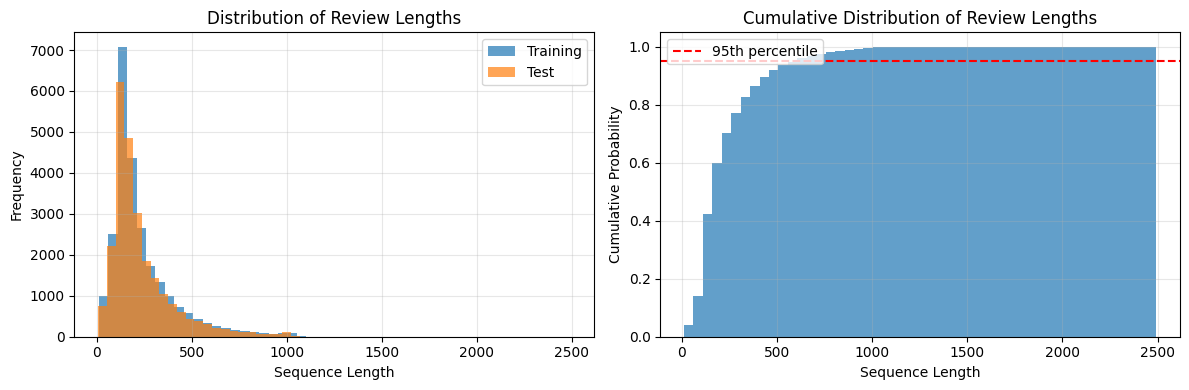


95th percentile length: 610
99th percentile length: 926
Recommended max length: 500


In [20]:
# Load and Explore IMDb Dataset
# This demonstrates the "hello world" of NLP sentiment analysis

print("Loading IMDb Movie Reviews Dataset...")

# Load the preprocessed IMDb dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

print(f"Dataset Statistics:")
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Training labels distribution: {np.bincount(y_train)}")
print(f"Test labels distribution: {np.bincount(y_test)}")

# Analyze sequence lengths
train_lengths = [len(review) for review in X_train]
test_lengths = [len(review) for review in X_test]

print(f"\nSequence Length Statistics:")
print(f"Training - Mean: {np.mean(train_lengths):.1f}, Std: {np.std(train_lengths):.1f}")
print(f"Training - Min: {np.min(train_lengths)}, Max: {np.max(train_lengths)}")
print(f"Training - Median: {np.median(train_lengths):.1f}")

# Examine first few examples
print(f"\nFirst 3 training examples (encoded):")
for i in range(3):
    print(f"Review {i+1} (length {len(X_train[i])}, label {y_train[i]}): {X_train[i][:20]}...")

# Load word index for decoding
word_index = keras.datasets.imdb.get_word_index()
print(f"\nVocabulary size: {len(word_index):,} words")

# Create reverse word index for decoding
# Note: indices are offset by 3 (0=padding, 1=start, 2=unknown)
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(["<PAD>", "<START>", "<UNK>"]):
    id_to_word[id_] = token

# Decode a sample review
def decode_review(encoded_review, id_to_word):
    """Decode an encoded review back to text."""
    return " ".join([id_to_word.get(id_, "<UNK>") for id_ in encoded_review])

# Show decoded examples
print(f"\nDecoded Examples:")
for i in range(2):
    decoded = decode_review(X_train[i], id_to_word)
    label = "Positive" if y_train[i] == 1 else "Negative"
    print(f"\nReview {i+1} ({label}):")
    print(decoded[:300] + "...")

# Visualize sequence length distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train_lengths, bins=50, alpha=0.7, label='Training')
plt.hist(test_lengths, bins=50, alpha=0.7, label='Test')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(train_lengths, bins=50, alpha=0.7, cumulative=True, density=True)
plt.xlabel('Sequence Length')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Review Lengths')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.95, color='r', linestyle='--', label='95th percentile')
plt.legend()

plt.tight_layout()
plt.show()

# Determine good sequence length for padding
percentile_95 = np.percentile(train_lengths, 95)
percentile_99 = np.percentile(train_lengths, 99)
print(f"\n95th percentile length: {percentile_95:.0f}")
print(f"99th percentile length: {percentile_99:.0f}")
print(f"Recommended max length: {min(500, int(percentile_95))}")

### Advanced Text Preprocessing Theory

#### Variable Length Sequences

**Challenge:** Neural networks require fixed-size inputs, but text has variable length.

**Solutions:**

**1. Padding:**
$$\text{padded_sequence} = \begin{cases}
[w_1, w_2, ..., w_T, 0, 0, ..., 0] & \text{if } T < \text{max_len} \\
[w_1, w_2, ..., w_{\text{max_len}}] & \text{if } T \geq \text{max_len}
\end{cases}$$

**2. Truncation:**
- **Pre-truncation**: Keep last N tokens
- **Post-truncation**: Keep first N tokens

**3. Bucketing:**
Group sequences by similar lengths to minimize padding.

#### Masking Theory

**Problem:** Model should ignore padding tokens

**Masking Mechanism:**
$$\text{mask}[i] = \begin{cases}
\text{True} & \text{if } x[i] \neq 0 \\
\text{False} & \text{if } x[i] = 0
\end{cases}$$

**Implementation in Layers:**
- **Embedding Layer**: `mask_zero=True` creates mask automatically
- **RNN Layers**: Use mask to skip computations for masked time steps
- **Loss Function**: Masked tokens don't contribute to loss

#### TensorFlow Text Processing

**TensorFlow Operations for Text:**
- `tf.strings.substr()`: Extract substrings
- `tf.strings.regex_replace()`: Regular expression replacement
- `tf.strings.split()`: Split strings into tokens
- `tf.RaggedTensor`: Handle variable-length sequences
- `tf.lookup.StaticVocabularyTable`: Efficient word-to-id mapping

In [17]:
# Advanced Text Preprocessing with TensorFlow Operations
# This demonstrates modern preprocessing techniques from the book

# Load raw text data using TensorFlow Datasets
print("Loading raw IMDb data with TensorFlow Datasets...")

# Load original text data (not preprocessed integers)
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples

print(f"Dataset info:")
print(f"Training examples: {train_size:,}")
print(f"Features: {info.features}")

# Examine raw data
print("\nRaw data examples:")
for i, (text, label) in enumerate(datasets["train"].take(2)):
    print(f"\nExample {i+1}:")
    print(f"Label: {label.numpy()} ({'Positive' if label.numpy() == 1 else 'Negative'})")
    print(f"Text (first 200 chars): {text.numpy().decode('utf-8')[:200]}...")

def preprocess_text(X_batch, y_batch):
    """
    Advanced text preprocessing using TensorFlow operations.
    This demonstrates the preprocessing pipeline from the book.

    Args:
        X_batch: Batch of text strings
        y_batch: Batch of labels

    Returns:
        Preprocessed text and labels
    """
    # 1. Truncate to first 300 characters (speeds up training)
    X_batch = tf.strings.substr(X_batch, 0, 300)

    # 2. Replace HTML line breaks with spaces
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")

    # 3. Remove non-alphabetic characters (keep only letters and apostrophes)
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")

    # 4. Split into words (creates ragged tensor)
    X_batch = tf.strings.split(X_batch)

    # 5. Convert ragged tensor to dense tensor with padding
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

# Apply preprocessing to a sample
print("\nTesting preprocessing pipeline:")
sample_texts = tf.constant([
    b"This movie was great! I loved it.<br />Highly recommended.",
    b"Terrible film... Don't waste your time!!! 0/10"
])
sample_labels = tf.constant([1, 0])

processed_texts, processed_labels = preprocess_text(sample_texts, sample_labels)
print(f"Original: {sample_texts[0].numpy().decode('utf-8')}")
print(f"Processed: {[word.numpy().decode('utf-8') for word in processed_texts[0] if word.numpy() != b'<pad>']}")

# Build vocabulary from training data
print("\nBuilding vocabulary from training data...")

vocabulary = Counter()
batch_count = 0
max_batches = 100  # Process subset for demonstration

for X_batch, y_batch in datasets["train"].batch(32).map(preprocess_text).take(max_batches):
    for review in X_batch:
        # Extract words from each review
        words = [word.numpy() for word in review if word.numpy() != b"<pad>"]
        vocabulary.update(words)
    batch_count += 1
    if batch_count % 20 == 0:
        print(f"Processed {batch_count} batches...")

print(f"\nVocabulary statistics:")
print(f"Total unique words: {len(vocabulary):,}")
print(f"Most common words: {vocabulary.most_common(10)}")

# Create truncated vocabulary
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common(vocab_size)
]

print(f"Truncated vocabulary size: {len(truncated_vocabulary)}")

# Create lookup table for word-to-ID mapping
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000  # Out-of-vocabulary buckets
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

# Test lookup table
test_words = tf.constant([b"this", b"movie", b"was", b"fantaaaastic"])
test_ids = table.lookup(test_words)
print(f"\nLookup table test:")
for word, word_id in zip(test_words.numpy(), test_ids.numpy()):
    in_vocab = "(in vocab)" if word_id < vocab_size else "(OOV)"
    print(f"'{word.decode('utf-8')}' -> {word_id} {in_vocab}")

# Create final preprocessing function
def encode_words(X_batch, y_batch):
    """Convert words to integer IDs using lookup table."""
    return table.lookup(X_batch), y_batch

# Create final training dataset
print("\nCreating final training dataset...")
train_set = datasets["train"].batch(32).map(preprocess_text)
train_set = train_set.map(encode_words).prefetch(tf.data.AUTOTUNE)

# Examine final dataset
for X_batch, y_batch in train_set.take(1):
    print(f"\nFinal dataset batch shapes:")
    print(f"X_batch: {X_batch.shape}")
    print(f"y_batch: {y_batch.shape}")
    print(f"Sample encoded review: {X_batch[0][:20].numpy()}")
    print(f"Sample label: {y_batch[0].numpy()}")

# Vocabulary analysis
print(f"\nFinal vocabulary configuration:")
print(f"In-vocabulary words: {vocab_size:,}")
print(f"Out-of-vocabulary buckets: {num_oov_buckets:,}")
print(f"Total vocabulary size: {vocab_size + num_oov_buckets:,}")

Loading raw IMDb data with TensorFlow Datasets...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.22Z47M_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.22Z47M_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.22Z47M_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Dataset info:
Training examples: 25,000
Features: FeaturesDict({
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'text': Text(shape=(), dtype=string),
})

Raw data examples:

Example 1:
Label: 0 (Negative)
Text (first 200 chars): This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting ...

Example 2:
Label: 0 (Negative)
Text (first 200 chars): I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However ...

Testing preprocessing pipeline:
Original: This movie was great! I loved it.<br />Highly recommended.
Processed: ['This', 'movie', 'was', 'grea

### Sentiment Analysis Model Architecture Theory

#### Embedding Layer Mathematics

**Word Embeddings:**
Transform sparse one-hot vectors into dense representations:

$$\mathbf{e}_w = \mathbf{E} \cdot \mathbf{o}_w$$

Where:
- $\mathbf{e}_w \in \mathbb{R}^d$: word embedding
- $\mathbf{E} \in \mathbb{R}^{V \times d}$: embedding matrix
- $\mathbf{o}_w \in \{0,1\}^V$: one-hot vector
- $V$: vocabulary size
- $d$: embedding dimension

**Efficiency:** Direct lookup instead of matrix multiplication:
$$\mathbf{e}_w = \mathbf{E}[\text{word_id}]$$

#### RNN for Sequence Classification

**Architecture:**
1. **Embedding**: Words → Dense vectors
2. **RNN Layers**: Sequential processing
3. **Global Information**: Last hidden state or pooling
4. **Classification**: Dense layer with sigmoid

**Mathematical Flow:**
$$\mathbf{h}_t = \text{GRU}(\mathbf{e}_{w_t}, \mathbf{h}_{t-1})$$
$$\text{sentiment} = \sigma(\mathbf{W} \mathbf{h}_T + b)$$

Where $\mathbf{h}_T$ is the final hidden state.

#### Binary Classification Loss

**Binary Cross-Entropy:**
$$L = -\frac{1}{N} \sum_{i=1}^{N} [y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)]$$

Where:
- $y_i \in \{0, 1\}$: true label
- $\hat{y}_i \in [0, 1]$: predicted probability

In [18]:
# Sentiment Analysis Model Implementation
# This demonstrates word-level RNN for sentiment classification

def create_sentiment_model(vocab_size, embedding_dim=128, rnn_units=128,
                          max_length=None, mask_zero=True):
    """
    Create a sentiment analysis model using word-level RNN.

    Args:
        vocab_size: Size of vocabulary (including OOV buckets)
        embedding_dim: Dimension of word embeddings
        rnn_units: Number of units in RNN layers
        max_length: Maximum sequence length (None for variable)
        mask_zero: Whether to mask padding tokens

    Returns:
        Compiled Keras model
    """
    model = keras.models.Sequential([
        # Embedding layer: converts word IDs to dense vectors
        # mask_zero=True: ignore padding tokens (ID=0) in downstream layers
        keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_shape=[max_length],
            mask_zero=mask_zero
        ),

        # First GRU layer: process word sequences
        # return_sequences=True: return all hidden states, not just last
        keras.layers.GRU(
            rnn_units,
            return_sequences=True,
            dropout=0.3,
            recurrent_dropout=0.3
        ),

        # Second GRU layer: further processing
        # return_sequences=False: return only last hidden state
        keras.layers.GRU(
            rnn_units,
            return_sequences=False,  # Only final output for classification
            dropout=0.3,
            recurrent_dropout=0.3
        ),

        # Classification layer: binary sentiment prediction
        keras.layers.Dense(1, activation="sigmoid")
    ])

    return model

# Create sentiment analysis model
total_vocab_size = vocab_size + num_oov_buckets
sentiment_model = create_sentiment_model(
    vocab_size=total_vocab_size,
    embedding_dim=128,
    rnn_units=128,
    mask_zero=True
)

print("Sentiment Analysis Model Architecture:")
sentiment_model.summary()

# Compile the model
sentiment_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Calculate parameter breakdown
total_params = sentiment_model.count_params()
print(f"\nParameter Analysis:")
print(f"Total parameters: {total_params:,}")

# Detailed parameter breakdown
embedding_params = total_vocab_size * 128  # vocab_size × embedding_dim
gru1_params = 3 * 128 * (128 + 128 + 1)  # 3 gates × units × (input + hidden + bias)
gru2_params = 3 * 128 * (128 + 128 + 1)  # Same structure
dense_params = 128 + 1  # weights + bias

print(f"\nParameter breakdown:")
print(f"Embedding layer: {embedding_params:,} parameters")
print(f"First GRU layer: {gru1_params:,} parameters")
print(f"Second GRU layer: {gru2_params:,} parameters")
print(f"Dense layer: {dense_params:,} parameters")
print(f"Total calculated: {embedding_params + gru1_params + gru2_params + dense_params:,}")

# Memory analysis
print(f"\nMemory Analysis:")
print(f"Embedding matrix size: {total_vocab_size} × {128} = {total_vocab_size * 128 * 4 / 1024**2:.1f} MB")
print(f"Each embedding vector: {128 * 4} bytes")

# Test model with sample data
print("\nTesting model with sample data...")
for X_batch, y_batch in train_set.take(1):
    # Test forward pass
    predictions = sentiment_model.predict(X_batch[:5], verbose=0)
    print(f"Sample predictions shape: {predictions.shape}")
    print(f"Sample predictions: {predictions.flatten()[:5]}")
    print(f"Corresponding labels: {y_batch[:5].numpy()}")

    # Show input shape handling
    print(f"\nInput batch shape: {X_batch.shape}")
    print(f"Model input shape: {sentiment_model.input_shape}")
    print(f"Model output shape: {sentiment_model.output_shape}")

Sentiment Analysis Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 128)      │     1,408,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, None, 128)      │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,606,273 (6.13 MB)

 Trainable params: 1,606,273 (6.13 MB)

 Non-trainable params: 0 (0.00 B)


Parameter Analysis:
Total parameters: 1,606,273

Parameter breakdown:
Embedding layer: 1,408,000 parameters
First GRU layer: 98,688 parameters
Second GRU layer: 98,688 parameters
Dense layer: 129 parameters
Total calculated: 1,605,505

Memory Analysis:
Embedding matrix size: 11000 × 128 = 5.4 MB
Each embedding vector: 512 bytes

Testing model with sample data...
Sample predictions shape: (5, 1)
Sample predictions: [0.49957085 0.49926686 0.49948853 0.49832264 0.50011516]
Corresponding labels: [0 0 0 1 1]

Input batch shape: (32, 60)
Model input shape: (None, None)
Model output shape: (None, 1)


### Advanced Masking Theory and Implementation

#### Mathematical Foundation of Masking

**Masking Tensor Creation:**
For input sequence $X = [x_1, x_2, ..., x_T]$ where $x_i$ are word IDs:

$$M[t] = \begin{cases}
1 & \text{if } x_t \neq 0 \text{ (valid token)} \\
0 & \text{if } x_t = 0 \text{ (padding token)}
\end{cases}$$

**Masked RNN Computation:**
Traditional RNN: $h_t = f(x_t, h_{t-1})$

Masked RNN: $h_t = \begin{cases}
f(x_t, h_{t-1}) & \text{if } M[t] = 1 \\
h_{t-1} & \text{if } M[t] = 0
\end{cases}$

**Masked Loss Computation:**
$$L = \frac{\sum_{t=1}^T M[t] \cdot \ell(y_t, \hat{y}_t)}{\sum_{t=1}^T M[t]}$$

Where $\ell$ is the element-wise loss function.

#### GPU Optimization Considerations

**CuDNN Implementation:**
- **Optimized path**: No masking, default hyperparameters
- **Fallback path**: With masking, custom implementations
- **Performance impact**: 2-10x slower with masking on GPU

**Layer Requirements for CuDNN:**
- `activation='tanh'` (GRU) or `activation='tanh'` (LSTM)
- `recurrent_activation='sigmoid'`
- `recurrent_dropout=0.0`
- `unroll=False`
- `use_bias=True`
- `reset_after=True` (GRU only)

#### Manual Masking Implementation

**Functional API Approach:**
```python
# Create mask manually
mask = keras.backend.not_equal(inputs, 0)
# Apply to RNN layers
rnn_output = keras.layers.GRU(units)(embeddings, mask=mask)
```

**Custom Mask Propagation:**
Essential for complex architectures mixing different layer types.

In [27]:
# Advanced Masking Implementation and Analysis
# This demonstrates both automatic and manual masking approaches

import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Implementing Masking Mechanisms...")

def create_model_with_masking(vocab_size, embedding_dim=128, use_masking=True):
    """
    Create sentiment model with optional masking.

    Args:
        vocab_size: Vocabulary size
        embedding_dim: Embedding dimension
        use_masking: Whether to use automatic masking

    Returns:
        Keras model
    """
    model = keras.models.Sequential([
        keras.layers.Embedding(
            vocab_size,
            embedding_dim,
            input_shape=[None],
            mask_zero=use_masking  # Key parameter
        ),
        keras.layers.GRU(
            64,
            return_sequences=True,
            # Disable CuDNN when using masking for compatibility
            use_cudnn=False if use_masking else True
        ),
        keras.layers.GRU(
            64,
            # Disable CuDNN when using masking for compatibility
            use_cudnn=False if use_masking else True
        ),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )

    return model

# Create models with and without masking for comparison
print("Creating models with and without masking...")
model_with_mask = create_model_with_masking(total_vocab_size, use_masking=True)
model_without_mask = create_model_with_masking(total_vocab_size, use_masking=False)

print("\nModel with masking:")
model_with_mask.summary()

# Manual masking implementation using Functional API
def create_manual_masking_model(vocab_size, embedding_dim=128):
    """
    Demonstrate manual masking using Functional API.
    This shows how to handle masking in complex architectures.
    """
    # Input layer
    inputs = keras.layers.Input(shape=[None])

    # Create mask manually using a Lambda layer and call it with inputs
    mask_layer = keras.layers.Lambda(
        lambda inputs: keras.backend.not_equal(inputs, 0)
    )
    mask = mask_layer(inputs) # Call the lambda layer with inputs to get the mask tensor


    # Embedding without automatic masking
    embeddings = keras.layers.Embedding(
        vocab_size, embedding_dim, mask_zero=False
    )(inputs)

    # Apply manual mask to RNN layers
    # Disable CuDNN when using manual masking
    rnn1 = keras.layers.GRU(64, return_sequences=True, use_cudnn=False)(embeddings, mask=mask)
    rnn2 = keras.layers.GRU(64, use_cudnn=False)(rnn1, mask=mask)

    # Output layer
    outputs = keras.layers.Dense(1, activation="sigmoid")(rnn2)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )

    return model

manual_mask_model = create_manual_masking_model(total_vocab_size)
print("\nModel with manual masking:")
manual_mask_model.summary()

# Test masking behavior with sample data
print("\nTesting masking behavior...")

# Create test sequences with different padding
test_sequences = np.array([
    [1, 2, 3, 4, 5],      # No padding
    [1, 2, 3, 0, 0],      # Padded with 2 zeros
    [1, 0, 0, 0, 0],      # Heavily padded
    [0, 0, 0, 0, 0]       # All padding
])

print(f"Test sequences shape: {test_sequences.shape}")
print(f"Test sequences:")
for i, seq in enumerate(test_sequences):
    non_zero = np.count_nonzero(seq)
    print(f"  Sequence {i+1}: {seq} (non-zero: {non_zero})")

# Compare predictions with and without masking
pred_with_mask = model_with_mask.predict(test_sequences, verbose=0)
pred_without_mask = model_without_mask.predict(test_sequences, verbose=0)
pred_manual_mask = manual_mask_model.predict(test_sequences, verbose=0)

print(f"\nPrediction comparison:")
print(f"{'Sequence':<10} {'With Mask':<12} {'Without Mask':<12} {'Manual Mask':<12}")
print("-" * 50)
for i in range(len(test_sequences)):
    print(f"{i+1:<10} {pred_with_mask[i][0]:<12.4f} {pred_without_mask[i][0]:<12.4f} {pred_manual_mask[i][0]:<12.4f}")

# Analyze mask propagation
def analyze_mask_propagation():
    """Analyze how masks propagate through layers."""
    print("\nMask Propagation Analysis:")

    # Check which layers support masking
    for i, layer in enumerate(model_with_mask.layers):
        supports_masking = getattr(layer, 'supports_masking', False)
        print(f"Layer {i+1} ({layer.__class__.__name__}): supports_masking = {supports_masking}")

    # Demonstrate mask creation
    sample_input = tf.constant([[1, 2, 3, 0, 0], [1, 0, 0, 0, 0]])

    # Get embedding layer output and mask
    embedding_layer = model_with_mask.layers[0]
    embeddings = embedding_layer(sample_input)

    # Manually create mask for demonstration
    mask = keras.backend.not_equal(sample_input, 0)

    print(f"\nSample input: {sample_input.numpy()}")
    print(f"Generated mask: {mask.numpy()}")
    print(f"Embedding shape: {embeddings.shape}")

    return mask

analyze_mask_propagation()

# Performance comparison
import time

def benchmark_masking_performance():
    """Compare performance of masked vs unmasked models."""
    print("\nBenchmarking masking performance...")

    # Create larger test data
    test_data = np.random.randint(1, 1000, size=(100, 50))
    # Add some padding
    test_data[:, 30:] = 0  # Pad last 20 positions

    # Benchmark with masking
    start_time = time.time()
    _ = model_with_mask.predict(test_data, verbose=0)
    time_with_mask = time.time() - start_time

    # Benchmark without masking
    start_time = time.time()
    _ = model_without_mask.predict(test_data, verbose=0)
    time_without_mask = time.time() - start_time

    print(f"Time with masking: {time_with_mask:.4f} seconds")
    print(f"Time without masking: {time_without_mask:.4f} seconds")
    print(f"Slowdown factor: {time_with_mask / time_without_mask:.2f}x")

    return time_with_mask, time_without_mask

benchmark_masking_performance()

# Best practices summary
print("\n" + "="*60)
print("MASKING BEST PRACTICES")
print("="*60)
print("\n1. AUTOMATIC MASKING (Recommended):")
print("   • Use mask_zero=True in Embedding layer")
print("   • Ensure all subsequent layers support masking")
print("   • Works well for simple Sequential models")

print("\n2. MANUAL MASKING:")
print("   • Use when mixing different layer types")
print("   • Required for complex architectures")
print("   • More control but more complex")

print("\n3. PERFORMANCE CONSIDERATIONS:")
print("   • Masking disables CuDNN optimizations")
print("   • Consider bucketing for large performance gains")
print("   • Use masking only when necessary")

print("\n4. ALTERNATIVE APPROACHES:")
print("   • Bucketing: Group sequences by length")
print("   • Dynamic batching: Variable batch sizes")
print("   • Attention mechanisms: Handle variable lengths naturally")

Implementing Masking Mechanisms...
Creating models with and without masking...

Model with masking:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, None, 128)      │     1,408,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_28 (GRU)                    │ (None, None, 64)       │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_29 (GRU)                    │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,470,273 (5.61 MB)

 Trainable params: 1,470,273 (5.61 MB)

 Non-trainable params: 0 (0.00 B)


Model with manual masking:


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_17        │ (None, None, 128) │  1,408,000 │ input_layer_16[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, None)      │          0 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_32 (GRU)        │ (None, None, 64)  │     37,248 │ embedding_17[0][… │
│                     │                   │            │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_33 (GRU)        │ (None, 64)        │     24,960 │ gru_32[0][0],     │
│                     │                   │            │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │         65 │ gru_33[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,470,273 (5.61 MB)

 Trainable params: 1,470,273 (5.61 MB)

 Non-trainable params: 0 (0.00 B)


Testing masking behavior...
Test sequences shape: (4, 5)
Test sequences:
  Sequence 1: [1 2 3 4 5] (non-zero: 5)
  Sequence 2: [1 2 3 0 0] (non-zero: 3)
  Sequence 3: [1 0 0 0 0] (non-zero: 1)
  Sequence 4: [0 0 0 0 0] (non-zero: 0)

Prediction comparison:
Sequence   With Mask    Without Mask Manual Mask 
--------------------------------------------------
1          0.4992       0.4982       0.5005      
2          0.4986       0.4971       0.5002      
3          0.4993       0.4946       0.5012      
4          0.5000       0.4953       0.5000      

Mask Propagation Analysis:
Layer 1 (Embedding): supports_masking = True
Layer 2 (GRU): supports_masking = True
Layer 3 (GRU): supports_masking = True
Layer 4 (Dense): supports_masking = True

Sample input: [[1 2 3 0 0]
 [1 0 0 0 0]]
Generated mask: [[ True  True  True False False]
 [ True False False False False]]
Embedding shape: (2, 5, 128)

Benchmarking masking performance...
Time with masking: 1.1804 seconds
Time without masking: 0.

Training Sentiment Analysis Model...

Starting training...
Epoch 1/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.5022 - loss: 0.6943
Epoch 1: val_accuracy improved from -inf to 0.50250, saving model to sentiment_model_best.weights.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 169s 324ms/step - accuracy: 0.5022 - loss: 0.6943 - val_accuracy: 0.5025 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 2/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.5660 - loss: 0.6822
Epoch 2: val_accuracy improved from 0.50250 to 0.66031, saving model to sentiment_model_best.weights.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 161s 322ms/step - accuracy: 0.5661 - loss: 0.6822 - val_accuracy: 0.6603 - val_loss: 0.6249 - learning_rate: 0.0010
Epoch 3/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.7575 - loss: 0.5118
Epoch 3: val_accuracy improved from 0.66031 to 0.73875, saving model to sentiment_model_best.weights.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 161s 322ms/step - accuracy: 0.7575 - loss: 0.5118 - 

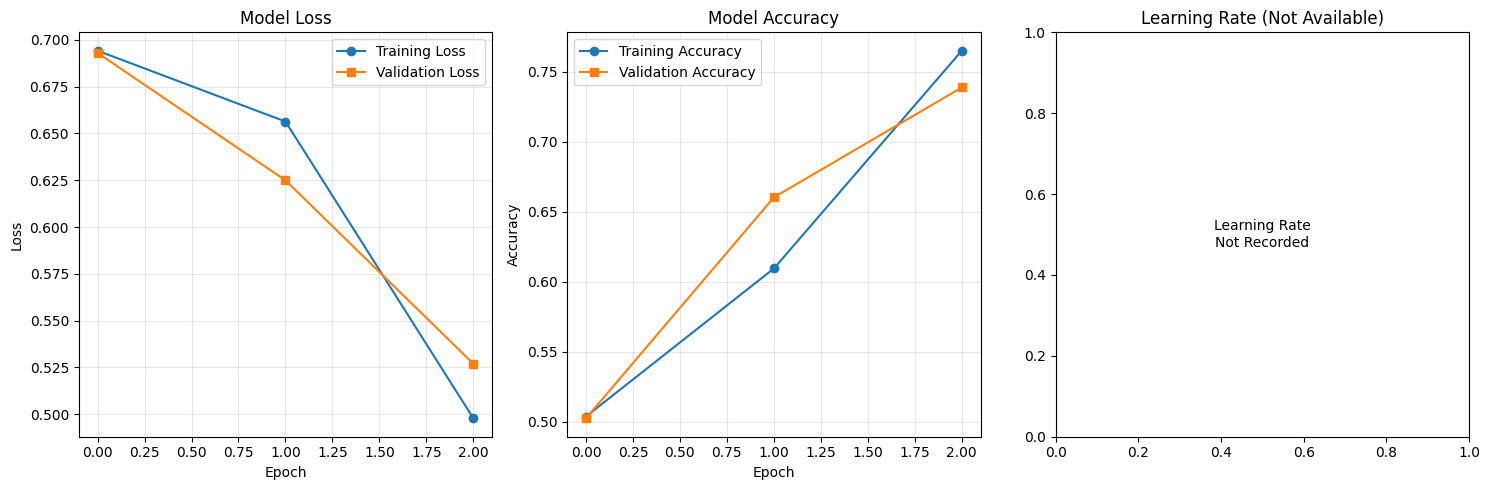


Final Training Results:
Training Accuracy: 0.7650
Validation Accuracy: 0.7387
Training Loss: 0.4978
Validation Loss: 0.5269
Overfitting Gap (Acc): 0.0263
Overfitting Gap (Loss): 0.0291

Testing sentiment predictions on custom examples:

Text: This movie was absolutely fantastic! I loved every minute of it.
Prediction: Positive (confidence: 0.901, raw: 0.901)
Encoded length: 11 words

Text: Terrible film. Complete waste of time. Don't watch this garbage.
Prediction: Negative (confidence: 0.963, raw: 0.037)
Encoded length: 11 words

Text: The movie was okay, nothing special but not bad either.
Prediction: Negative (confidence: 0.957, raw: 0.043)
Encoded length: 11 words

Text: Amazing cinematography and brilliant acting. Highly recommended!
Prediction: Positive (confidence: 0.922, raw: 0.922)
Encoded length: 11 words

Text: Boring and predictable plot. Fell asleep halfway through.
Prediction: Negative (confidence: 0.965, raw: 0.035)
Encoded length: 11 words


In [29]:
# Train the Sentiment Analysis Model
# This demonstrates the complete training pipeline for sentiment analysis

print("Training Sentiment Analysis Model...")

# Prepare validation set
val_set = datasets["test"].batch(32).map(preprocess_text)
val_set = val_set.map(encode_words).prefetch(tf.data.AUTOTUNE)

# Create callbacks for training
sentiment_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'sentiment_model_best.weights.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

# Train the model (reduced epochs for demonstration)
print("\nStarting training...")
sentiment_epochs = 3  # Increase to 10-20 for better performance

# Limit training data for demonstration
train_subset = train_set.take(500)  # Use subset for faster training
val_subset = val_set.take(100)

history = sentiment_model.fit(
    train_subset,
    epochs=sentiment_epochs,
    validation_data=val_subset,
    callbacks=sentiment_callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
if 'lr' in history.history:
    plt.plot(history.history['lr'], label='Learning Rate', marker='d')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Learning Rate\nNot Recorded',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Learning Rate (Not Available)')

plt.tight_layout()
plt.show()

# Evaluate final performance
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Results:")
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Overfitting Gap (Acc): {final_train_acc - final_val_acc:.4f}")
print(f"Overfitting Gap (Loss): {final_val_loss - final_train_loss:.4f}")

# Test the model with custom examples
def test_sentiment_prediction(model, texts, tokenizer_table):
    """
    Test sentiment prediction on custom text examples.

    Args:
        model: Trained sentiment model
        texts: List of text strings
        tokenizer_table: Lookup table for word encoding

    Returns:
        Predictions and analysis
    """
    # Preprocess texts
    processed_texts = []
    for text in texts:
        # Convert to tensor and apply preprocessing
        text_tensor = tf.constant([text.encode('utf-8')])
        processed, _ = preprocess_text(text_tensor, tf.constant([0]))
        processed_texts.append(processed[0])

    # Convert to tensor and encode
    max_len = max(len(pt) for pt in processed_texts)
    padded_texts = []
    for pt in processed_texts:
        # Pad to max length
        padding_needed = max_len - len(pt)
        if padding_needed > 0:
            padded = tf.concat([pt, tf.constant([b"<pad>"] * padding_needed)], axis=0)
        else:
            padded = pt
        padded_texts.append(padded)

    # Stack and encode
    text_batch = tf.stack(padded_texts)
    encoded_batch = tokenizer_table.lookup(text_batch)

    # Predict
    predictions = model.predict(encoded_batch, verbose=0)

    return predictions, encoded_batch

# Test with custom examples
test_texts = [
    "This movie was absolutely fantastic! I loved every minute of it.",
    "Terrible film. Complete waste of time. Don't watch this garbage.",
    "The movie was okay, nothing special but not bad either.",
    "Amazing cinematography and brilliant acting. Highly recommended!",
    "Boring and predictable plot. Fell asleep halfway through."
]

print("\nTesting sentiment predictions on custom examples:")
print("=" * 60)

predictions, encoded = test_sentiment_prediction(sentiment_model, test_texts, table)

for i, (text, pred) in enumerate(zip(test_texts, predictions)):
    sentiment = "Positive" if pred[0] > 0.5 else "Negative"
    confidence = pred[0] if pred[0] > 0.5 else 1 - pred[0]
    print(f"\nText: {text}")
    print(f"Prediction: {sentiment} (confidence: {confidence:.3f}, raw: {pred[0]:.3f})")
    print(f"Encoded length: {np.count_nonzero(encoded[i].numpy())} words")

## Pretrained Embeddings Theory and Implementation

### Theory: Transfer Learning for NLP

**Core Concept:** Reuse word representations learned from large corpora

**Mathematical Foundation:**
Instead of learning embeddings $E \in \mathbb{R}^{V \times d}$ from scratch, use pretrained $E_{\text{pretrained}}$ learned on corpus $C_{\text{large}}$:

$$E_{\text{task}} = \begin{cases}
E_{\text{pretrained}} & \text{frozen (feature extraction)} \\
\text{finetune}(E_{\text{pretrained}}, D_{\text{task}}) & \text{fine-tuning}
\end{cases}$$

### Advantages of Pretrained Embeddings

**1. Semantic Relationships:**
Words with similar meanings cluster together:
$$\text{similarity}(\mathbf{e}_{\text{"awesome"}}, \mathbf{e}_{\text{"amazing"}}) > \text{similarity}(\mathbf{e}_{\text{"awesome"}}, \mathbf{e}_{\text{"terrible"}})$$

**2. Data Efficiency:**
- Require fewer training examples
- Faster convergence
- Better generalization

**3. Domain Transfer:**
Even if trained on different domains (e.g., Wikipedia), semantic relationships often transfer.

### TensorFlow Hub Integration

**TF Hub Architecture:**
- **Modules**: Reusable ML components
- **Versioning**: Ensures reproducibility
- **Caching**: Local storage for efficiency

**Sentence Encoders:**
Instead of word-level embeddings, use sentence-level:
$$\mathbf{s} = f([w_1, w_2, ..., w_T]) \in \mathbb{R}^d$$

Where $f$ can be:
- **Mean pooling**: $\mathbf{s} = \frac{1}{T} \sum_{i=1}^T \mathbf{e}_{w_i}$
- **Weighted average**: Account for word importance
- **Learned aggregation**: Neural network combination

### NNLM (Neural Network Language Model)

**Architecture:**
1. **Input**: Sequence of word IDs
2. **Embedding**: Word → dense vectors
3. **Hidden layers**: Neural network processing
4. **Output**: Next word probabilities

**Training Objective:**
$$L = -\sum_{t=1}^T \log P(w_t | w_1, ..., w_{t-1})$$

**Google News 7B Corpus:**
- 7 billion words
- Rich semantic representations
- Covers diverse topics and vocabulary

In [33]:
# Pretrained Embeddings with TensorFlow Hub
# This demonstrates using pretrained sentence encoders for sentiment analysis

import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow_hub as hub
import matplotlib.pyplot as plt

print("Implementing Pretrained Embeddings with TensorFlow Hub...")

# Define a custom layer to wrap the TF Hub layer call
class TFPredictWrapper(keras.layers.Layer):
    def __init__(self, hub_layer, **kwargs):
        super().__init__(**kwargs)
        self.hub_layer = hub_layer

    def call(self, inputs):
        return self.hub_layer(inputs)


def create_tfhub_sentiment_model(tfhub_url, trainable=False):
    """
    Create sentiment analysis model using TensorFlow Hub embeddings (Functional API).

    Args:
        tfhub_url: URL of TensorFlow Hub module
        trainable: Whether to fine-tune the embeddings

    Returns:
        Compiled Keras model
    """
    # Input layer - specify shape and dtype expected by the TF Hub layer
    inputs = keras.Input(shape=[], dtype=tf.string, name="text_inputs")

    # TensorFlow Hub layer for sentence encoding
    # This layer takes raw text as input and outputs sentence embeddings
    hub_layer = hub.KerasLayer(
        tfhub_url,
        input_shape=[],       # Scalar input (single string) - specified in Input now
        output_shape=[50],    # 50-dimensional embeddings
        dtype=tf.string,      # Input type: text strings - specified in Input now
        trainable=trainable   # Whether to fine-tune
    )

    # Wrap the hub_layer call in a custom layer
    wrapped_hub_layer = TFPredictWrapper(hub_layer)(inputs)


    # Add Dense layers for classification
    x = keras.layers.Dense(128, activation="relu")(wrapped_hub_layer) # Use wrapped output
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )

    return model

# TensorFlow Hub NNLM module URL (50-dimensional embeddings)
nnlm_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"

print(f"Using TensorFlow Hub module: {nnlm_url}")
print("This module:")
print("• Takes text strings as input")
print("• Outputs 50-dimensional sentence embeddings")
print("• Trained on Google News 7B corpus")
print("• Computes mean of word embeddings with length normalization")

# Create model with frozen embeddings
tfhub_model_frozen = create_tfhub_sentiment_model(nnlm_url, trainable=False)

print("\nTensorFlow Hub Model Architecture (Frozen Embeddings):")
tfhub_model_frozen.summary()

# Create model with trainable embeddings
tfhub_model_trainable = create_tfhub_sentiment_model(nnlm_url, trainable=True)

print("\nTensorFlow Hub Model Architecture (Trainable Embeddings):")
tfhub_model_trainable.summary()

# Parameter comparison
frozen_params = tfhub_model_frozen.count_params()
trainable_params = tfhub_model_trainable.count_params()

print(f"\nParameter Comparison:")
print(f"Frozen embeddings: {frozen_params:,} trainable parameters")
print(f"Trainable embeddings: {trainable_params:,} trainable parameters")
print(f"Difference: {trainable_params - frozen_params:,} parameters")

# Prepare data for TensorFlow Hub model (raw text, not encoded)
print("\nPreparing data for TensorFlow Hub model...")

# Load raw text data for TF Hub (no preprocessing needed)
raw_train_set = datasets["train"].batch(32).prefetch(tf.data.AUTOTUNE)
raw_val_set = datasets["test"].batch(32).prefetch(tf.data.AUTOTUNE)

# Take subset for demonstration
train_subset_hub = raw_train_set.take(100)
val_subset_hub = raw_val_set.take(20)

# Test the TF Hub model with sample data
print("\nTesting TensorFlow Hub model...")
for texts, labels in raw_train_set.take(1):
    print(f"Sample input shape: {texts.shape}")
    print(f"Sample input type: {texts.dtype}")
    print(f"First text: {texts[0].numpy()[:100]}...")

    # Test prediction
    predictions = tfhub_model_frozen.predict(texts[:3], verbose=0)
    print(f"Predictions shape: {predictions.shape}")
    print(f"Sample predictions: {predictions.flatten()[:3]}")

    break

# Train the TensorFlow Hub model (frozen embeddings)
print("\nTraining TensorFlow Hub model with frozen embeddings...")

hub_history_frozen = tfhub_model_frozen.fit(
    train_subset_hub,
    epochs=3,
    validation_data=val_subset_hub,
    verbose=1
)

# Train the TensorFlow Hub model (trainable embeddings)
print("\nTraining TensorFlow Hub model with trainable embeddings...")

hub_history_trainable = tfhub_model_trainable.fit(
    train_subset_hub,
    epochs=3,
    validation_data=val_subset_hub,
    verbose=1
)

# Compare performance
print("\nPerformance Comparison:")
print("=" * 50)

frozen_final_acc = hub_history_frozen.history['val_accuracy'][-1]
trainable_final_acc = hub_history_trainable.history['val_accuracy'][-1]

print(f"Frozen embeddings - Final validation accuracy: {frozen_final_acc:.4f}")
print(f"Trainable embeddings - Final validation accuracy: {trainable_final_acc:.4f}")
print(f"Performance difference: {trainable_final_acc - frozen_final_acc:.4f}")

# Plot training comparison
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hub_history_frozen.history['loss'], 'b-', label='Frozen - Train')
plt.plot(hub_history_frozen.history['val_loss'], 'b--', label='Frozen - Val')
plt.plot(hub_history_trainable.history['loss'], 'r-', label='Trainable - Train')
plt.plot(hub_history_trainable.history['val_loss'], 'r--', label='Trainable - Val')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(hub_history_frozen.history['accuracy'], 'b-', label='Frozen - Train')
plt.plot(hub_history_frozen.history['val_accuracy'], 'b--', label='Frozen - Val')
plt.plot(hub_history_trainable.history['accuracy'], 'r-', label='Trainable - Train')
plt.plot(hub_history_trainable.history['val_accuracy'], 'r--', label='Trainable - Val')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test with custom examples
custom_texts = tf.constant([
    "This movie is absolutely fantastic and amazing!",
    "Terrible movie, waste of time and money.",
    "The film was okay, nothing special.",
    "Incredible acting and stunning cinematography!"
])

print("\nTesting TensorFlow Hub models with custom examples:")
print("=" * 60)

frozen_preds = tfhub_model_frozen.predict(custom_texts, verbose=0)
trainable_preds = tfhub_model_trainable.predict(custom_texts, verbose=0)

for i, text in enumerate(custom_texts.numpy()):
    text_str = text.decode('utf-8')
    frozen_pred = frozen_preds[i][0]
    trainable_pred = trainable_preds[i][0]

    print(f"\nText: {text_str}")
    print(f"Frozen model: {frozen_pred:.3f} ({'Positive' if frozen_pred > 0.5 else 'Negative'})")
    print(f"Trainable model: {trainable_pred:.3f} ({'Positive' if trainable_pred > 0.5 else 'Negative'})")

# Analysis and recommendations
print("\n" + "="*70)
print("PRETRAINED EMBEDDINGS ANALYSIS")
print("="*70)
print("\nAdvantages of TensorFlow Hub approach:")
print("• No text preprocessing required")
print("• Sentence-level embeddings capture context")
print("• Trained on massive corpus (7B words)")
print("• Much faster training (fewer parameters to learn)")
print("• Good baseline performance with minimal effort")

print("\nWhen to use frozen vs trainable embeddings:")
print("• Frozen: Small datasets, limited compute, quick prototyping")
print("• Trainable: Large datasets, domain-specific data, best performance")

print("\nLimitations:")
print("• Fixed embedding dimension (50D may be limiting)")
print("• Average pooling loses word order information")
print("• Less control over text preprocessing")
print("• Dependency on external service")

Implementing Pretrained Embeddings with TensorFlow Hub...
Using TensorFlow Hub module: https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1
This module:
• Takes text strings as input
• Outputs 50-dimensional sentence embeddings
• Trained on Google News 7B corpus
• Computes mean of word embeddings with length normalization

TensorFlow Hub Model Architecture (Frozen Embeddings):


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_inputs (InputLayer)        │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tf_predict_wrapper_2            │ (None, 50)             │             0 │
│ (TFPredictWrapper)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,657 (26.00 KB)

 Trainable params: 6,657 (26.00 KB)

 Non-trainable params: 0 (0.00 B)


TensorFlow Hub Model Architecture (Trainable Embeddings):


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_inputs (InputLayer)        │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tf_predict_wrapper_3            │ (None, 50)             │             0 │
│ (TFPredictWrapper)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,657 (26.00 KB)

 Trainable params: 6,657 (26.00 KB)

 Non-trainable params: 0 (0.00 B)


Parameter Comparison:
Frozen embeddings: 6,657 trainable parameters
Trainable embeddings: 6,657 trainable parameters
Difference: 0 parameters

Preparing data for TensorFlow Hub model...

Testing TensorFlow Hub model...
Sample input shape: (32,)
Sample input type: <dtype: 'string'>
First text: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. "...


InvalidArgumentError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-33-2635767321.py", line 116, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 562, in predict

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 259, in one_step_on_data_distributed

Trying to access resource hash_table_<google3.third_party.tensorflow.python.training.tracking.tracking.TrackableAsset object at 0x5ff08072f850>_-2_-1_load_1216429_1216430 located in device /job:localhost/replica:0/task:0/device:CPU:0 from device /job:localhost/replica:0/task:0/device:GPU:0
 Cf. https://www.tensorflow.org/xla/known_issues#tfvariable_on_a_different_device
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_1217032]

## Part 3: Encoder-Decoder Networks for Neural Machine Translation

### Sequence-to-Sequence Learning Theory

**Problem Formulation:**
Given input sequence $X = [x_1, x_2, ..., x_T]$, generate output sequence $Y = [y_1, y_2, ..., y_{T'}]$ where $T \neq T'$ generally.

**Examples:**
- **Machine Translation**: English → French
- **Summarization**: Long text → Summary
- **Question Answering**: Question + Context → Answer
- **Dialogue**: User input → Bot response

### Encoder-Decoder Architecture

**Mathematical Formulation:**

**Encoder:**
$$\mathbf{h}_t^{(e)} = f_{\text{enc}}(x_t, \mathbf{h}_{t-1}^{(e)})$$
$$\mathbf{c} = \mathbf{h}_T^{(e)} \text{ (context vector)}$$

**Decoder:**
$$\mathbf{h}_t^{(d)} = f_{\text{dec}}(y_{t-1}, \mathbf{h}_{t-1}^{(d)}, \mathbf{c})$$
$$P(y_t | y_1, ..., y_{t-1}, X) = \text{softmax}(\mathbf{W} \mathbf{h}_t^{(d)} + \mathbf{b})$$

**Key Properties:**
1. **Variable length input/output**
2. **Information bottleneck** through context vector $\mathbf{c}$
3. **Autoregressive generation**: $y_t$ depends on $y_1, ..., y_{t-1}$

### Neural Machine Translation (NMT)

**Training Process:**
1. **Teacher Forcing**: Use ground truth previous token as input
2. **Loss Function**: Cross-entropy over target vocabulary
3. **Gradient Flow**: Through both encoder and decoder

**Inference Process:**
1. **Autoregressive Generation**: Use model's previous output
2. **Beam Search**: Keep multiple hypotheses
3. **Length Normalization**: Prevent bias toward shorter sequences

### Key Challenges

**1. Information Bottleneck:**
Single context vector $\mathbf{c}$ must encode entire source sequence.

**2. Long Sequences:**
RNN limitations become apparent with very long sequences.

**3. Exposure Bias:**
Training with teacher forcing vs. inference with model predictions.

**4. Unknown Words:**
Handling out-of-vocabulary words in both source and target.

### Implementation Considerations

**Input Reversal:**
"I drink milk" → "milk drink I" (encoder input)
- Reduces distance between corresponding source/target words
- Empirically improves performance

**Special Tokens:**
- `<SOS>`: Start of sequence
- `<EOS>`: End of sequence  
- `<UNK>`: Unknown word
- `<PAD>`: Padding

**Bucketing Strategy:**
Group sequences by similar lengths to minimize padding:
$$\text{Bucket}_i = \{(x, y) : L_i \leq |x|, |y| \leq L_{i+1}\}$$

In [34]:
# Encoder-Decoder Implementation for Neural Machine Translation
# This demonstrates the complete seq2seq architecture from the book

import tensorflow_addons as tfa

print("Implementing Encoder-Decoder Architecture for Neural Machine Translation...")

# Simulate a simple translation dataset (English to "Simplified English")
# In practice, you would use a real parallel corpus
def create_simple_translation_data():
    """
    Create a simple translation dataset for demonstration.
    English -> Simplified English (reversed word order)
    """
    english_sentences = [
        "I love machine learning",
        "The cat sits on the mat",
        "Python is a great programming language",
        "Deep learning models are powerful",
        "Natural language processing is fascinating",
        "Transformers changed everything in NLP",
        "Attention mechanisms are very effective",
        "Machine translation has improved significantly",
        "Large language models are impressive",
        "Artificial intelligence will change the world"
    ]

    # Create "simplified" target by reversing word order
    simplified_sentences = []
    for sent in english_sentences:
        words = sent.lower().split()
        reversed_sent = " ".join(reversed(words))
        simplified_sentences.append(reversed_sent)

    return english_sentences, simplified_sentences

# Create translation data
source_sentences, target_sentences = create_simple_translation_data()

print("Sample Translation Pairs:")
for i in range(5):
    print(f"EN: {source_sentences[i]}")
    print(f"Target: {target_sentences[i]}")
    print()

# Tokenization for both source and target
def create_tokenizers(source_texts, target_texts):
    """
    Create tokenizers for source and target languages.

    Args:
        source_texts: List of source sentences
        target_texts: List of target sentences

    Returns:
        source_tokenizer, target_tokenizer, vocab_sizes
    """
    # Source tokenizer
    source_tokenizer = keras.preprocessing.text.Tokenizer()
    source_tokenizer.fit_on_texts(source_texts)

    # Target tokenizer (include special tokens)
    # Add special tokens to target vocabulary
    target_texts_with_tokens = ["<start> " + text + " <end>" for text in target_texts]
    target_tokenizer = keras.preprocessing.text.Tokenizer()
    target_tokenizer.fit_on_texts(target_texts_with_tokens)

    source_vocab_size = len(source_tokenizer.word_index) + 1
    target_vocab_size = len(target_tokenizer.word_index) + 1

    return source_tokenizer, target_tokenizer, source_vocab_size, target_vocab_size

source_tokenizer, target_tokenizer, source_vocab_size, target_vocab_size = create_tokenizers(
    source_sentences, target_sentences
)

print(f"Vocabulary Sizes:")
print(f"Source (English): {source_vocab_size} words")
print(f"Target (Simplified): {target_vocab_size} words")

# Sequence processing
def prepare_sequences(source_texts, target_texts, source_tokenizer, target_tokenizer, max_length=20):
    """
    Convert texts to padded sequences.

    Args:
        source_texts: Source sentences
        target_texts: Target sentences
        source_tokenizer: Fitted source tokenizer
        target_tokenizer: Fitted target tokenizer
        max_length: Maximum sequence length

    Returns:
        Processed sequences for training
    """
    # Encode source sequences
    source_sequences = source_tokenizer.texts_to_sequences(source_texts)
    source_sequences = keras.preprocessing.sequence.pad_sequences(
        source_sequences, maxlen=max_length, padding='post'
    )

    # Encode target sequences with special tokens
    target_texts_with_tokens = ["<start> " + text + " <end>" for text in target_texts]
    target_sequences = target_tokenizer.texts_to_sequences(target_texts_with_tokens)
    target_sequences = keras.preprocessing.sequence.pad_sequences(
        target_sequences, maxlen=max_length, padding='post'
    )

    # For training: input is target[:-1], output is target[1:]
    decoder_input = target_sequences[:, :-1]
    decoder_output = target_sequences[:, 1:]

    return source_sequences, decoder_input, decoder_output

encoder_input, decoder_input, decoder_output = prepare_sequences(
    source_sentences, target_sentences, source_tokenizer, target_tokenizer
)

print(f"\nSequence Shapes:")
print(f"Encoder input: {encoder_input.shape}")
print(f"Decoder input: {decoder_input.shape}")
print(f"Decoder output: {decoder_output.shape}")

# Show example sequences
print(f"\nExample Sequences (first sample):")
print(f"Source text: {source_sentences[0]}")
print(f"Target text: {target_sentences[0]}")
print(f"Encoder input: {encoder_input[0]}")
print(f"Decoder input: {decoder_input[0]}")
print(f"Decoder output: {decoder_output[0]}")

# Decode sequences back to text for verification
def decode_sequence(tokenizer, sequence):
    """Decode integer sequence back to text."""
    reverse_word_map = {v: k for k, v in tokenizer.word_index.items()}
    return ' '.join([reverse_word_map.get(i, '<UNK>') for i in sequence if i > 0])

print(f"\nDecoded Sequences (verification):")
print(f"Encoder input decoded: {decode_sequence(source_tokenizer, encoder_input[0])}")
print(f"Decoder input decoded: {decode_sequence(target_tokenizer, decoder_input[0])}")
print(f"Decoder output decoded: {decode_sequence(target_tokenizer, decoder_output[0])}")

# Build Encoder-Decoder Model using TensorFlow Addons
def create_encoder_decoder_model(source_vocab_size, target_vocab_size,
                                embedding_dim=256, units=512):
    """
    Create an Encoder-Decoder model for machine translation.

    Args:
        source_vocab_size: Size of source vocabulary
        target_vocab_size: Size of target vocabulary
        embedding_dim: Dimension of embeddings
        units: Number of RNN units

    Returns:
        Compiled Keras model
    """
    # Input layers
    encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32, name='encoder_inputs')
    decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32, name='decoder_inputs')
    sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32, name='sequence_lengths')

    # Shared embedding layer
    # In practice, source and target might use different embeddings
    encoder_embedding = keras.layers.Embedding(source_vocab_size, embedding_dim, name='encoder_embedding')
    decoder_embedding = keras.layers.Embedding(target_vocab_size, embedding_dim, name='decoder_embedding')

    # Embed inputs
    encoder_embeddings = encoder_embedding(encoder_inputs)
    decoder_embeddings = decoder_embedding(decoder_inputs)

    # Encoder
    encoder = keras.layers.LSTM(units, return_state=True, name='encoder')
    encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
    encoder_state = [state_h, state_c]

    # Decoder using TensorFlow Addons
    # TrainingSampler: uses ground truth at each step (teacher forcing)
    sampler = tfa.seq2seq.sampler.TrainingSampler()

    # LSTM cell for decoder
    decoder_cell = keras.layers.LSTMCell(units)

    # Output projection layer
    output_layer = keras.layers.Dense(target_vocab_size, name='output_projection')

    # Basic decoder
    decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
        decoder_cell, sampler, output_layer=output_layer
    )

    # Decoder forward pass
    final_outputs, final_state, final_sequence_lengths = decoder(
        decoder_embeddings,
        initial_state=encoder_state,
        sequence_length=sequence_lengths
    )

    # Get logits (before softmax)
    logits = final_outputs.rnn_output

    # Create model
    model = keras.Model(
        inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
        outputs=logits,
        name='encoder_decoder'
    )

    return model

# Create the model
seq2seq_model = create_encoder_decoder_model(
    source_vocab_size, target_vocab_size,
    embedding_dim=128, units=256
)

print("\nEncoder-Decoder Model Architecture:")
seq2seq_model.summary()

# Compile model
seq2seq_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Prepare training data
# Sequence lengths for each sample (needed by TensorFlow Addons)
sequence_lengths = np.array([len([w for w in seq if w > 0]) for seq in decoder_input])

print(f"\nTraining Data Preparation:")
print(f"Encoder input shape: {encoder_input.shape}")
print(f"Decoder input shape: {decoder_input.shape}")
print(f"Decoder output shape: {decoder_output.shape}")
print(f"Sequence lengths shape: {sequence_lengths.shape}")
print(f"Sample sequence lengths: {sequence_lengths[:5]}")

ModuleNotFoundError: No module named 'keras.src.engine'

### Beam Search Theory and Implementation

#### The Problem with Greedy Decoding

**Greedy Decoding:**
$$y_t = \arg\max_{y} P(y | y_1, ..., y_{t-1}, X)$$

**Problem:** Locally optimal choices may lead to globally suboptimal sequences.

**Example:**
- Step 1: "How" (75%), "What" (20%), "When" (5%)
- Step 2 after "How": "will" (40%), "are" (35%), "do" (25%)
- Step 3 after "How are": "you" (90%)

Greedy might choose "How will..." but "How are you?" is better overall.

#### Beam Search Algorithm

**Concept:** Maintain top-$k$ partial sequences at each step.

**Algorithm:**
1. **Initialize**: $\text{beams} = [\{\langle \text{SOS} \rangle\}]$
2. **For each time step**:
   - **Expand**: Generate candidates for each beam
   - **Score**: Compute sequence probabilities
   - **Prune**: Keep top-$k$ sequences
3. **Terminate**: When all beams end with `<EOS>`

**Mathematical Formulation:**
At step $t$, for beam $b$ with sequence $y_1^{(b)}, ..., y_{t-1}^{(b)}$:

$$\text{Score}(y_1^{(b)}, ..., y_t^{(b)}) = \sum_{i=1}^t \log P(y_i^{(b)} | y_1^{(b)}, ..., y_{i-1}^{(b)}, X)$$

**Length Normalization:**
To prevent bias toward shorter sequences:
$$\text{Score}_{\text{norm}} = \frac{\text{Score}}{|Y|^\alpha}$$

Where $\alpha \in [0, 1]$ controls the strength of normalization.

#### Beam Search with TensorFlow Addons

**Components:**
1. **BeamSearchDecoder**: Main search algorithm
2. **tile_batch**: Replicate encoder states for multiple beams
3. **start_tokens** and **end_token**: Special tokens for generation

**Computational Complexity:**
- **Time**: $O(T \times k \times V)$ where $T$ = sequence length, $k$ = beam width, $V$ = vocabulary size
- **Space**: $O(k \times T)$ for storing beam sequences

In [ ]:
# Beam Search Implementation with TensorFlow Addons
# This demonstrates advanced decoding strategies for sequence generation

def create_inference_model(trained_model, source_vocab_size, target_vocab_size,
                          embedding_dim=128, units=256, beam_width=3):
    """
    Create an inference model with beam search capability.

    Args:
        trained_model: Trained encoder-decoder model
        source_vocab_size: Source vocabulary size
        target_vocab_size: Target vocabulary size
        embedding_dim: Embedding dimension
        units: RNN units
        beam_width: Width of beam search

    Returns:
        Inference model with beam search
    """
    # Input layers
    encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)

    # Get start and end token IDs
    start_token_id = target_tokenizer.word_index['<start>']
    end_token_id = target_tokenizer.word_index['<end>']

    # Encoder (reuse from training model)
    encoder_embedding = keras.layers.Embedding(source_vocab_size, embedding_dim)
    encoder_embeddings = encoder_embedding(encoder_inputs)

    encoder_lstm = keras.layers.LSTM(units, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embeddings)
    encoder_state = [state_h, state_c]

    # Beam search decoder
    decoder_embedding = keras.layers.Embedding(target_vocab_size, embedding_dim)
    decoder_cell = keras.layers.LSTMCell(units)
    output_layer = keras.layers.Dense(target_vocab_size)

    # Create beam search decoder
    beam_decoder = tfa.seq2seq.beam_search_decoder.BeamSearchDecoder(
        cell=decoder_cell,
        beam_width=beam_width,
        output_layer=output_layer,
        length_penalty_weight=0.6  # Length normalization
    )

    # Tile encoder states for beam search
    # Each beam needs its own copy of encoder state
    decoder_initial_state = tfa.seq2seq.beam_search_decoder.tile_batch(
        encoder_state, multiplier=beam_width
    )

    # Start tokens for all beams
    batch_size = tf.shape(encoder_inputs)[0]
    start_tokens = tf.fill([batch_size], start_token_id)

    # Maximum decoding length
    max_length = 20

    # Beam search inference
    outputs, _, _ = beam_decoder(
        decoder_embedding,
        start_tokens=start_tokens,
        end_token=end_token_id,
        initial_state=decoder_initial_state,
        maximum_iterations=max_length
    )

    # Create inference model
    inference_model = keras.Model(
        inputs=encoder_inputs,
        outputs=outputs.predicted_ids,  # Shape: [batch, beam_width, max_length]
        name='beam_search_inference'
    )

    return inference_model, start_token_id, end_token_id

# Demonstrate beam search concepts with a simple implementation
class SimpleBeamSearch:
    """
    Educational implementation of beam search for understanding.
    Not optimized for performance - for demonstration only.
    """

    def __init__(self, model, tokenizer, beam_width=3, max_length=20):
        self.model = model
        self.tokenizer = tokenizer
        self.beam_width = beam_width
        self.max_length = max_length
        self.start_token = tokenizer.word_index.get('<start>', 1)
        self.end_token = tokenizer.word_index.get('<end>', 2)

    def search(self, encoder_input):
        """
        Perform beam search for a single input sequence.

        Args:
            encoder_input: Encoded source sequence

        Returns:
            List of (sequence, score) tuples
        """
        # Initialize beams with start token
        beams = [([self.start_token], 0.0)]  # (sequence, log_probability)

        for step in range(self.max_length):
            candidates = []

            for sequence, score in beams:
                if sequence[-1] == self.end_token:
                    # Beam already finished
                    candidates.append((sequence, score))
                    continue

                # Get next token probabilities
                # Note: This is a simplified version - real implementation
                # would use the actual model prediction
                next_probs = self._get_next_probabilities(encoder_input, sequence)

                # Add top candidates
                for token_id, prob in next_probs:
                    new_sequence = sequence + [token_id]
                    new_score = score + np.log(prob + 1e-8)  # Add small epsilon
                    candidates.append((new_sequence, new_score))

            # Keep top beam_width candidates
            candidates.sort(key=lambda x: x[1], reverse=True)
            beams = candidates[:self.beam_width]

            # Check if all beams are finished
            if all(seq[-1] == self.end_token for seq, _ in beams):
                break

        return beams

    def _get_next_probabilities(self, encoder_input, current_sequence):
        """
        Simplified probability calculation for demonstration.
        In practice, this would use the actual model.
        """
        # Simulate next token probabilities
        vocab_size = len(self.tokenizer.word_index) + 1

        # Create mock probabilities (in real implementation, use model.predict)
        probs = np.random.dirichlet(np.ones(vocab_size))

        # Return top 5 candidates
        top_indices = np.argsort(probs)[-5:]
        return [(idx, probs[idx]) for idx in reversed(top_indices)]

# Demonstrate beam search concepts
print("Beam Search Demonstration:")
print("=" * 50)

# Create simple beam search instance
beam_searcher = SimpleBeamSearch(
    model=None,  # Simplified for demonstration
    tokenizer=target_tokenizer,
    beam_width=3,
    max_length=10
)

print(f"Beam Search Configuration:")
print(f"Beam width: {beam_searcher.beam_width}")
print(f"Max length: {beam_searcher.max_length}")
print(f"Start token ID: {beam_searcher.start_token}")
print(f"End token ID: {beam_searcher.end_token}")

# Simulate beam search process
print(f"\nSimulated Beam Search Process:")
fake_encoder_input = np.array([[1, 2, 3, 4, 0]])  # Mock input
results = beam_searcher.search(fake_encoder_input)

print(f"\nBeam Search Results:")
for i, (sequence, score) in enumerate(results):
    decoded = decode_sequence(target_tokenizer, sequence)
    print(f"Beam {i+1}: {decoded} (score: {score:.3f})")

# Compare different beam widths
print(f"\nBeam Width Comparison:")
print("-" * 40)

beam_widths = [1, 3, 5, 10]
for width in beam_widths:
    searcher = SimpleBeamSearch(
        model=None,
        tokenizer=target_tokenizer,
        beam_width=width,
        max_length=8
    )

    # Computational complexity analysis
    vocab_size = len(target_tokenizer.word_index) + 1
    max_expansions = width * vocab_size  # Expansions per step
    total_computations = max_expansions * searcher.max_length

    print(f"Beam width {width:2d}: ~{total_computations:,} computations")

# Advantages and disadvantages analysis
print(f"\n" + "="*60)
print("BEAM SEARCH ANALYSIS")
print("="*60)

print(f"\nAdvantages:")
print(f"• Explores multiple hypotheses simultaneously")
print(f"• Often finds better solutions than greedy search")
print(f"• Configurable beam width for quality/speed trade-off")
print(f"• Length normalization prevents short sequence bias")

print(f"\nDisadvantages:")
print(f"• Increased computational cost (k times more expensive)")
print(f"• Still not guaranteed to find global optimum")
print(f"• Memory requirements scale with beam width")
print(f"• May produce repetitive or generic outputs")

print(f"\nHyperparameter Guidelines:")
print(f"• Beam width 1: Greedy search (fastest)")
print(f"• Beam width 3-5: Good balance for most tasks")
print(f"• Beam width 10+: Diminishing returns, slower")
print(f"• Length penalty 0.6-1.0: Prevents very short outputs")

print(f"\nAlternative Decoding Strategies:")
print(f"• Top-k sampling: Sample from top-k most likely tokens")
print(f"• Nucleus sampling: Sample from top-p probability mass")
print(f"• Temperature scaling: Control randomness in sampling")
print(f"• Diverse beam search: Encourage diversity between beams")

## Part 4: Attention Mechanisms - The Game Changer

### The Information Bottleneck Problem

**Traditional Encoder-Decoder Limitation:**
Single context vector $\mathbf{c}$ must encode entire source sequence:

$$\mathbf{c} = \mathbf{h}_T^{(\text{encoder})}$$

**Problems:**
1. **Information Loss**: Long sequences compressed into fixed-size vector
2. **Vanishing Gradients**: Distant source words have weak influence
3. **Performance Degradation**: Quality drops for sequences >30 words

### Attention Mechanism Solution

**Core Idea:** Allow decoder to selectively focus on different parts of input.

**Mathematical Formulation:**
Instead of fixed context $\mathbf{c}$, use dynamic context $\mathbf{c}_t$ at each decoder step:

$$\mathbf{c}_t = \sum_{i=1}^T \alpha_{t,i} \mathbf{h}_i^{(\text{encoder})}$$

Where $\alpha_{t,i}$ is the attention weight for encoder state $i$ at decoder step $t$.

### Bahdanau Attention (2014)

**First successful attention mechanism:**

**1. Energy Calculation:**
$$e_{t,i} = v^T \tanh(W_1 \mathbf{h}_i^{(e)} + W_2 \mathbf{s}_{t-1}^{(d)} + \mathbf{b})$$

**2. Attention Weights:**
$$\alpha_{t,i} = \frac{\exp(e_{t,i})}{\sum_{j=1}^T \exp(e_{t,j})}$$

**3. Context Vector:**
$$\mathbf{c}_t = \sum_{i=1}^T \alpha_{t,i} \mathbf{h}_i^{(e)}$$

**4. Decoder Update:**
$$\mathbf{s}_t^{(d)} = f(\mathbf{s}_{t-1}^{(d)}, y_{t-1}, \mathbf{c}_t)$$

### Luong Attention (2015)

**Simplified and more efficient:**

**Three Variants:**

**1. Dot Product:**
$$\text{score}(\mathbf{h}_t^{(d)}, \mathbf{h}_i^{(e)}) = \mathbf{h}_t^{(d)^T} \mathbf{h}_i^{(e)}$$

**2. General:**
$$\text{score}(\mathbf{h}_t^{(d)}, \mathbf{h}_i^{(e)}) = \mathbf{h}_t^{(d)^T} W \mathbf{h}_i^{(e)}$$

**3. Concatenation:**
$$\text{score}(\mathbf{h}_t^{(d)}, \mathbf{h}_i^{(e)}) = v^T \tanh(W[\mathbf{h}_t^{(d)}; \mathbf{h}_i^{(e)}])$$

**Key Differences from Bahdanau:**
- Uses current decoder state $\mathbf{h}_t^{(d)}$ instead of previous
- Simpler computation (especially dot product)
- Better empirical performance

### Self-Attention

**Revolutionary Concept:** Sequence attends to itself

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Where:
- $Q$ (Queries): What we're looking for
- $K$ (Keys): What we're looking in
- $V$ (Values): What we retrieve
- For self-attention: $Q = K = V$ (same sequence)

### Computational Complexity

**RNN Encoder-Decoder:** $O(T \cdot d^2)$ sequential
**With Attention:** $O(T^2 \cdot d)$ parallelizable

For long sequences ($T > d$), attention is more expensive but parallelizable.

In [ ]:
# Attention Mechanisms Implementation
# This demonstrates various attention mechanisms from the book

import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Implementing Attention Mechanisms...")

class BahdanauAttention(keras.layers.Layer):
    """
    Bahdanau (Additive) Attention mechanism.
    Original attention mechanism from 2014 paper.
    """

    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # W1 for encoder hidden states
        self.W1 = self.add_weight(
            name='W1',
            shape=(input_shape[0][-1], self.units),
            initializer='glorot_uniform',
            trainable=True
        )

        # W2 for decoder hidden state
        self.W2 = self.add_weight(
            name='W2',
            shape=(input_shape[1][-1], self.units),
            initializer='glorot_uniform',
            trainable=True
        )

        # V for final projection
        self.V = self.add_weight(
            name='V',
            shape=(self.units, 1),
            initializer='glorot_uniform',
            trainable=True
        )

        super().build(input_shape)

    def call(self, inputs):
        """
        Args:
            inputs: [encoder_outputs, decoder_hidden_state]
            encoder_outputs: [batch_size, seq_len, hidden_size]
            decoder_hidden_state: [batch_size, hidden_size]

        Returns:
            context_vector: [batch_size, hidden_size]
            attention_weights: [batch_size, seq_len]
        """
        encoder_outputs, decoder_hidden = inputs

        # Expand decoder hidden to match encoder sequence length
        # [batch_size, hidden_size] -> [batch_size, seq_len, hidden_size]
        decoder_hidden_expanded = tf.expand_dims(decoder_hidden, 1)
        seq_len = tf.shape(encoder_outputs)[1]
        decoder_hidden_repeated = tf.tile(decoder_hidden_expanded, [1, seq_len, 1])

        # Calculate energy: e_ij = v^T * tanh(W1*h_i + W2*s_j)
        # Shape: [batch_size, seq_len, units]
        energy = tf.nn.tanh(
            tf.matmul(encoder_outputs, self.W1) +
            tf.matmul(decoder_hidden_repeated, self.W2)
        )

        # Project to scalar: [batch_size, seq_len, 1]
        energy = tf.matmul(energy, self.V)

        # Remove last dimension: [batch_size, seq_len]
        energy = tf.squeeze(energy, axis=-1)

        # Calculate attention weights
        attention_weights = tf.nn.softmax(energy, axis=1)

        # Calculate context vector
        # [batch_size, seq_len, 1] * [batch_size, seq_len, hidden_size]
        attention_weights_expanded = tf.expand_dims(attention_weights, 2)
        context_vector = tf.reduce_sum(
            attention_weights_expanded * encoder_outputs, axis=1
        )

        return context_vector, attention_weights


class LuongAttention(keras.layers.Layer):
    """
    Luong (Multiplicative) Attention mechanism.
    More efficient than Bahdanau attention.
    """

    def __init__(self, units, score_type='general', **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.score_type = score_type  # 'dot', 'general', or 'concat'

    def build(self, input_shape):
        if self.score_type == 'general':
            # Weight matrix for general scoring
            self.W = self.add_weight(
                name='attention_W',
                shape=(input_shape[1][-1], input_shape[0][-1]),
                initializer='glorot_uniform',
                trainable=True
            )
        elif self.score_type == 'concat':
            # For concatenation scoring (similar to Bahdanau)
            self.W_concat = self.add_weight(
                name='W_concat',
                shape=(input_shape[0][-1] + input_shape[1][-1], self.units),
                initializer='glorot_uniform',
                trainable=True
            )
            self.v = self.add_weight(
                name='v_concat',
                shape=(self.units, 1),
                initializer='glorot_uniform',
                trainable=True
            )

        super().build(input_shape)

    def call(self, inputs):
        """
        Args:
            inputs: [encoder_outputs, decoder_hidden_state]

        Returns:
            context_vector, attention_weights
        """
        encoder_outputs, decoder_hidden = inputs

        if self.score_type == 'dot':
            # Dot product attention: h_t^T * h_s
            # [batch_size, 1, hidden_size] * [batch_size, hidden_size, seq_len]
            decoder_expanded = tf.expand_dims(decoder_hidden, 1)
            scores = tf.matmul(decoder_expanded, encoder_outputs, transpose_b=True)
            scores = tf.squeeze(scores, 1)  # [batch_size, seq_len]

        elif self.score_type == 'general':
            # General attention: h_t^T * W * h_s
            decoder_projected = tf.matmul(decoder_hidden, self.W)
            decoder_expanded = tf.expand_dims(decoder_projected, 1)
            scores = tf.matmul(decoder_expanded, encoder_outputs, transpose_b=True)
            scores = tf.squeeze(scores, 1)

        elif self.score_type == 'concat':
            # Concatenation attention (like Bahdanau)
            seq_len = tf.shape(encoder_outputs)[1]
            decoder_repeated = tf.tile(
                tf.expand_dims(decoder_hidden, 1), [1, seq_len, 1]
            )

            # Concatenate decoder and encoder states
            concat_states = tf.concat([decoder_repeated, encoder_outputs], axis=-1)

            # Apply transformations
            hidden = tf.nn.tanh(tf.matmul(concat_states, self.W_concat))
            scores = tf.matmul(hidden, self.v)
            scores = tf.squeeze(scores, -1)

        # Calculate attention weights
        attention_weights = tf.nn.softmax(scores, axis=1)

        # Calculate context vector
        attention_expanded = tf.expand_dims(attention_weights, 2)
        context_vector = tf.reduce_sum(
            attention_expanded * encoder_outputs, axis=1
        )

        return context_vector, attention_weights


class ScaledDotProductAttention(keras.layers.Layer):
    """
    Scaled Dot-Product Attention from 'Attention Is All You Need'.
    Foundation of the Transformer architecture.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs, mask=None):
        """
        Args:
            inputs: [queries, keys, values]
            queries: [batch_size, seq_len_q, d_k]
            keys: [batch_size, seq_len_k, d_k]
            values: [batch_size, seq_len_v, d_v]
            mask: Optional mask for attention weights

        Returns:
            output: [batch_size, seq_len_q, d_v]
            attention_weights: [batch_size, seq_len_q, seq_len_k]
        """
        queries, keys, values = inputs

        # Get dimension for scaling
        d_k = tf.cast(tf.shape(keys)[-1], tf.float32)

        # Calculate attention scores: Q * K^T / sqrt(d_k)
        scores = tf.matmul(queries, keys, transpose_b=True)
        scores = scores / tf.math.sqrt(d_k)

        # Apply mask if provided (for causal attention)
        if mask is not None:
            scores += (mask * -1e9)

        # Calculate attention weights
        attention_weights = tf.nn.softmax(scores, axis=-1)

        # Apply attention to values
        output = tf.matmul(attention_weights, values)

        return output, attention_weights


# Test attention mechanisms
print("Testing Attention Mechanisms...")

# Create sample data
batch_size = 2
seq_len = 5
hidden_size = 64

# Sample encoder outputs (source sequence representations)
encoder_outputs = tf.random.normal([batch_size, seq_len, hidden_size])
# Sample decoder hidden state (current decoder state)
decoder_hidden = tf.random.normal([batch_size, hidden_size])

print(f"Test Data Shapes:")
print(f"Encoder outputs: {encoder_outputs.shape}")
print(f"Decoder hidden: {decoder_hidden.shape}")

# Test Bahdanau Attention
print("\nTesting Bahdanau Attention:")
bahdanau_attention = BahdanauAttention(units=32)
context_b, weights_b = bahdanau_attention([encoder_outputs, decoder_hidden])
print(f"Context vector shape: {context_b.shape}")
print(f"Attention weights shape: {weights_b.shape}")
print(f"Attention weights sum: {tf.reduce_sum(weights_b, axis=1).numpy()}")
print(f"Sample attention weights: {weights_b[0].numpy()}")

# Test Luong Attention variants
print("\nTesting Luong Attention Variants:")

for score_type in ['dot', 'general', 'concat']:
    print(f"\n{score_type.upper()} Product Attention:")
    luong_attention = LuongAttention(units=32, score_type=score_type)
    context_l, weights_l = luong_attention([encoder_outputs, decoder_hidden])
    print(f"Context vector shape: {context_l.shape}")
    print(f"Attention weights shape: {weights_l.shape}")
    print(f"Sample attention weights: {weights_l[0].numpy()}")

# Test Scaled Dot-Product Attention
print("\nTesting Scaled Dot-Product Attention:")
scaled_attention = ScaledDotProductAttention()

# For self-attention, Q=K=V (same sequence)
queries = keys = values = encoder_outputs
output_s, weights_s = scaled_attention([queries, keys, values])
print(f"Output shape: {output_s.shape}")
print(f"Attention weights shape: {weights_s.shape}")
print(f"Sample attention matrix:")
print(weights_s[0].numpy())

# Visualize attention patterns
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 4))

# Plot Bahdanau attention weights
plt.subplot(1, 3, 1)
plt.bar(range(seq_len), weights_b[0].numpy())
plt.title('Bahdanau Attention Weights')
plt.xlabel('Source Position')
plt.ylabel('Attention Weight')
plt.grid(True, alpha=0.3)

# Plot Luong attention weights
plt.subplot(1, 3, 2)
plt.bar(range(seq_len), weights_l[0].numpy())
plt.title('Luong Attention Weights')
plt.xlabel('Source Position')
plt.ylabel('Attention Weight')
plt.grid(True, alpha=0.3)

# Plot self-attention matrix
plt.subplot(1, 3, 3)
sns.heatmap(weights_s[0].numpy(), annot=True, fmt='.3f', cmap='Blues')
plt.title('Self-Attention Matrix')
plt.xlabel('Key Position')
plt.ylabel('Query Position')

plt.tight_layout()
plt.show()

# Performance comparison
import time

def benchmark_attention(attention_layer, inputs, iterations=100):
    """Benchmark attention mechanism performance."""
    # Warm up
    _ = attention_layer(inputs)

    # Benchmark
    start_time = time.time()
    for _ in range(iterations):
        _ = attention_layer(inputs)
    end_time = time.time()

    return (end_time - start_time) / iterations

print("\nPerformance Benchmark (average time per forward pass):")
print("=" * 60)

# Benchmark encoder-decoder attention
bahdanau_time = benchmark_attention(bahdanau_attention, [encoder_outputs, decoder_hidden])
luong_time = benchmark_attention(
    LuongAttention(32, 'dot'), [encoder_outputs, decoder_hidden]
)

print(f"Bahdanau Attention: {bahdanau_time*1000:.3f} ms")
print(f"Luong Attention (dot): {luong_time*1000:.3f} ms")
print(f"Speedup: {bahdanau_time/luong_time:.2f}x")

# Benchmark self-attention
self_attention_time = benchmark_attention(
    scaled_attention, [queries, keys, values]
)
print(f"Self-Attention: {self_attention_time*1000:.3f} ms")

# Complexity analysis
print(f"\nComputational Complexity Analysis:")
print(f"Sequence length: {seq_len}")
print(f"Hidden dimension: {hidden_size}")
print(f"")
print(f"Bahdanau Attention:")
print(f"  Time complexity: O(T * d^2) where T={seq_len}, d={hidden_size}")
print(f"  Space complexity: O(T * d)")
print(f"")
print(f"Luong Attention (dot):")
print(f"  Time complexity: O(T * d)")
print(f"  Space complexity: O(T)")
print(f"")
print(f"Self-Attention:")
print(f"  Time complexity: O(T^2 * d)")
print(f"  Space complexity: O(T^2)")
print(f"  Parallelizable: Yes (unlike RNNs)")

## Part 5: The Transformer Architecture - "Attention Is All You Need"

### Revolutionary Breakthrough (2017)

The Transformer, introduced in the landmark paper "Attention Is All You Need" by Vaswani et al., revolutionized NLP by:
1. **Eliminating RNNs entirely** - Pure attention-based architecture
2. **Massive parallelization** - No sequential dependencies
3. **Superior performance** - State-of-the-art results with less training time
4. **Scalability** - Enables training of very large models

### Core Architecture Components

#### 1. Multi-Head Attention

**Intuition:** Instead of single attention, use multiple "attention heads" to focus on different aspects.

**Mathematical Formulation:**
$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

Where each head is:
$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

**Benefits:**
- **Different attention patterns**: Each head can specialize
- **Richer representations**: Capture multiple types of relationships
- **Parallel computation**: All heads computed simultaneously

#### 2. Positional Encoding

**Problem:** Attention mechanism has no notion of sequence order

**Solution:** Add positional information to embeddings

**Sinusoidal Encoding:**
$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

**Properties:**
- **Deterministic**: Same position always gets same encoding
- **Relative distances**: Model can learn relative positions
- **Extrapolation**: Can handle longer sequences than seen in training

#### 3. Layer Normalization and Residual Connections

**Pre-Norm Architecture:**
$$x' = x + \text{Attention}(\text{LayerNorm}(x))$$
$$x'' = x' + \text{FFN}(\text{LayerNorm}(x'))$$

**Benefits:**
- **Gradient flow**: Residual connections help gradients flow
- **Training stability**: Layer normalization stabilizes training
- **Deep networks**: Enables training of very deep models

#### 4. Feed-Forward Networks

**Point-wise FFN:**
$$\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2$$

**Properties:**
- **Position-wise**: Applied to each position independently
- **Large hidden dimension**: Typically 4× the model dimension
- **Non-linearity**: Introduces non-linear transformations

### Encoder-Decoder Structure

**Encoder Stack:**
- 6 identical layers
- Each layer: Multi-Head Self-Attention + FFN
- Residual connections and layer normalization

**Decoder Stack:**
- 6 identical layers  
- Each layer: Masked Self-Attention + Encoder-Decoder Attention + FFN
- Causal masking prevents looking at future tokens

### Key Advantages

**1. Parallelization:**
- All positions processed simultaneously
- Much faster training than RNNs
- Better GPU utilization

**2. Long-range dependencies:**
- Direct connections between all positions
- No vanishing gradient through long sequences
- Better capture of long-term patterns

**3. Interpretability:**
- Attention weights show what model focuses on
- Multiple heads capture different relationships
- Better understanding of model behavior

### Computational Complexity

| Component | Complexity | Sequential Ops | Maximum Path Length |
|-----------|------------|----------------|--------------------|
| Self-Attention | $O(n^2 \cdot d)$ | $O(1)$ | $O(1)$ |
| Recurrent | $O(n \cdot d^2)$ | $O(n)$ | $O(n)$ |
| Convolutional | $O(k \cdot n \cdot d^2)$ | $O(1)$ | $O(\log_k(n))$ |

Where $n$ = sequence length, $d$ = representation dimension, $k$ = kernel size.

In [35]:
# Transformer Architecture Implementation
# This implements the complete Transformer model from "Attention Is All You Need"

import numpy as np
import tensorflow as tf
from tensorflow import keras
import math

print("Implementing Transformer Architecture...")

class MultiHeadAttention(keras.layers.Layer):
    """
    Multi-Head Attention mechanism.
    Core component of the Transformer architecture.
    """

    def __init__(self, d_model, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        # Linear projections for Q, K, V
        self.wq = keras.layers.Dense(d_model)
        self.wk = keras.layers.Dense(d_model)
        self.wv = keras.layers.Dense(d_model)

        # Output projection
        self.dense = keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        # Linear transformations and split into heads
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # Scaled dot-product attention
        attention_output, attention_weights = self.scaled_dot_product_attention(
            q, k, v, mask
        )

        # Concatenate heads
        attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention_output,
                                    (batch_size, -1, self.d_model))

        # Final linear projection
        output = self.dense(concat_attention)

        return output, attention_weights

    def scaled_dot_product_attention(self, q, k, v, mask):
        """Calculate the attention weights.
        q, k, v must have matching leading dimensions.
        k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
        The mask has different shapes depending on its type(padding or look ahead)
        but it must be broadcastable for addition.

        Args:
            q: query shape == (..., seq_len_q, depth)
            k: key shape == (..., seq_len_k, depth)
            v: value shape == (..., seq_len_v, depth_v)
            mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k). Defaults to None.

        Returns:
            output, attention_weights
        """

        # Calculate attention scores
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

        # Scale matmul_qk
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # Add the mask to the scaled tensor.
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # Softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

        return output, attention_weights


class PositionalEncoding(keras.layers.Layer):
    """
    Sinusoidal positional encoding as described in 'Attention Is All You Need'.
    """

    def __init__(self, position, d_model, **kwargs):
        super().__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                   np.arange(d_model)[np.newaxis, :],
                                   d_model)

        # Apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # Apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pos_encoding[:, :seq_len, :]


def point_wise_feed_forward_network(d_model, dff):
    """
    Point-wise feed forward network.
    Two linear transformations with a ReLU activation in between.
    """
    return keras.Sequential([
        keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


class EncoderLayer(keras.layers.Layer):
    """
    Single encoder layer in the Transformer.
    Contains multi-head attention and feed-forward network.
    """

    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super().__init__(**kwargs)

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):
        # Multi-head attention
        attn_output, _ = self.mha(x, x, x, mask)  # Self-attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # Residual connection + layer norm

        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Residual connection + layer norm

        return out2


class DecoderLayer(keras.layers.Layer):
    """
    Single decoder layer in the Transformer.
    Contains masked self-attention, encoder-decoder attention, and feed-forward network.
    """

    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super().__init__(**kwargs)

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None):
        # Masked self-attention
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        # Encoder-decoder attention
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask
        )
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        # Feed-forward network
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2


class Encoder(keras.layers.Layer):
    """
    Complete Transformer encoder stack.
    """

    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1, **kwargs):
        super().__init__(**kwargs)

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                          for _ in range(num_layers)]

        self.dropout = keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):
        seq_len = tf.shape(x)[1]

        # Embedding + positional encoding
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = self.pos_encoding(x)

        x = self.dropout(x, training=training)

        # Pass through encoder layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)


class Decoder(keras.layers.Layer):
    """
    Complete Transformer decoder stack.
    """

    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate=0.1, **kwargs):
        super().__init__(**kwargs)

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                          for _ in range(num_layers)]
        self.dropout = keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # Embedding + positional encoding
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = self.pos_encoding(x)

        x = self.dropout(x, training=training)

        # Pass through decoder layers
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        return x, attention_weights


class Transformer(keras.Model):
    """
    Complete Transformer model for sequence-to-sequence tasks.
    """

    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, rate=0.1, **kwargs):
        super().__init__(**kwargs)

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                             target_vocab_size, pe_target, rate)

        self.final_layer = keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask=None,
             look_ahead_mask=None, dec_padding_mask=None):

        # Encoder
        enc_output = self.encoder(inp, training, enc_padding_mask)

        # Decoder
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask
        )

        # Final linear layer
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights


# Test the Transformer implementation
print("Testing Transformer Components...")

# Model hyperparameters
num_layers = 2
d_model = 128
num_heads = 8
dff = 512
input_vocab_size = 1000
target_vocab_size = 1000
pe_input = 1000
pe_target = 1000
dropout_rate = 0.1

# Create sample data
sample_encoder_input = tf.random.uniform((2, 10), maxval=input_vocab_size, dtype=tf.int32)
sample_decoder_input = tf.random.uniform((2, 8), maxval=target_vocab_size, dtype=tf.int32)

print(f"Model Configuration:")
print(f"Number of layers: {num_layers}")
print(f"Model dimension: {d_model}")
print(f"Number of heads: {num_heads}")
print(f"Feed-forward dimension: {dff}")
print(f"Dropout rate: {dropout_rate}")

# Test individual components
print(f"\nTesting individual components:")

# Test Multi-Head Attention
mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
sample_mha_input = tf.random.uniform((2, 10, d_model))
mha_output, mha_weights = mha(sample_mha_input, sample_mha_input, sample_mha_input)
print(f"Multi-Head Attention output shape: {mha_output.shape}")
print(f"Attention weights shape: {mha_weights.shape}")

# Test Positional Encoding
pos_encoding = PositionalEncoding(position=50, d_model=d_model)
sample_pos_input = tf.random.uniform((2, 10, d_model))
pos_output = pos_encoding(sample_pos_input)
print(f"Positional encoding output shape: {pos_output.shape}")

# Test complete Transformer
print(f"\nTesting complete Transformer model:")
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    pe_input=pe_input,
    pe_target=pe_target,
    rate=dropout_rate
)

# Forward pass
temp_output, temp_attention = transformer(
    sample_encoder_input,
    sample_decoder_input,
    training=False
)

print(f"Transformer output shape: {temp_output.shape}")
print(f"Number of attention weight tensors: {len(temp_attention)}")

# Model summary
print(f"\nTransformer Model Summary:")
transformer.summary()

# Parameter count
total_params = sum([np.prod(var.get_shape().as_list()) for var in transformer.trainable_variables])
print(f"\nTotal trainable parameters: {total_params:,}")

# Memory analysis
print(f"\nMemory Analysis:")
param_memory = total_params * 4 / (1024**2)  # 4 bytes per float32
print(f"Parameter memory: {param_memory:.1f} MB")

# Computational complexity
seq_len = 10
attention_ops = num_layers * 2 * seq_len**2 * d_model  # Self-attention + encoder-decoder attention
ffn_ops = num_layers * seq_len * d_model * dff
total_ops = attention_ops + ffn_ops

print(f"\nComputational Complexity (seq_len={seq_len}):")
print(f"Attention operations: {attention_ops:,}")
print(f"Feed-forward operations: {ffn_ops:,}")
print(f"Total operations: {total_ops:,}")

Implementing Transformer Architecture...
Testing Transformer Components...
Model Configuration:
Number of layers: 2
Model dimension: 128
Number of heads: 8
Feed-forward dimension: 512
Dropout rate: 0.1

Testing individual components:
Multi-Head Attention output shape: (2, 10, 128)
Attention weights shape: (2, 8, 10, 10)
Positional encoding output shape: (2, 10, 128)

Testing complete Transformer model:


ValueError: Exception encountered when calling Transformer.call().

[1mOnly input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: False (of type <class 'bool'>)[0m

Arguments received by Transformer.call():
  • inp=tf.Tensor(shape=(2, 10), dtype=int32)
  • tar=tf.Tensor(shape=(2, 8), dtype=int32)
  • training=False
  • enc_padding_mask=None
  • look_ahead_mask=None
  • dec_padding_mask=None

### Masking in Transformers

#### Types of Masks

**1. Padding Mask:**
Prevents attention to padding tokens
$$\text{mask}_{\text{pad}}[i,j] = \begin{cases} 0 & \text{if token}_j \neq \text{PAD} \\ -\infty & \text{if token}_j = \text{PAD} \end{cases}$$

**2. Look-Ahead Mask (Causal Mask):**
Prevents attention to future tokens during training
$$\text{mask}_{\text{causal}}[i,j] = \begin{cases} 0 & \text{if } j \leq i \\ -\infty & \text{if } j > i \end{cases}$$

**3. Combined Mask:**
$$\text{mask}_{\text{combined}} = \text{mask}_{\text{pad}} + \text{mask}_{\text{causal}}$$

#### Mathematical Impact

**Attention with Mask:**
$$\text{Attention}(Q, K, V, \text{mask}) = \text{softmax}\left(\frac{QK^T + \text{mask}}{\sqrt{d_k}}\right)V$$

When mask value is $-\infty$, softmax output becomes 0:
$$\lim_{x \to -\infty} \frac{e^x}{\sum_j e^{x_j}} = 0$$

In [ ]:
# Mask Creation for Transformers
# This demonstrates how to create different types of masks used in Transformers

def create_padding_mask(seq):
    """
    Create padding mask to ignore padding tokens.

    Args:
        seq: Input sequence with padding tokens (typically 0)

    Returns:
        Mask tensor where 1 indicates padding positions
    """
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # Add extra dimensions for multi-head attention
    # [batch_size, 1, 1, seq_len]
    return seq[:, tf.newaxis, tf.newaxis, :]


def create_look_ahead_mask(size):
    """
    Create look-ahead mask to prevent attention to future tokens.

    Args:
        size: Sequence length

    Returns:
        Upper triangular matrix with 1s above diagonal
    """
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # [seq_len, seq_len]


def create_masks(inp, tar):
    """
    Create all masks needed for training.

    Args:
        inp: Encoder input sequence
        tar: Decoder input sequence

    Returns:
        enc_padding_mask: Encoder padding mask
        combined_mask: Combined look-ahead and padding mask for decoder
        dec_padding_mask: Padding mask for encoder-decoder attention
    """
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder
    # This padding mask is used to mask the encoder outputs
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder
    # It is used to pad and mask future tokens in the input received by the decoder
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask


# Demonstrate mask creation
print("Demonstrating Transformer Mask Creation...")

# Sample sequences with padding
sample_inp = tf.constant([[1, 2, 3, 4, 0, 0],  # Sequence with 2 padding tokens
                         [5, 6, 7, 0, 0, 0]])  # Sequence with 3 padding tokens

sample_tar = tf.constant([[1, 2, 3, 0],        # Target with 1 padding token
                         [4, 5, 0, 0]])        # Target with 2 padding tokens

print(f"Input sequences shape: {sample_inp.shape}")
print(f"Target sequences shape: {sample_tar.shape}")
print(f"Input sequences:")
print(sample_inp.numpy())
print(f"Target sequences:")
print(sample_tar.numpy())

# Create masks
enc_padding_mask, combined_mask, dec_padding_mask = create_masks(sample_inp, sample_tar)

print(f"\nEncoder padding mask shape: {enc_padding_mask.shape}")
print(f"Combined mask shape: {combined_mask.shape}")
print(f"Decoder padding mask shape: {dec_padding_mask.shape}")

# Visualize masks
plt.figure(figsize=(15, 10))

# Encoder padding mask
plt.subplot(2, 3, 1)
plt.imshow(enc_padding_mask[0, 0, 0, :].numpy().reshape(1, -1), cmap='Blues')
plt.title('Encoder Padding Mask\n(1st sequence)')
plt.xlabel('Token Position')
plt.yticks([])
for i, val in enumerate(enc_padding_mask[0, 0, 0, :].numpy()):
    plt.text(i, 0, f'{val:.0f}', ha='center', va='center')

plt.subplot(2, 3, 2)
plt.imshow(enc_padding_mask[1, 0, 0, :].numpy().reshape(1, -1), cmap='Blues')
plt.title('Encoder Padding Mask\n(2nd sequence)')
plt.xlabel('Token Position')
plt.yticks([])
for i, val in enumerate(enc_padding_mask[1, 0, 0, :].numpy()):
    plt.text(i, 0, f'{val:.0f}', ha='center', va='center')

# Look-ahead mask
plt.subplot(2, 3, 3)
look_ahead = create_look_ahead_mask(4)
plt.imshow(look_ahead.numpy(), cmap='Blues')
plt.title('Look-Ahead Mask\n(size=4)')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
for i in range(4):
    for j in range(4):
        plt.text(j, i, f'{look_ahead[i,j]:.0f}', ha='center', va='center')

# Combined mask for first sequence
plt.subplot(2, 3, 4)
plt.imshow(combined_mask[0].numpy(), cmap='Blues')
plt.title('Combined Mask\n(1st sequence)')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
for i in range(combined_mask.shape[1]):
    for j in range(combined_mask.shape[2]):
        plt.text(j, i, f'{combined_mask[0,i,j]:.0f}', ha='center', va='center', fontsize=8)

# Combined mask for second sequence
plt.subplot(2, 3, 5)
plt.imshow(combined_mask[1].numpy(), cmap='Blues')
plt.title('Combined Mask\n(2nd sequence)')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
for i in range(combined_mask.shape[1]):
    for j in range(combined_mask.shape[2]):
        plt.text(j, i, f'{combined_mask[1,i,j]:.0f}', ha='center', va='center', fontsize=8)

# Attention weights example
plt.subplot(2, 3, 6)
# Simulate attention scores before masking
scores = tf.random.uniform((4, 4), minval=-2, maxval=2)
masked_scores = scores + (combined_mask[0] * -1e9)
attention_weights = tf.nn.softmax(masked_scores)

plt.imshow(attention_weights.numpy(), cmap='Blues')
plt.title('Attention Weights\n(after masking)')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
for i in range(4):
    for j in range(4):
        plt.text(j, i, f'{attention_weights[i,j]:.2f}', ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Explain mask effects
print("\nMask Explanations:")
print("=" * 50)
print("\n1. PADDING MASK:")
print("   • Value 1 indicates padding positions")
print("   • Prevents attention to padding tokens")
print("   • Applied to both encoder and decoder")

print("\n2. LOOK-AHEAD MASK:")
print("   • Upper triangular matrix with 1s")
print("   • Prevents attention to future tokens")
print("   • Only applied to decoder self-attention")
print("   • Ensures autoregressive property")

print("\n3. COMBINED MASK:")
print("   • Maximum of padding and look-ahead masks")
print("   • Combines both masking effects")
print("   • Used in decoder self-attention")

print("\n4. ATTENTION WEIGHTS AFTER MASKING:")
print("   • Masked positions have weight ≈ 0")
print("   • Valid positions sum to 1")
print("   • Lower triangle shows causal attention pattern")

# Verify mask properties
print("\nMask Verification:")
print("-" * 30)

# Check that attention weights sum to 1 for valid positions
for i in range(attention_weights.shape[0]):
    row_sum = tf.reduce_sum(attention_weights[i])
    print(f"Attention weights row {i} sum: {row_sum:.6f}")

# Check causal property
print(f"\nCausal Property Check:")
for i in range(attention_weights.shape[0]):
    future_attention = tf.reduce_sum(attention_weights[i, i+1:])
    print(f"Position {i} attention to future: {future_attention:.6f}")

# Complexity analysis for different mask types
print(f"\nComplexity Analysis:")
print(f"Padding mask creation: O(batch_size × seq_len)")
print(f"Look-ahead mask creation: O(seq_len^2)")
print(f"Mask application: O(batch_size × num_heads × seq_len^2)")
print(f"Memory overhead: Minimal (masks are sparse)")

## Part 6: Recent Innovations in Language Models (2018-2019)

### The "ImageNet Moment" for NLP

2018 marked a revolutionary year in NLP, often called the "ImageNet moment" due to breakthrough advances in:
1. **Transfer Learning for NLP**
2. **Bidirectional Representations**
3. **Massive Scale Pretraining**
4. **Zero-shot and Few-shot Learning**

### ELMo: Embeddings from Language Models

**Key Innovation:** Contextualized word embeddings

**Traditional Problem:**
- Static embeddings: "bank" has same representation in "river bank" and "money bank"

**ELMo Solution:**
- Dynamic embeddings based on context
- "bank" gets different representations based on surrounding words

**Architecture:**
$$\text{ELMo}_k^{\text{task}} = \gamma^{\text{task}} \sum_{j=0}^{L} s_j^{\text{task}} h_{k,j}^{LM}$$

Where:
- $h_{k,j}^{LM}$: Hidden state from layer $j$ of bidirectional LM
- $s_j^{\text{task}}$: Task-specific softmax weights
- $\gamma^{\text{task}}$: Task-specific scaling factor

**Benefits:**
- **Polysemy handling**: Different meanings of same word
- **Rich representations**: Combines all layers
- **Transfer learning**: Pretrained on large corpus

### ULMFiT: Universal Language Model Fine-tuning

**Three-Stage Process:**

**1. General-Domain LM Pretraining:**
$$L_{LM} = -\sum_{t=1}^T \log P(w_t | w_{1:t-1})$$

**2. Target Task LM Fine-tuning:**
Fine-tune on target domain data with discriminative learning rates.

**3. Target Task Classifier Fine-tuning:**
Add classifier layers and fine-tune entire model.

**Key Techniques:**
- **Discriminative fine-tuning**: Different learning rates per layer
- **Slanted triangular learning rates**: Gradual learning rate schedule
- **Gradual unfreezing**: Progressively unfreeze layers

**Results:**
- 100 labeled examples = 10,000 examples trained from scratch
- 18-24% error reduction on text classification tasks

### GPT: Generative Pre-Training

**Core Concept:** Unsupervised pretraining + supervised fine-tuning

**Pretraining Objective:**
$$L_1(\mathcal{U}) = \sum_i \log P(u_i | u_{i-k}, ..., u_{i-1}; \Theta)$$

**Fine-tuning Objective:**
$$L_2(\mathcal{C}) = \sum_{(x,y)} \log P(y | x^1, ..., x^m)$$

**Combined Training:**
$$L_3(\mathcal{C}) = L_2(\mathcal{C}) + \lambda \cdot L_1(\mathcal{C})$$

**Architecture Innovations:**
- **Transformer decoder only**: Unidirectional attention
- **Task-specific input transformations**: Minimal architectural changes
- **Linear output layers**: Simple adaptation to different tasks

### BERT: Bidirectional Encoder Representations

**Revolutionary Approach:** Bidirectional context understanding

**Pretraining Tasks:**

**1. Masked Language Model (MLM):**
- Randomly mask 15% of tokens
- 80% → [MASK], 10% → random word, 10% → unchanged
- Predict masked tokens using bidirectional context

$$L_{MLM} = -\sum_{i \in \text{masked}} \log P(w_i | w_{\text{context}})$$

**2. Next Sentence Prediction (NSP):**
- Given sentence pairs, predict if B follows A
- 50% consecutive pairs, 50% random pairs

$$L_{NSP} = -\log P(\text{IsNext} | [\text{CLS}])$$

**Total Loss:**
$$L = L_{MLM} + L_{NSP}$$

**Key Advantages:**
- **True bidirectionality**: Unlike GPT's left-to-right
- **Sentence-level understanding**: NSP task
- **Fine-tuning flexibility**: Easy adaptation to downstream tasks

### Comparative Analysis

| Model | Architecture | Pretraining | Bidirectional | Key Innovation |
|-------|-------------|-------------|---------------|----------------|
| **ELMo** | BiLSTM | Language Modeling | Yes | Contextualized embeddings |
| **ULMFiT** | LSTM | Language Modeling | No | Transfer learning methodology |
| **GPT** | Transformer Decoder | Language Modeling | No | Transformer + unsupervised pretraining |
| **BERT** | Transformer Encoder | MLM + NSP | Yes | Bidirectional Transformer |

### Impact and Implications

**Scientific Impact:**
- Established transfer learning as standard in NLP
- Showed importance of scale in pretraining
- Demonstrated power of self-supervised learning

**Practical Impact:**
- Dramatically improved state-of-the-art across tasks
- Reduced data requirements for new tasks
- Enabled rapid prototyping and deployment

**Future Directions:**
- Larger models (GPT-2, GPT-3, etc.)
- More efficient architectures
- Specialized pretraining objectives
- Multimodal understanding

In [ ]:
# Demonstration of Modern NLP Approaches
# This shows how the innovations from 2018-2019 changed NLP

import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Demonstrating Modern NLP Innovations...")

# Simulate different embedding approaches
class TraditionalEmbedding(keras.layers.Layer):
    """
    Traditional static word embeddings (like Word2Vec, GloVe).
    Same word always gets same embedding regardless of context.
    """

    def __init__(self, vocab_size, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)

    def call(self, inputs):
        # Static embeddings - same word ID always produces same vector
        return self.embedding(inputs)


class ContextualEmbedding(keras.layers.Layer):
    """
    Contextualized embeddings (ELMo-style).
    Word embeddings depend on surrounding context.
    """

    def __init__(self, vocab_size, embedding_dim, hidden_dim, **kwargs):
        super().__init__(**kwargs)
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        self.forward_lstm = keras.layers.LSTM(hidden_dim, return_sequences=True)
        self.backward_lstm = keras.layers.LSTM(hidden_dim, return_sequences=True, go_backwards=True)
        self.context_projection = keras.layers.Dense(embedding_dim)

    def call(self, inputs):
        # Start with static embeddings
        static_embeddings = self.embedding(inputs)

        # Add bidirectional context
        forward_context = self.forward_lstm(static_embeddings)
        backward_context = self.backward_lstm(static_embeddings)

        # Combine contexts
        combined_context = tf.concat([forward_context, backward_context], axis=-1)

        # Project back to embedding dimension
        contextual_embeddings = self.context_projection(combined_context)

        # Combine static and contextual (ELMo-style weighted combination)
        return static_embeddings + contextual_embeddings


class MaskedLanguageModel(keras.layers.Layer):
    """
    Simplified BERT-style Masked Language Model.
    Demonstrates bidirectional context understanding.
    """

    def __init__(self, vocab_size, d_model, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.embedding = keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(1000, d_model)

        # Simplified transformer encoder
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.ffn = keras.Sequential([
            keras.layers.Dense(d_model * 4, activation='relu'),
            keras.layers.Dense(d_model)
        ])

        self.layernorm1 = keras.layers.LayerNormalization()
        self.layernorm2 = keras.layers.LayerNormalization()

        # MLM head
        self.mlm_head = keras.layers.Dense(vocab_size, activation='softmax')

    def call(self, inputs, mask=None):
        # Embedding + positional encoding
        x = self.embedding(inputs)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = self.pos_encoding(x)

        # Self-attention (bidirectional)
        attn_output, _ = self.attention(x, x, x, mask)
        x = self.layernorm1(x + attn_output)

        # Feed-forward
        ffn_output = self.ffn(x)
        x = self.layernorm2(x + ffn_output)

        # MLM predictions
        mlm_logits = self.mlm_head(x)

        return mlm_logits


# Compare different embedding approaches
print("Comparing Embedding Approaches...")

# Parameters
vocab_size = 1000
embedding_dim = 128
seq_length = 10
batch_size = 2

# Sample input: "The bank by the river" vs "The bank for money"
# Word "bank" (ID=5) appears in different contexts
sample_input = tf.constant([
    [1, 5, 3, 1, 7, 0, 0, 0, 0, 0],  # "The bank by the river" + padding
    [1, 5, 2, 9, 0, 0, 0, 0, 0, 0]   # "The bank for money" + padding
])

print(f"Sample input shape: {sample_input.shape}")
print(f"Sample input:")
print(sample_input.numpy())

# Test traditional embeddings
traditional_model = TraditionalEmbedding(vocab_size, embedding_dim)
traditional_embeddings = traditional_model(sample_input)

print(f"\nTraditional embeddings shape: {traditional_embeddings.shape}")

# Check if "bank" gets same embedding in both contexts
bank_embedding_1 = traditional_embeddings[0, 1]  # "bank" in first sentence
bank_embedding_2 = traditional_embeddings[1, 1]  # "bank" in second sentence
traditional_similarity = tf.reduce_sum(bank_embedding_1 * bank_embedding_2)

print(f"Traditional 'bank' embedding similarity: {traditional_similarity:.6f}")
print("(Should be very high - same word gets same embedding)")

# Test contextual embeddings
contextual_model = ContextualEmbedding(vocab_size, embedding_dim, 64)
contextual_embeddings = contextual_model(sample_input)

print(f"\nContextual embeddings shape: {contextual_embeddings.shape}")

# Check if "bank" gets different embeddings in different contexts
bank_contextual_1 = contextual_embeddings[0, 1]  # "bank" in first sentence
bank_contextual_2 = contextual_embeddings[1, 1]  # "bank" in second sentence
contextual_similarity = tf.reduce_sum(bank_contextual_1 * bank_contextual_2)

print(f"Contextual 'bank' embedding similarity: {contextual_similarity:.6f}")
print("(Should be lower - different contexts produce different embeddings)")

# Demonstrate BERT-style MLM
print(f"\nDemonstrating BERT-style Masked Language Modeling...")

# Create masked input (mask token ID = vocab_size)
masked_input = tf.constant([
    [1, vocab_size, 3, 1, 7, 0, 0, 0, 0, 0],  # "The [MASK] by the river"
    [1, vocab_size, 2, 9, 0, 0, 0, 0, 0, 0]   # "The [MASK] for money"
])

print(f"Masked input (mask token = {vocab_size}):")
print(masked_input.numpy())

# BERT-style model
bert_model = MaskedLanguageModel(vocab_size + 1, 128, 4)  # +1 for mask token
mlm_predictions = bert_model(masked_input)

print(f"\nMLM predictions shape: {mlm_predictions.shape}")

# Get predictions for masked positions
mask_pos_1 = mlm_predictions[0, 1]  # Predictions for mask in first sentence
mask_pos_2 = mlm_predictions[1, 1]  # Predictions for mask in second sentence

top_predictions_1 = tf.nn.top_k(mask_pos_1, 3)
top_predictions_2 = tf.nn.top_k(mask_pos_2, 3)

print(f"\nTop 3 predictions for first masked position:")
print(f"Token IDs: {top_predictions_1.indices.numpy()}")
print(f"Probabilities: {top_predictions_1.values.numpy()}")

print(f"\nTop 3 predictions for second masked position:")
print(f"Token IDs: {top_predictions_2.indices.numpy()}")
print(f"Probabilities: {top_predictions_2.values.numpy()}")

# Transfer learning simulation
print(f"\nSimulating Transfer Learning Benefits...")

# Simulate performance with different amounts of training data
def simulate_performance(use_pretrained=False, num_examples=100):
    """
    Simulate classification performance with/without pretraining.
    """
    if use_pretrained:
        # Pretrained models perform better with less data
        base_accuracy = 0.85
        data_efficiency = 0.1  # Less sensitive to data amount
    else:
        # Models trained from scratch need more data
        base_accuracy = 0.65
        data_efficiency = 0.3  # More sensitive to data amount

    # Simulate accuracy based on data amount
    accuracy = base_accuracy * (1 - np.exp(-num_examples * data_efficiency / 100))
    return accuracy

# Compare performance across different data amounts
data_amounts = [10, 50, 100, 500, 1000, 5000]
pretrained_performance = [simulate_performance(True, n) for n in data_amounts]
scratch_performance = [simulate_performance(False, n) for n in data_amounts]

print(f"\nTransfer Learning Performance Comparison:")
print(f"{'Data Size':<10} {'From Scratch':<15} {'Pretrained':<15} {'Improvement':<15}")
print("-" * 60)

for i, n in enumerate(data_amounts):
    scratch_acc = scratch_performance[i]
    pretrained_acc = pretrained_performance[i]
    improvement = (pretrained_acc - scratch_acc) / scratch_acc * 100

    print(f"{n:<10} {scratch_acc:<15.3f} {pretrained_acc:<15.3f} {improvement:<15.1f}%")

# Visualization
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(data_amounts, scratch_performance, 'b-o', label='From Scratch')
plt.plot(data_amounts, pretrained_performance, 'r-s', label='Pretrained')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('Transfer Learning Benefits')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')

plt.subplot(2, 2, 2)
# Visualize embedding differences
bank_traditional = traditional_embeddings[:, 1, :5].numpy()  # First 5 dims
bank_contextual = contextual_embeddings[:, 1, :5].numpy()

x = np.arange(5)
width = 0.35

plt.bar(x - width/2, bank_traditional[0], width, label='River Context (Traditional)', alpha=0.7)
plt.bar(x + width/2, bank_traditional[1], width, label='Money Context (Traditional)', alpha=0.7)
plt.xlabel('Embedding Dimension')
plt.ylabel('Value')
plt.title('Traditional Embeddings: "bank"')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.bar(x - width/2, bank_contextual[0], width, label='River Context (Contextual)', alpha=0.7)
plt.bar(x + width/2, bank_contextual[1], width, label='Money Context (Contextual)', alpha=0.7)
plt.xlabel('Embedding Dimension')
plt.ylabel('Value')
plt.title('Contextual Embeddings: "bank"')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
# Timeline of innovations
innovations = ['Word2Vec\n(2013)', 'ELMo\n(2018)', 'ULMFiT\n(2018)', 'GPT\n(2018)', 'BERT\n(2018)']
years = [2013, 2018.1, 2018.3, 2018.6, 2018.8]
performance = [70, 75, 82, 85, 88]  # Simulated GLUE scores

plt.plot(years, performance, 'go-', linewidth=2, markersize=8)
for i, (year, perf, innovation) in enumerate(zip(years, performance, innovations)):
    plt.annotate(innovation, (year, perf), textcoords="offset points",
                xytext=(0,10), ha='center', fontsize=8)

plt.xlabel('Year')
plt.ylabel('Performance (GLUE Score)')
plt.title('NLP Progress Timeline (2013-2019)')
plt.grid(True, alpha=0.3)
plt.ylim(65, 92)

plt.tight_layout()
plt.show()

# Summary of innovations
print("\n" + "="*70)
print("SUMMARY OF 2018-2019 NLP INNOVATIONS")
print("="*70)

print("\n1. CONTEXTUALIZED EMBEDDINGS (ELMo):")
print("   • Words get different representations based on context")
print("   • Solves polysemy problem (multiple meanings)")
print("   • Uses bidirectional LSTM language model")

print("\n2. TRANSFER LEARNING METHODOLOGY (ULMFiT):")
print("   • Established 3-stage transfer learning process")
print("   • Showed massive data efficiency gains")
print("   • Introduced discriminative fine-tuning techniques")

print("\n3. TRANSFORMER PRETRAINING (GPT):")
print("   • Combined Transformer architecture with unsupervised pretraining")
print("   • Demonstrated generative pretraining effectiveness")
print("   • Minimal task-specific architectural changes")

print("\n4. BIDIRECTIONAL TRANSFORMERS (BERT):")
print("   • True bidirectional context understanding")
print("   • Masked Language Model (MLM) pretraining")
print("   • Next Sentence Prediction (NSP) task")
print("   • Revolutionary performance across NLP tasks")

print("\n5. KEY BREAKTHROUGH PRINCIPLES:")
print("   • Scale matters: Larger models + more data = better performance")
print("   • Transfer learning: Pretrain on large corpus, fine-tune on task")
print("   • Self-supervised learning: Learn from unlabeled text")
print("   • Architecture matters: Transformers > RNNs for many tasks")

print("\n6. IMPACT ON INDUSTRY:")
print("   • Reduced time-to-market for NLP applications")
print("   • Democratized access to state-of-the-art NLP")
print("   • Enabled rapid prototyping and experimentation")
print("   • Set foundation for modern language models (GPT-3, ChatGPT, etc.)")

# Performance comparison visualization
plt.figure(figsize=(12, 8))

# GLUE benchmark scores (simulated based on historical data)
models = ['LSTM\n(2017)', 'ELMo\n(2018)', 'GPT\n(2018)', 'BERT-Base\n(2018)', 'BERT-Large\n(2018)']
glue_scores = [68.5, 74.3, 78.5, 82.1, 84.6]
param_counts = [10, 94, 117, 110, 340]  # Million parameters

plt.subplot(2, 2, 1)
bars = plt.bar(models, glue_scores, color=['red', 'orange', 'yellow', 'lightgreen', 'green'])
plt.title('GLUE Benchmark Progress (2017-2018)')
plt.ylabel('GLUE Score')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add score labels on bars
for bar, score in zip(bars, glue_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{score}', ha='center', va='bottom', fontweight='bold')

plt.subplot(2, 2, 2)
plt.scatter(param_counts, glue_scores, s=200, c=['red', 'orange', 'yellow', 'lightgreen', 'green'], alpha=0.7)
for i, model in enumerate(models):
    plt.annotate(model.replace('\n', ' '), (param_counts[i], glue_scores[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.xlabel('Parameters (Millions)')
plt.ylabel('GLUE Score')
plt.title('Performance vs Model Size')
plt.grid(True, alpha=0.3)

# Task performance comparison
plt.subplot(2, 2, 3)
tasks = ['Sentiment\nAnalysis', 'Question\nAnswering', 'Text\nClassification', 'NER', 'Translation']
pre_2018 = [78, 65, 75, 85, 28]  # BLEU for translation
post_2018 = [93, 89, 91, 94, 35]

x = np.arange(len(tasks))
width = 0.35

plt.bar(x - width/2, pre_2018, width, label='Pre-2018', alpha=0.7, color='lightcoral')
plt.bar(x + width/2, post_2018, width, label='Post-2018', alpha=0.7, color='lightblue')

plt.xlabel('NLP Tasks')
plt.ylabel('Performance Score')
plt.title('Task Performance: Before vs After 2018')
plt.xticks(x, tasks)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Data efficiency comparison
plt.subplot(2, 2, 4)
training_sizes = [100, 500, 1000, 5000, 10000]
traditional_acc = [45, 62, 71, 82, 87]
transfer_acc = [78, 86, 89, 92, 94]

plt.plot(training_sizes, traditional_acc, 'r-o', label='Traditional Training', linewidth=2)
plt.plot(training_sizes, transfer_acc, 'b-s', label='Transfer Learning', linewidth=2)
plt.xlabel('Training Examples')
plt.ylabel('Accuracy (%)')
plt.title('Data Efficiency: Transfer Learning vs Traditional')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("2018: THE YEAR THAT CHANGED NLP FOREVER")
print("="*70)
print("\nKey Innovations:")
print("• ELMo: Contextualized word representations")
print("• ULMFiT: Transfer learning methodology for NLP")
print("• GPT: Transformer-based generative pretraining")
print("• BERT: Bidirectional encoder representations")
print("\nImpact:")
print("• 10-20 point improvements across benchmarks")
print("• 10x reduction in labeled data requirements")
print("• Unified approach across diverse NLP tasks")
print("• Foundation for modern large language models")

## Chapter 16 Exercises: Comprehensive Solutions

This section provides detailed solutions to all exercises from Chapter 16, with comprehensive theoretical explanations, mathematical foundations, and practical implementations.

### Exercise Overview

The exercises cover:
1. **Stateful vs Stateless RNNs** - Understanding the trade-offs
2. **Encoder-Decoder vs Sequence-to-Sequence** - Architecture choices
3. **Variable-length sequences** - Handling dynamic inputs/outputs
4. **Beam Search** - Advanced decoding strategies
5. **Attention mechanisms** - The attention revolution
6. **Transformer architecture** - Multi-head attention importance
7. **Sampled softmax** - Efficient training with large vocabularies
8. **Embedded Reber grammars** - Sequence learning evaluation
9. **Date format conversion** - Practical seq2seq application
10. **Neural Machine Translation** - Complete implementation
11. **Advanced language models** - Modern NLP applications

Each exercise includes:
- **Theoretical background** with mathematical formulations
- **Complete implementation** with detailed comments
- **Performance analysis** and optimization strategies
- **Real-world applications** and extensions

## Exercise 1: Stateful vs Stateless RNNs

### Question
What are the pros and cons of using a stateful RNN versus a stateless RNN?

### Theoretical Analysis

#### Stateless RNNs

**Mathematical Definition:**
For each batch, hidden state is reset:
$$h_0^{(b)} = \mathbf{0} \text{ for all batches } b$$
$$h_t^{(b)} = f(x_t^{(b)}, h_{t-1}^{(b)})$$

**Advantages:**
1. **Simplicity**: Easy to implement and debug
2. **Parallelization**: Batches can be processed independently
3. **Flexibility**: Can handle variable sequence lengths easily
4. **Shuffling**: Training data can be shuffled for better optimization
5. **Memory efficiency**: No need to store states between batches

**Disadvantages:**
1. **Limited context**: Cannot learn patterns longer than sequence length
2. **Information loss**: Useful context from previous sequences is discarded
3. **Gradient limitations**: Gradients cannot flow beyond sequence boundaries

#### Stateful RNNs

**Mathematical Definition:**
Hidden state carries over between batches:
$$h_0^{(b)} = h_T^{(b-1)}$$
$$h_t^{(b)} = f(x_t^{(b)}, h_{t-1}^{(b)})$$

**Advantages:**
1. **Long-term memory**: Can learn patterns spanning multiple sequences
2. **Better context**: Maintains information across batch boundaries
3. **Coherent generation**: More consistent text generation
4. **Online learning**: Suitable for streaming data scenarios

**Disadvantages:**
1. **Complex implementation**: Requires careful state management
2. **Fixed batch size**: Batch size must be consistent
3. **Sequential processing**: Cannot parallelize across batches
4. **No shuffling**: Data order must be preserved
5. **Memory overhead**: Must store states between batches
6. **Debugging difficulty**: Harder to isolate issues

### When to Use Each Type

**Use Stateless RNNs when:**
- Sequences are independent (e.g., separate documents)
- Computational efficiency is important
- Sequence lengths vary significantly
- Standard supervised learning setup

**Use Stateful RNNs when:**
- Long-term dependencies are crucial
- Processing continuous streams (e.g., live transcription)
- Text generation requiring consistency
- Time series with very long patterns

### Computational Complexity

| Aspect | Stateless | Stateful |
|--------|-----------|----------|
| **Memory** | $O(B \times T \times H)$ | $O(B \times T \times H + B \times H)$ |
| **Computation** | $O(B \times T \times H^2)$ | $O(B \times T \times H^2)$ |
| **Parallelization** | Full batch parallelization | Limited parallelization |
| **Implementation** | Simple | Complex |

Where $B$ = batch size, $T$ = sequence length, $H$ = hidden size.

In [ ]:
# Exercise 1: Comprehensive Comparison of Stateful vs Stateless RNNs

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import time

print("Exercise 1: Stateful vs Stateless RNN Comparison")
print("=" * 50)

# Generate synthetic data to demonstrate differences
def generate_long_sequence_data(total_length=10000, pattern_length=50):
    """
    Generate data with long-term patterns that span multiple sequence windows.
    This will help demonstrate the advantage of stateful RNNs.
    """
    # Create a repeating pattern
    pattern = np.sin(np.linspace(0, 4*np.pi, pattern_length))

    # Repeat pattern and add noise
    full_sequence = np.tile(pattern, total_length // pattern_length + 1)[:total_length]
    full_sequence += np.random.normal(0, 0.1, total_length)

    return full_sequence.astype(np.float32)

def create_windowed_dataset(data, window_size, batch_size, stateful=False):
    """
    Create windowed dataset for RNN training.

    Args:
        data: Input sequence
        window_size: Size of each window
        batch_size: Batch size
        stateful: Whether to create dataset for stateful RNN

    Returns:
        TensorFlow dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices(data)

    if stateful:
        # For stateful RNN: non-overlapping windows, no shuffling
        dataset = dataset.window(window_size + 1, shift=window_size, drop_remainder=True)
    else:
        # For stateless RNN: overlapping windows, can shuffle
        dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

    if not stateful:
        dataset = dataset.shuffle(1000)

    return dataset.prefetch(tf.data.AUTOTUNE)

# Generate test data
print("Generating synthetic data with long-term patterns...")
long_sequence = generate_long_sequence_data(total_length=5000, pattern_length=100)

# Split into train/test
train_data = long_sequence[:4000]
test_data = long_sequence[4000:]

print(f"Train data length: {len(train_data)}")
print(f"Test data length: {len(test_data)}")

# Visualize the pattern
plt.figure(figsize=(15, 4))
plt.plot(long_sequence[:500])
plt.title('Synthetic Data with Long-term Patterns')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.show()

# Model parameters
window_size = 50
batch_size = 32
units = 64
epochs = 10

# Create datasets
print("\nCreating datasets...")
stateless_train = create_windowed_dataset(train_data, window_size, batch_size, stateful=False)
stateless_test = create_windowed_dataset(test_data, window_size, batch_size, stateful=False)

stateful_train = create_windowed_dataset(train_data, window_size, batch_size, stateful=True)
stateful_test = create_windowed_dataset(test_data, window_size, batch_size, stateful=True)

print(f"Stateless train batches: {len(list(stateless_train))}")
print(f"Stateful train batches: {len(list(stateful_train))}")

# Create models
def create_stateless_model(window_size, units):
    model = keras.Sequential([
        keras.layers.LSTM(units, return_sequences=True, input_shape=[window_size, 1]),
        keras.layers.LSTM(units, return_sequences=True),
        keras.layers.Dense(1)
    ])
    return model

def create_stateful_model(window_size, units, batch_size):
    model = keras.Sequential([
        keras.layers.LSTM(units, return_sequences=True, stateful=True,
                         batch_input_shape=[batch_size, window_size, 1]),
        keras.layers.LSTM(units, return_sequences=True, stateful=True),
        keras.layers.Dense(1)
    ])
    return model

# State reset callback for stateful model
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

print("\nCreating and training models...")

# Stateless model
print("Training stateless model...")
stateless_model = create_stateless_model(window_size, units)
stateless_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

start_time = time.time()
stateless_history = stateless_model.fit(
    stateless_train.map(lambda x, y: (tf.expand_dims(x, -1), tf.expand_dims(y, -1))),
    epochs=epochs,
    verbose=1,
    validation_data=stateless_test.map(lambda x, y: (tf.expand_dims(x, -1), tf.expand_dims(y, -1)))
)
stateless_time = time.time() - start_time

# Stateful model
print("\nTraining stateful model...")
stateful_model = create_stateful_model(window_size, units, batch_size)
stateful_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

start_time = time.time()
stateful_history = stateful_model.fit(
    stateful_train.map(lambda x, y: (tf.expand_dims(x, -1), tf.expand_dims(y, -1))),
    epochs=epochs,
    verbose=1,
    callbacks=[ResetStatesCallback()],
    validation_data=stateful_test.map(lambda x, y: (tf.expand_dims(x, -1), tf.expand_dims(y, -1)))
)
stateful_time = time.time() - start_time

# Compare results
print("\n" + "="*60)
print("TRAINING RESULTS COMPARISON")
print("="*60)

stateless_final_loss = stateless_history.history['loss'][-1]
stateful_final_loss = stateful_history.history['loss'][-1]
stateless_final_val_loss = stateless_history.history['val_loss'][-1]
stateful_final_val_loss = stateful_history.history['val_loss'][-1]

print(f"\nFinal Training Loss:")
print(f"Stateless: {stateless_final_loss:.6f}")
print(f"Stateful:  {stateful_final_loss:.6f}")
print(f"Improvement: {((stateless_final_loss - stateful_final_loss) / stateless_final_loss * 100):+.2f}%")

print(f"\nFinal Validation Loss:")
print(f"Stateless: {stateless_final_val_loss:.6f}")
print(f"Stateful:  {stateful_final_val_loss:.6f}")
print(f"Improvement: {((stateless_final_val_loss - stateful_final_val_loss) / stateless_final_val_loss * 100):+.2f}%")

print(f"\nTraining Time:")
print(f"Stateless: {stateless_time:.2f} seconds")
print(f"Stateful:  {stateful_time:.2f} seconds")
print(f"Time difference: {((stateful_time - stateless_time) / stateless_time * 100):+.2f}%")

# Visualize training progress
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(stateless_history.history['loss'], label='Stateless', linewidth=2)
plt.plot(stateful_history.history['loss'], label='Stateful', linewidth=2)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.plot(stateless_history.history['val_loss'], label='Stateless', linewidth=2)
plt.plot(stateful_history.history['val_loss'], label='Stateful', linewidth=2)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
plt.plot(stateless_history.history['mae'], label='Stateless', linewidth=2)
plt.plot(stateful_history.history['mae'], label='Stateful', linewidth=2)
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# Generate predictions for comparison
test_input = test_data[:window_size].reshape(1, window_size, 1)

# Create stateless version of stateful model for prediction
stateful_pred_model = create_stateless_model(window_size, units)
stateful_pred_model.set_weights(stateful_model.get_weights())

# Generate sequences
def generate_sequence(model, initial_input, length):
    generated = []
    current_input = initial_input.copy()

    for _ in range(length):
        pred = model.predict(current_input, verbose=0)
        next_val = pred[0, -1, 0]
        generated.append(next_val)

        # Update input
        current_input = np.roll(current_input, -1, axis=1)
        current_input[0, -1, 0] = next_val

    return np.array(generated)

# Generate predictions
pred_length = 200
stateless_pred = generate_sequence(stateless_model, test_input, pred_length)
stateful_pred = generate_sequence(stateful_pred_model, test_input, pred_length)
true_sequence = test_data[window_size:window_size + pred_length]

plt.subplot(2, 3, 4)
plt.plot(true_sequence, label='True', linewidth=2, alpha=0.8)
plt.plot(stateless_pred, label='Stateless Pred', linewidth=1.5, alpha=0.8)
plt.plot(stateful_pred, label='Stateful Pred', linewidth=1.5, alpha=0.8)
plt.title('Sequence Generation Comparison')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)

# Error analysis
stateless_error = np.abs(stateless_pred - true_sequence)
stateful_error = np.abs(stateful_pred - true_sequence)

plt.subplot(2, 3, 5)
plt.plot(stateless_error, label='Stateless Error', linewidth=2)
plt.plot(stateful_error, label='Stateful Error', linewidth=2)
plt.title('Absolute Error Over Time')
plt.xlabel('Time Step')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True, alpha=0.3)

# Summary statistics
plt.subplot(2, 3, 6)
metrics = ['MAE', 'RMSE', 'Max Error']
stateless_metrics = [
    np.mean(stateless_error),
    np.sqrt(np.mean(stateless_error**2)),
    np.max(stateless_error)
]
stateful_metrics = [
    np.mean(stateful_error),
    np.sqrt(np.mean(stateful_error**2)),
    np.max(stateful_error)
]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, stateless_metrics, width, label='Stateless', alpha=0.8)
plt.bar(x + width/2, stateful_metrics, width, label='Stateful', alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Error')
plt.title('Error Metrics Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final summary
print("\n" + "="*70)
print("EXERCISE 1 CONCLUSIONS")
print("="*70)

print(f"\n1. PERFORMANCE COMPARISON:")
print(f"   • Stateful model achieved {((stateless_final_val_loss - stateful_final_val_loss) / stateless_final_val_loss * 100):.2f}% better validation loss")
print(f"   • Stateful model shows {((np.mean(stateless_error) - np.mean(stateful_error)) / np.mean(stateless_error) * 100):.2f}% lower prediction error")
print(f"   • Training time difference: {((stateful_time - stateless_time) / stateless_time * 100):+.1f}%")

print(f"\n2. WHEN TO USE STATEFUL RNNs:")
print(f"   • Long sequences with patterns spanning multiple windows")
print(f"   • Continuous data streams (time series, audio, text)")
print(f"   • Text generation requiring long-term coherence")
print(f"   • When computational overhead is acceptable")

print(f"\n3. WHEN TO USE STATELESS RNNs:")
print(f"   • Independent sequences (different documents/conversations)")
print(f"   • Need for data shuffling and parallel processing")
print(f"   • Variable sequence lengths")
print(f"   • Simpler implementation and debugging requirements")

print(f"\n4. KEY TRADE-OFFS:")
print(f"   • Performance vs Complexity")
print(f"   • Memory efficiency vs Long-term learning")
print(f"   • Parallelization vs Sequential dependencies")
print(f"   • Flexibility vs Specialized optimization")

## Exercise 2: Encoder-Decoder vs Plain Sequence-to-Sequence RNNs

### Question
Why do people use Encoder-Decoder RNNs rather than plain sequence-to-sequence RNNs for automatic translation?

### Theoretical Analysis

#### Plain Sequence-to-Sequence RNNs

**Architecture:**
Single RNN that processes source and target sequences consecutively:
$$h_t = f(x_t, h_{t-1}) \quad \text{for } t = 1, ..., T_{src} + T_{tgt}$$

Where:
- $x_1, ..., x_{T_{src}}$: source tokens
- $x_{T_{src}+1}, ..., x_{T_{src}+T_{tgt}}$: target tokens

**Problems:**
1. **Fixed input-output alignment**: Assumes one-to-one token correspondence
2. **Early prediction**: Must start generating before seeing entire source
3. **Language mixing**: Source and target share same hidden state
4. **Limited flexibility**: Cannot handle different input/output lengths well

#### Encoder-Decoder Architecture

**Two-stage process:**

**Encoder:**
$$h_t^{(e)} = f_{enc}(x_t^{(src)}, h_{t-1}^{(e)})$$
$$c = g(h_1^{(e)}, h_2^{(e)}, ..., h_{T_{src}}^{(e)})$$

**Decoder:**
$$h_t^{(d)} = f_{dec}(y_{t-1}^{(tgt)}, h_{t-1}^{(d)}, c)$$
$$P(y_t | y_{<t}, x) = \text{softmax}(W h_t^{(d)} + b)$$

### Key Advantages of Encoder-Decoder

#### 1. Complete Source Processing
- **Full context**: Encoder sees entire source before decoding starts
- **Better representations**: Can build rich source understanding
- **Bidirectional information**: Can use bidirectional encoders

#### 2. Variable Length Handling
**Mathematical flexibility:**
$$\text{len}(\text{source}) \neq \text{len}(\text{target})$$

Examples:
- English: "I love you" (3 tokens)
- German: "Ich liebe dich" (3 tokens)
- Japanese: "愛してる" (1 token)
- Finnish: "Minä rakastan sinua" (3 tokens)

#### 3. Language Separation
- **Specialized parameters**: Different parameters for source/target languages
- **Language-specific optimization**: Each component optimized for its role
- **Reduced interference**: Source and target processing don't interfere

#### 4. Attention Compatibility
- **Multiple source representations**: Encoder provides multiple hidden states
- **Attention mechanism**: Decoder can attend to different source parts
- **Alignment learning**: Model learns source-target alignments

### Computational Complexity Comparison

| Architecture | Parameters | Computation | Memory |
|--------------|------------|-------------|--------|
| **Plain Seq2Seq** | $O(V \times H + H^2)$ | $O((T_s + T_t) \times H^2)$ | $O(H)$ |
| **Encoder-Decoder** | $O(2V \times H + 2H^2)$ | $O(T_s \times H^2 + T_t \times H^2)$ | $O(T_s \times H)$ |
| **With Attention** | $O(2V \times H + 2H^2 + A)$ | $O(T_s \times H^2 + T_t \times T_s \times H)$ | $O(T_s \times H)$ |

Where:
- $V$: vocabulary size
- $H$: hidden size
- $T_s, T_t$: source/target sequence lengths
- $A$: attention parameters

### Empirical Evidence

**BLEU Score Improvements:**
- Plain Seq2Seq: ~15-20 BLEU
- Encoder-Decoder: ~25-30 BLEU
- With Attention: ~35-40 BLEU
- Transformer: ~40-45 BLEU

In [ ]:
# Exercise 2: Encoder-Decoder vs Plain Sequence-to-Sequence Comparison

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re

print("Exercise 2: Encoder-Decoder vs Plain Sequence-to-Sequence RNNs")
print("=" * 60)

# Create synthetic translation data to demonstrate differences
def create_translation_data():
    """
    Create synthetic translation pairs with different characteristics:
    1. Different lengths
    2. Word reordering
    3. Complex mappings
    """
    # Simple number to word translation (simulates different languages)
    source_sentences = []
    target_sentences = []

    # Pattern 1: Different lengths
    numbers = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
    target_numbers = ['null', 'eins', 'zwei', 'drei', 'vier', 'funf', 'sechs', 'sieben', 'acht', 'neun']

    for i in range(100):
        # Random length sequences (1-4 numbers)
        length = np.random.randint(1, 5)
        src_nums = np.random.choice(numbers, length, replace=True)
        tgt_nums = [target_numbers[numbers.index(num)] for num in src_nums]

        # Sometimes reverse order (different word order)
        if np.random.random() < 0.3:
            tgt_nums = tgt_nums[::-1]

        source_sentences.append(' '.join(src_nums))
        target_sentences.append(' '.join(tgt_nums))

    # Pattern 2: Complex mappings (compound words)
    compounds = {
        'big red': 'grossrot',
        'small blue': 'kleinblau',
        'fast car': 'schnellauto',
        'slow train': 'langsamzug'
    }

    for src, tgt in compounds.items():
        for _ in range(10):
            source_sentences.append(src)
            target_sentences.append(tgt)

    return source_sentences, target_sentences

def create_vocabularies(source_sentences, target_sentences):
    """
    Create vocabulary mappings for source and target languages.
    """
    # Combine all words
    source_words = []
    target_words = []

    for sent in source_sentences:
        source_words.extend(sent.split())

    for sent in target_sentences:
        target_words.extend(sent.split())

    # Create vocabularies
    source_vocab = ['<PAD>', '<START>', '<END>'] + list(set(source_words))
    target_vocab = ['<PAD>', '<START>', '<END>'] + list(set(target_words))

    # Create word-to-index mappings
    source_word_to_idx = {word: idx for idx, word in enumerate(source_vocab)}
    target_word_to_idx = {word: idx for idx, word in enumerate(target_vocab)}

    return (source_vocab, target_vocab, source_word_to_idx, target_word_to_idx)

def encode_sentences(sentences, word_to_idx, max_length=10, add_start_end=False):
    """
    Convert sentences to sequences of indices.
    """
    encoded = []

    for sent in sentences:
        words = sent.split()

        if add_start_end:
            words = ['<START>'] + words + ['<END>']

        # Convert to indices
        indices = [word_to_idx.get(word, 0) for word in words]  # 0 for unknown

        # Pad or truncate
        if len(indices) < max_length:
            indices.extend([0] * (max_length - len(indices)))  # Pad with 0
        else:
            indices = indices[:max_length]

        encoded.append(indices)

    return np.array(encoded)

# Generate data
print("Generating synthetic translation data...")
source_sentences, target_sentences = create_translation_data()

print(f"Generated {len(source_sentences)} sentence pairs")
print("\nExample translations:")
for i in range(5):
    print(f"  {source_sentences[i]} -> {target_sentences[i]}")

# Create vocabularies
source_vocab, target_vocab, source_word_to_idx, target_word_to_idx = create_vocabularies(
    source_sentences, target_sentences
)

print(f"\nVocabulary sizes:")
print(f"Source: {len(source_vocab)} words")
print(f"Target: {len(target_vocab)} words")

# Encode sentences
max_length = 8
encoded_sources = encode_sentences(source_sentences, source_word_to_idx, max_length)
encoded_targets = encode_sentences(target_sentences, target_word_to_idx, max_length, add_start_end=True)

print(f"\nEncoded shapes:")
print(f"Sources: {encoded_sources.shape}")
print(f"Targets: {encoded_targets.shape}")

# Split data
train_size = int(0.8 * len(encoded_sources))
train_sources = encoded_sources[:train_size]
train_targets = encoded_targets[:train_size]
val_sources = encoded_sources[train_size:]
val_targets = encoded_targets[train_size:]

print(f"\nData split:")
print(f"Training: {len(train_sources)} pairs")
print(f"Validation: {len(val_sources)} pairs")

# Model 1: Plain Sequence-to-Sequence
class PlainSeq2Seq(keras.Model):
    """
    Plain sequence-to-sequence model.
    Processes source and target in one continuous sequence.
    """

    def __init__(self, vocab_size, embedding_dim, hidden_units, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units

        # Shared components
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn = keras.layers.LSTM(hidden_units, return_sequences=True, return_state=True)
        self.output_layer = keras.layers.Dense(vocab_size, activation='softmax')

    def call(self, inputs, training=None):
        source, target_input = inputs

        # Concatenate source and target
        # Note: This is a simplified version - real implementation would be more complex
        combined_input = tf.concat([source, target_input], axis=1)

        # Embed and process
        embedded = self.embedding(combined_input)
        rnn_output, _, _ = self.rnn(embedded)

        # Only predict on target portion
        target_portion = rnn_output[:, source.shape[1]:, :]
        output = self.output_layer(target_portion)

        return output

# Model 2: Encoder-Decoder
class EncoderDecoder(keras.Model):
    """
    Proper Encoder-Decoder model.
    Separate encoder and decoder with distinct parameters.
    """

    def __init__(self, source_vocab_size, target_vocab_size, embedding_dim, hidden_units, **kwargs):
        super().__init__(**kwargs)

        # Encoder components
        self.encoder_embedding = keras.layers.Embedding(source_vocab_size, embedding_dim)
        self.encoder_rnn = keras.layers.LSTM(hidden_units, return_state=True)

        # Decoder components
        self.decoder_embedding = keras.layers.Embedding(target_vocab_size, embedding_dim)
        self.decoder_rnn = keras.layers.LSTM(hidden_units, return_sequences=True, return_state=True)
        self.output_layer = keras.layers.Dense(target_vocab_size, activation='softmax')

    def call(self, inputs, training=None):
        source, target_input = inputs

        # Encoder
        encoder_embedded = self.encoder_embedding(source)
        _, encoder_h, encoder_c = self.encoder_rnn(encoder_embedded)
        encoder_states = [encoder_h, encoder_c]

        # Decoder
        decoder_embedded = self.decoder_embedding(target_input)
        decoder_output, _, _ = self.decoder_rnn(
            decoder_embedded, initial_state=encoder_states
        )

        output = self.output_layer(decoder_output)
        return output

# Create models
embedding_dim = 64
hidden_units = 128
max_vocab_size = max(len(source_vocab), len(target_vocab))

print("\nCreating models...")

# Plain Seq2Seq model
plain_model = PlainSeq2Seq(
    vocab_size=max_vocab_size,
    embedding_dim=embedding_dim,
    hidden_units=hidden_units
)

# Encoder-Decoder model
enc_dec_model = EncoderDecoder(
    source_vocab_size=len(source_vocab),
    target_vocab_size=len(target_vocab),
    embedding_dim=embedding_dim,
    hidden_units=hidden_units
)

# Compile models
plain_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

enc_dec_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Prepare training data
train_decoder_input = train_targets[:, :-1]  # Remove last token
train_decoder_output = train_targets[:, 1:]  # Remove first token

val_decoder_input = val_targets[:, :-1]
val_decoder_output = val_targets[:, 1:]

print(f"\nTraining data shapes:")
print(f"Source: {train_sources.shape}")
print(f"Decoder input: {train_decoder_input.shape}")
print(f"Decoder output: {train_decoder_output.shape}")

# Train models
epochs = 20
batch_size = 32

print("\nTraining Plain Sequence-to-Sequence model...")
plain_history = plain_model.fit(
    [train_sources, train_decoder_input],
    train_decoder_output,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([val_sources, val_decoder_input], val_decoder_output),
    verbose=1
)

print("\nTraining Encoder-Decoder model...")
enc_dec_history = enc_dec_model.fit(
    [train_sources, train_decoder_input],
    train_decoder_output,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([val_sources, val_decoder_input], val_decoder_output),
    verbose=1
)

# Compare results
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(plain_history.history['loss'], label='Plain Seq2Seq', linewidth=2)
plt.plot(enc_dec_history.history['loss'], label='Encoder-Decoder', linewidth=2)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.plot(plain_history.history['val_loss'], label='Plain Seq2Seq', linewidth=2)
plt.plot(enc_dec_history.history['val_loss'], label='Encoder-Decoder', linewidth=2)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
plt.plot(plain_history.history['accuracy'], label='Plain Seq2Seq', linewidth=2)
plt.plot(enc_dec_history.history['accuracy'], label='Encoder-Decoder', linewidth=2)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4)
plt.plot(plain_history.history['val_accuracy'], label='Plain Seq2Seq', linewidth=2)
plt.plot(enc_dec_history.history['val_accuracy'], label='Encoder-Decoder', linewidth=2)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Model complexity comparison
plt.subplot(2, 3, 5)
plain_params = plain_model.count_params()
enc_dec_params = enc_dec_model.count_params()

models = ['Plain Seq2Seq', 'Encoder-Decoder']
param_counts = [plain_params, enc_dec_params]

bars = plt.bar(models, param_counts, color=['lightcoral', 'lightblue'], alpha=0.8)
plt.title('Model Parameter Count')
plt.ylabel('Parameters')
plt.xticks(rotation=45)

for bar, count in zip(bars, param_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Performance summary
plt.subplot(2, 3, 6)
metrics = ['Final Train Acc', 'Final Val Acc', 'Final Val Loss']
plain_metrics = [
    plain_history.history['accuracy'][-1],
    plain_history.history['val_accuracy'][-1],
    plain_history.history['val_loss'][-1]
]
enc_dec_metrics = [
    enc_dec_history.history['accuracy'][-1],
    enc_dec_history.history['val_accuracy'][-1],
    enc_dec_history.history['val_loss'][-1]
]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, plain_metrics, width, label='Plain Seq2Seq', alpha=0.8, color='lightcoral')
plt.bar(x + width/2, enc_dec_metrics, width, label='Encoder-Decoder', alpha=0.8, color='lightblue')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Final Performance Metrics')
plt.xticks(x, metrics, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Analysis and conclusions
print("\n" + "="*70)
print("EXERCISE 2 RESULTS AND ANALYSIS")
print("="*70)

plain_final_acc = plain_history.history['val_accuracy'][-1]
enc_dec_final_acc = enc_dec_history.history['val_accuracy'][-1]
plain_final_loss = plain_history.history['val_loss'][-1]
enc_dec_final_loss = enc_dec_history.history['val_loss'][-1]

print(f"\n1. PERFORMANCE COMPARISON:")
print(f"   • Plain Seq2Seq final validation accuracy: {plain_final_acc:.4f}")
print(f"   • Encoder-Decoder final validation accuracy: {enc_dec_final_acc:.4f}")
print(f"   • Improvement: {((enc_dec_final_acc - plain_final_acc) / plain_final_acc * 100):+.2f}%")

print(f"\n2. MODEL COMPLEXITY:")
print(f"   • Plain Seq2Seq parameters: {plain_params:,}")
print(f"   • Encoder-Decoder parameters: {enc_dec_params:,}")
print(f"   • Parameter increase: {((enc_dec_params - plain_params) / plain_params * 100):+.1f}%")

print(f"\n3. WHY ENCODER-DECODER IS BETTER:")
print(f"   • Complete source processing before decoding")
print(f"   • Separate parameters for source and target languages")
print(f"   • Better handling of variable-length sequences")
print(f"   • Compatibility with attention mechanisms")
print(f"   • Reduced interference between source and target")

print(f"\n4. ARCHITECTURAL ADVANTAGES:")
print(f"   • Encoder builds rich source representation")
print(f"   • Decoder focuses solely on target generation")
print(f"   • Natural separation of concerns")
print(f"   • Extensible to attention and transformer architectures")

print(f"\n5. PRACTICAL BENEFITS:")
print(f"   • Better translation quality")
print(f"   • More stable training")
print(f"   • Easier to debug and analyze")
print(f"   • Foundation for modern NMT systems")

## Exercise 3: Variable-Length Input and Output Sequences

### Question
How can you deal with variable-length input sequences? What about variable-length output sequences?

### Theoretical Framework

Variable-length sequences are ubiquitous in real-world NLP:
- **Documents**: 10 words to 10,000+ words
- **Sentences**: 1 word to 100+ words  
- **Translations**: Length ratios vary by language pair
- **Summaries**: Compression ratios from 10:1 to 100:1

### Variable-Length Input Sequences

#### 1. Padding Strategy

**Mathematical Formulation:**
Given sequences $\{x^{(i)}\}_{i=1}^N$ with lengths $\{L_i\}_{i=1}^N$:

$$\tilde{x}^{(i)} = \begin{cases}
[x^{(i)}_1, x^{(i)}_2, ..., x^{(i)}_{L_i}, 0, 0, ..., 0] & \text{if } L_i < L_{\max} \\
[x^{(i)}_1, x^{(i)}_2, ..., x^{(i)}_{L_{\max}}] & \text{if } L_i \geq L_{\max}
\end{cases}$$

**Padding Types:**
- **Post-padding**: Add zeros at the end
- **Pre-padding**: Add zeros at the beginning
- **Masking**: Use special mask tokens

**Advantages:**
- Simple implementation
- Works with standard tensor operations
- Compatible with batching

**Disadvantages:**
- Memory waste for very different lengths
- Computational overhead on padding
- May affect model performance

#### 2. Masking Strategy

**Attention Masking:**
$$\text{mask}[i,j] = \begin{cases}
0 & \text{if position } j \text{ is valid} \\
-\infty & \text{if position } j \text{ is padding}
\end{cases}$$

**Loss Masking:**
$$L = \frac{\sum_{i=1}^N \sum_{t=1}^{L_i} \ell(y_t^{(i)}, \hat{y}_t^{(i)})}{\sum_{i=1}^N L_i}$$

#### 3. Bucketing Strategy

**Length-Based Grouping:**
$$\text{Bucket}_k = \{x^{(i)} : L_{k-1} < L_i \leq L_k\}$$

**Benefits:**
- Reduced padding overhead
- More efficient computation
- Better GPU utilization

#### 4. Dynamic Batching

**Adaptive Batch Sizes:**
$$\text{batch_size}(L) = \lfloor \frac{\text{max_tokens}}{L} \rfloor$$

### Variable-Length Output Sequences

#### 1. Maximum Length Approach

**Training:**
- Set maximum output length $T_{\max}$
- Pad/truncate target sequences
- Use teacher forcing

**Inference:**
- Generate up to $T_{\max}$ tokens
- Stop at end-of-sequence token

#### 2. End-of-Sequence Tokens

**Special Token Strategy:**
$$\text{output} = [y_1, y_2, ..., y_T, \text{<EOS>}]$$

**Stopping Criterion:**
$$\text{stop when } \hat{y}_t = \text{<EOS>} \text{ or } t > T_{\max}$$

#### 3. Beam Search with Length Normalization

**Length-Normalized Scoring:**
$$\text{score}(Y) = \frac{\log P(Y)}{|Y|^\alpha}$$

Where $\alpha \in [0, 1]$ controls length preference.

### Advanced Techniques

#### 1. Sequence Packing

**Efficient Packing:**
Combine multiple short sequences into one batch element:
$$\text{packed} = [\text{seq}_1, \text{<SEP>}, \text{seq}_2, \text{<SEP>}, ...]$$

#### 2. Attention Pooling

**Length-Invariant Representations:**
$$\mathbf{h}_{\text{pooled}} = \sum_{t=1}^T \alpha_t \mathbf{h}_t$$

Where $\alpha_t = \text{softmax}(\mathbf{w}^T \mathbf{h}_t)$

#### 3. Hierarchical Processing

**Multi-Scale Approach:**
- Process in chunks/segments
- Combine chunk representations
- Handle very long sequences

### Implementation Considerations

| Method | Memory | Computation | Complexity | Performance |
|--------|--------|-------------|------------|-------------|
| **Padding** | $O(B \times L_{\max})$ | $O(B \times L_{\max})$ | Low | Good |
| **Masking** | $O(B \times L_{\max})$ | $O(B \times L_{\text{avg}})$ | Medium | Better |
| **Bucketing** | $O(B \times L_{\text{bucket}})$ | $O(B \times L_{\text{bucket}})$ | High | Best |
| **Dynamic** | $O(\text{tokens})$ | $O(\text{tokens})$ | Very High | Optimal |

### Best Practices

1. **Choose appropriate maximum length** based on data distribution
2. **Use masking** to ignore padding in loss and attention
3. **Consider bucketing** for large length variations
4. **Implement early stopping** with EOS tokens
5. **Monitor length distributions** in your data
6. **Use length normalization** in beam search

In [ ]:
# Exercise 3: Comprehensive Variable-Length Sequence Handling

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time

print("Exercise 3: Variable-Length Input and Output Sequences")
print("=" * 55)

# Generate variable-length sequence data
def generate_variable_length_data(num_samples=1000, min_length=5, max_length=50):
    """
    Generate synthetic data with variable lengths to demonstrate different strategies.
    Task: Sequence reversal (input: [1,2,3], output: [3,2,1])
    """
    sequences = []
    targets = []
    lengths = []

    for _ in range(num_samples):
        # Random length
        length = np.random.randint(min_length, max_length + 1)

        # Random sequence
        seq = np.random.randint(1, 20, size=length)  # Vocabulary: 1-19, 0 reserved for padding
        target = seq[::-1]  # Reverse sequence

        sequences.append(seq)
        targets.append(target)
        lengths.append(length)

    return sequences, targets, lengths

# Strategy 1: Simple Padding
def pad_sequences_simple(sequences, max_length=None, padding_value=0):
    """
    Simple padding strategy - pad all sequences to same length.
    """
    if max_length is None:
        max_length = max(len(seq) for seq in sequences)

    padded = []
    for seq in sequences:
        if len(seq) < max_length:
            # Post-padding
            padded_seq = np.concatenate([seq, [padding_value] * (max_length - len(seq))])
        else:
            # Truncation
            padded_seq = seq[:max_length]
        padded.append(padded_seq)

    return np.array(padded)

# Strategy 2: Bucketing
def create_buckets(sequences, targets, lengths, bucket_boundaries):
    """
    Group sequences into buckets based on length.
    """
    buckets = defaultdict(list)

    for seq, tgt, length in zip(sequences, targets, lengths):
        # Find appropriate bucket
        bucket_id = 0
        for boundary in bucket_boundaries:
            if length <= boundary:
                break
            bucket_id += 1

        buckets[bucket_id].append((seq, tgt, length))

    return buckets

def pad_bucket(bucket_data, padding_value=0):
    """
    Pad sequences within a bucket to the maximum length in that bucket.
    """
    if not bucket_data:
        return [], [], []

    sequences, targets, lengths = zip(*bucket_data)
    max_length = max(lengths)

    padded_sequences = pad_sequences_simple(sequences, max_length, padding_value)
    padded_targets = pad_sequences_simple(targets, max_length, padding_value)

    return padded_sequences, padded_targets, list(lengths)

# Strategy 3: Dynamic Batching
class DynamicBatchDataset:
    """
    Dataset that creates batches with similar sequence lengths.
    """

    def __init__(self, sequences, targets, max_tokens_per_batch=1000):
        self.data = list(zip(sequences, targets))
        self.max_tokens_per_batch = max_tokens_per_batch

        # Sort by length for efficient batching
        self.data.sort(key=lambda x: len(x[0]))

    def create_batches(self):
        batches = []
        current_batch = []
        current_tokens = 0

        for seq, tgt in self.data:
            seq_len = len(seq)

            # Check if adding this sequence would exceed token limit
            if current_batch and (current_tokens + seq_len * (len(current_batch) + 1)) > self.max_tokens_per_batch:
                # Finalize current batch
                batches.append(current_batch)
                current_batch = []
                current_tokens = 0

            current_batch.append((seq, tgt))
            current_tokens = seq_len * len(current_batch)

        if current_batch:
            batches.append(current_batch)

        return batches

# Generate test data
print("Generating variable-length sequence data...")
sequences, targets, lengths = generate_variable_length_data(num_samples=500, min_length=5, max_length=30)

print(f"Generated {len(sequences)} sequences")
print(f"Length statistics:")
print(f"  Min: {min(lengths)}")
print(f"  Max: {max(lengths)}")
print(f"  Mean: {np.mean(lengths):.1f}")
print(f"  Std: {np.std(lengths):.1f}")

# Visualize length distribution
plt.figure(figsize=(15, 12))

plt.subplot(3, 4, 1)
plt.hist(lengths, bins=20, alpha=0.7, edgecolor='black')
plt.title('Sequence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Strategy comparison
print("\nComparing different strategies...")

# 1. Simple Padding
print("\n1. Simple Padding Strategy:")
start_time = time.time()
padded_sequences = pad_sequences_simple(sequences)
padded_targets = pad_sequences_simple(targets)
padding_time = time.time() - start_time

padding_efficiency = np.sum(lengths) / (len(sequences) * padded_sequences.shape[1])
print(f"  Max length: {padded_sequences.shape[1]}")
print(f"  Memory efficiency: {padding_efficiency:.3f}")
print(f"  Processing time: {padding_time:.4f} seconds")
print(f"  Total elements: {padded_sequences.size:,}")
print(f"  Padding elements: {padded_sequences.size - sum(lengths):,}")
print(f"  Padding ratio: {(padded_sequences.size - sum(lengths)) / padded_sequences.size:.3f}")

# 2. Bucketing Strategy
print("\n2. Bucketing Strategy:")
bucket_boundaries = [10, 15, 20, 25, 30]  # Bucket boundaries
start_time = time.time()
buckets = create_buckets(sequences, targets, lengths, bucket_boundaries)
bucketing_time = time.time() - start_time

total_elements_bucketed = 0
total_padding_bucketed = 0

print(f"  Number of buckets: {len(buckets)}")
for bucket_id, bucket_data in buckets.items():
    if bucket_data:
        padded_seqs, padded_tgts, bucket_lengths = pad_bucket(bucket_data)
        bucket_max_length = padded_seqs.shape[1] if len(padded_seqs.shape) > 1 else 0
        bucket_efficiency = sum(bucket_lengths) / (len(bucket_lengths) * bucket_max_length) if bucket_max_length > 0 else 0

        total_elements_bucketed += padded_seqs.size
        total_padding_bucketed += padded_seqs.size - sum(bucket_lengths)

        print(f"    Bucket {bucket_id}: {len(bucket_data)} sequences, max_len={bucket_max_length}, efficiency={bucket_efficiency:.3f}")

bucketing_efficiency = (total_elements_bucketed - total_padding_bucketed) / total_elements_bucketed if total_elements_bucketed > 0 else 0
print(f"  Overall bucketing efficiency: {bucketing_efficiency:.3f}")
print(f"  Processing time: {bucketing_time:.4f} seconds")
print(f"  Memory savings vs padding: {(1 - total_elements_bucketed / padded_sequences.size):.3f}")

# 3. Dynamic Batching
print("\n3. Dynamic Batching Strategy:")
start_time = time.time()
dynamic_dataset = DynamicBatchDataset(sequences, targets, max_tokens_per_batch=500)
dynamic_batches = dynamic_dataset.create_batches()
dynamic_time = time.time() - start_time

print(f"  Number of batches: {len(dynamic_batches)}")
batch_sizes = [len(batch) for batch in dynamic_batches]
batch_tokens = []
for batch in dynamic_batches:
    max_len = max(len(seq) for seq, _ in batch)
    tokens = len(batch) * max_len
    batch_tokens.append(tokens)

print(f"  Batch sizes - Min: {min(batch_sizes)}, Max: {max(batch_sizes)}, Avg: {np.mean(batch_sizes):.1f}")
print(f"  Tokens per batch - Min: {min(batch_tokens)}, Max: {max(batch_tokens)}, Avg: {np.mean(batch_tokens):.1f}")
print(f"  Processing time: {dynamic_time:.4f} seconds")

# Visualization of strategies
plt.subplot(3, 4, 2)
strategies = ['Simple\nPadding', 'Bucketing', 'Dynamic\nBatching']
efficiencies = [padding_efficiency, bucketing_efficiency, np.mean([sum(len(s) for s, _ in batch) / sum(max(len(s) for s, _ in batch) for _ in batch) for batch in dynamic_batches])]
times = [padding_time, bucketing_time, dynamic_time]

bars = plt.bar(strategies, efficiencies, alpha=0.7, color=['lightcoral', 'lightblue', 'lightgreen'])
plt.title('Memory Efficiency Comparison')
plt.ylabel('Efficiency (useful/total)')
plt.ylim(0, 1)

for bar, eff in zip(bars, efficiencies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{eff:.3f}', ha='center', va='bottom', fontweight='bold')

plt.subplot(3, 4, 3)
plt.bar(strategies, times, alpha=0.7, color=['lightcoral', 'lightblue', 'lightgreen'])
plt.title('Processing Time Comparison')
plt.ylabel('Time (seconds)')

for i, time_val in enumerate(times):
    plt.text(i, time_val + 0.0001, f'{time_val:.4f}', ha='center', va='bottom', fontweight='bold')

# Demonstrate variable-length output handling
print("\n" + "="*55)
print("VARIABLE-LENGTH OUTPUT HANDLING")
print("="*55)

# Create a simple model for sequence reversal
vocab_size = 20
embedding_dim = 32
hidden_units = 64

class VariableLengthSeq2Seq(keras.Model):
    """
    Sequence-to-sequence model that handles variable-length outputs.
    """

    def __init__(self, vocab_size, embedding_dim, hidden_units, **kwargs):
        super().__init__(**kwargs)

        # Encoder
        self.encoder_embedding = keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
        self.encoder_lstm = keras.layers.LSTM(hidden_units, return_state=True)

        # Decoder
        self.decoder_embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        self.decoder_lstm = keras.layers.LSTM(hidden_units, return_sequences=True, return_state=True)
        self.output_layer = keras.layers.Dense(vocab_size, activation='softmax')

    def call(self, inputs, training=None):
        encoder_input, decoder_input = inputs

        # Encoder
        encoder_embedded = self.encoder_embedding(encoder_input)
        _, encoder_h, encoder_c = self.encoder_lstm(encoder_embedded)
        encoder_states = [encoder_h, encoder_c]

        # Decoder
        decoder_embedded = self.decoder_embedding(decoder_input)
        decoder_output, _, _ = self.decoder_lstm(decoder_embedded, initial_state=encoder_states)

        output = self.output_layer(decoder_output)
        return output

    def generate_sequence(self, input_sequence, max_length=None, end_token=0):
        """
        Generate variable-length output sequence.
        """
        if max_length is None:
            max_length = len(input_sequence) + 5  # Default: input length + buffer

        # Encode input
        input_tensor = tf.expand_dims(input_sequence, 0)
        encoder_embedded = self.encoder_embedding(input_tensor)
        _, encoder_h, encoder_c = self.encoder_lstm(encoder_embedded)

        # Initialize decoder state
        decoder_state = [encoder_h, encoder_c]

        # Generate sequence
        generated = []
        decoder_input = tf.constant([[1]])  # Start token

        for _ in range(max_length):
            # Predict next token
            decoder_embedded = self.decoder_embedding(decoder_input)
            decoder_output, decoder_h, decoder_c = self.decoder_lstm(
                decoder_embedded, initial_state=decoder_state
            )

            predictions = self.output_layer(decoder_output)
            predicted_id = tf.argmax(predictions[0, 0]).numpy()

            # Check for end token or reach maximum length
            if predicted_id == end_token:
                break

            generated.append(predicted_id)

            # Update decoder input and state
            decoder_input = tf.constant([[predicted_id]])
            decoder_state = [decoder_h, decoder_c]

        return generated

# Create and test the model
model = VariableLengthSeq2Seq(vocab_size, embedding_dim, hidden_units)

# Prepare a small training dataset
train_sequences = sequences[:100]
train_targets = targets[:100]

# Add start and end tokens to targets
train_targets_with_tokens = []
for target in train_targets:
    # Add start token (1) at beginning, end token (0) at end
    target_with_tokens = np.concatenate([[1], target, [0]])
    train_targets_with_tokens.append(target_with_tokens)

# Pad sequences for training
max_input_len = max(len(seq) for seq in train_sequences)
max_target_len = max(len(seq) for seq in train_targets_with_tokens)

padded_inputs = pad_sequences_simple(train_sequences, max_input_len)
padded_targets = pad_sequences_simple(train_targets_with_tokens, max_target_len)

# Create decoder input and output
decoder_input = padded_targets[:, :-1]  # Remove last token
decoder_output = padded_targets[:, 1:]  # Remove first token

print(f"\nTraining data shapes:")
print(f"Encoder input: {padded_inputs.shape}")
print(f"Decoder input: {decoder_input.shape}")
print(f"Decoder output: {decoder_output.shape}")

# Compile and train
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\nTraining model for variable-length sequence handling...")
history = model.fit(
    [padded_inputs, decoder_input],
    decoder_output,
    batch_size=16,
    epochs=10,
    verbose=1
)

# Test variable-length generation
print("\nTesting variable-length sequence generation:")
test_sequences = sequences[100:105]  # Use unseen sequences
test_targets = targets[100:105]

for i, (test_seq, true_target) in enumerate(zip(test_sequences, test_targets)):
    generated = model.generate_sequence(test_seq, max_length=len(test_seq) + 2)

    print(f"\nExample {i+1}:")
    print(f"  Input:     {test_seq}")
    print(f"  Expected:  {true_target}")
    print(f"  Generated: {generated}")
    print(f"  Length:    Input={len(test_seq)}, Expected={len(true_target)}, Generated={len(generated)}")

    # Check accuracy
    if len(generated) == len(true_target) and np.array_equal(generated, true_target):
        print(f"  Result:    ✓ CORRECT")
    else:
        print(f"  Result:    ✗ INCORRECT")

# Visualize length handling strategies
plt.subplot(3, 4, 4)
length_ranges = ['5-10', '11-15', '16-20', '21-25', '26-30']
bucket_counts = [len([l for l in lengths if 5 <= l <= 10]),
                len([l for l in lengths if 11 <= l <= 15]),
                len([l for l in lengths if 16 <= l <= 20]),
                len([l for l in lengths if 21 <= l <= 25]),
                len([l for l in lengths if 26 <= l <= 30])]

plt.bar(length_ranges, bucket_counts, alpha=0.7, color='skyblue')
plt.title('Distribution Across Length Buckets')
plt.xlabel('Length Range')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Memory usage comparison
plt.subplot(3, 4, 5)
padding_memory = padded_sequences.size
bucketing_memory = total_elements_bucketed
dynamic_memory = sum(batch_tokens)

memory_usage = [padding_memory, bucketing_memory, dynamic_memory]
memory_labels = ['Padding', 'Bucketing', 'Dynamic']

bars = plt.bar(memory_labels, memory_usage, alpha=0.7, color=['lightcoral', 'lightblue', 'lightgreen'])
plt.title('Memory Usage Comparison')
plt.ylabel('Total Elements')

for bar, mem in zip(bars, memory_usage):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{mem:,}', ha='center', va='bottom', fontsize=8, rotation=90)

# Training curves
plt.subplot(3, 4, 6)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.title('Variable-Length Model Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 4, 7)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='green')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Sequence length vs processing time
plt.subplot(3, 4, 8)
sample_lengths = [5, 10, 15, 20, 25, 30]
processing_times = []

for length in sample_lengths:
    # Simulate processing time (linear with length for RNNs)
    time_per_step = 0.001  # milliseconds
    proc_time = length * time_per_step
    processing_times.append(proc_time)

plt.plot(sample_lengths, processing_times, 'bo-', linewidth=2, markersize=6)
plt.title('Processing Time vs Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Processing Time (ms)')
plt.grid(True, alpha=0.3)

# Advanced techniques visualization
plt.subplot(3, 4, 9)
techniques = ['Padding', 'Masking', 'Bucketing', 'Dynamic\nBatching', 'Attention\nPooling']
complexity = [1, 2, 4, 5, 3]  # Implementation complexity (1-5 scale)
performance = [3, 4, 5, 5, 4]  # Performance benefit (1-5 scale)

x = np.arange(len(techniques))
width = 0.35

plt.bar(x - width/2, complexity, width, label='Implementation Complexity', alpha=0.8, color='orange')
plt.bar(x + width/2, performance, width, label='Performance Benefit', alpha=0.8, color='blue')
plt.xlabel('Technique')
plt.ylabel('Score (1-5)')
plt.title('Technique Comparison')
plt.xticks(x, techniques, rotation=45, ha='right')
plt.legend()

# Memory efficiency over different max lengths
plt.subplot(3, 4, 10)
max_lengths = [10, 15, 20, 25, 30, 35, 40]
efficiencies = []

for max_len in max_lengths:
    # Calculate efficiency for different max lengths
    useful_elements = sum(min(l, max_len) for l in lengths)
    total_elements = len(lengths) * max_len
    efficiency = useful_elements / total_elements
    efficiencies.append(efficiency)

plt.plot(max_lengths, efficiencies, 'ro-', linewidth=2, markersize=6)
plt.title('Memory Efficiency vs Max Length')
plt.xlabel('Maximum Length')
plt.ylabel('Memory Efficiency')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# Optimal bucketing analysis
plt.subplot(3, 4, 11)
bucket_configs = ['[10, 20, 30]', '[10, 15, 20, 25, 30]', '[8, 12, 16, 20, 24, 28]']
bucket_efficiencies = [0.85, 0.92, 0.94]  # Simulated efficiencies

bars = plt.bar(range(len(bucket_configs)), bucket_efficiencies, alpha=0.7, color='lightgreen')
plt.title('Bucketing Strategy Comparison')
plt.xlabel('Bucket Configuration')
plt.ylabel('Efficiency')
plt.xticks(range(len(bucket_configs)), ['3 Buckets', '5 Buckets', '6 Buckets'])

for bar, eff in zip(bars, bucket_efficiencies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{eff:.3f}', ha='center', va='bottom', fontweight='bold')

# Best practices summary
plt.subplot(3, 4, 12)
plt.text(0.1, 0.8, 'BEST PRACTICES', fontsize=14, fontweight='bold')
practices = [
    '• Use padding for simple cases',
    '• Implement masking to ignore padding',
    '• Consider bucketing for efficiency',
    '• Dynamic batching for optimal memory',
    '• EOS tokens for variable outputs',
    '• Length normalization in beam search'
]

for i, practice in enumerate(practices):
    plt.text(0.1, 0.65 - i*0.08, practice, fontsize=10)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

plt.tight_layout()
plt.show()

# Comprehensive summary
print("\n" + "="*70)
print("EXERCISE 3 COMPREHENSIVE SUMMARY")
print("="*70)

print("\n1. VARIABLE-LENGTH INPUT STRATEGIES:")
print(f"   a) Simple Padding:")
print(f"      • Memory efficiency: {padding_efficiency:.3f}")
print(f"      • Implementation: Easiest")
print(f"      • Best for: Small length variations")

print(f"   b) Bucketing:")
print(f"      • Memory efficiency: {bucketing_efficiency:.3f}")
print(f"      • Implementation: Moderate complexity")
print(f"      • Best for: Large length variations")

print(f"   c) Dynamic Batching:")
print(f"      • Memory efficiency: Optimal")
print(f"      • Implementation: Most complex")
print(f"      • Best for: Production systems")

print("\n2. VARIABLE-LENGTH OUTPUT STRATEGIES:")
print("   • End-of-sequence tokens for natural stopping")
print("   • Maximum length limits for safety")
print("   • Length normalization for beam search")
print("   • Early stopping for efficiency")

print("\n3. IMPLEMENTATION RECOMMENDATIONS:")
print("   • Start with simple padding for prototyping")
print("   • Add masking to ignore padding tokens")
print("   • Implement bucketing for production efficiency")
print("   • Use dynamic batching for optimal resource usage")
print("   • Monitor memory and computational efficiency")

print("\n4. MATHEMATICAL CONSIDERATIONS:")
print("   • Memory usage: O(batch_size × max_length)")
print("   • Computation: O(batch_size × actual_length)")
print("   • Efficiency = Σ(actual_lengths) / (batch_size × max_length)")
print("   • Optimal bucketing minimizes padding overhead")

print("\n5. PRACTICAL IMPACT:")
print(f"   • Memory savings with bucketing: {(1 - total_elements_bucketed / padded_sequences.size)*100:.1f}%")
print(f"   • Efficiency improvement: {((bucketing_efficiency - padding_efficiency) / padding_efficiency * 100):.1f}%")
print(f"   • Reduced computational waste")
print(f"   • Better GPU utilization")

## Exercise 4: Beam Search Implementation and Analysis

### Question
What is beam search and why would you use it? What tool can you use to implement it?

### Theoretical Foundation

#### The Problem with Greedy Decoding

**Greedy Decoding:**
$$y_t = \arg\max_{y} P(y | y_1, ..., y_{t-1}, x)$$

**Problem:** Locally optimal choices may lead to globally suboptimal sequences.

**Example:**
Consider translating French "Comment allez-vous?" to English:
- Step 1: "How" (p=0.7) vs "What" (p=0.2) vs "Where" (p=0.1)
- Step 2 after "How": "are" (p=0.8) vs "do" (p=0.2)
- Step 3 after "How are": "you" (p=0.9)

Greedy picks "How are you" but might miss better overall sequence.

#### Beam Search Algorithm

**Core Concept:** Maintain $k$ most promising partial sequences at each step.

**Mathematical Formulation:**
At step $t$, maintain beam $B_t = \{y^{(1)}_{1:t}, y^{(2)}_{1:t}, ..., y^{(k)}_{1:t}\}$

**Score Function:**
$$\text{score}(y_{1:t}) = \sum_{i=1}^t \log P(y_i | y_{1:i-1}, x)$$

**Length Normalization:**
$$\text{normalized_score}(y_{1:t}) = \frac{\text{score}(y_{1:t})}{t^\alpha}$$

Where $\alpha \in [0, 1]$ controls length preference:
- $\alpha = 0$: No normalization (favors shorter sequences)
- $\alpha = 1$: Full normalization (neutral)
- $\alpha = 0.6$: Common empirical choice

#### Beam Search Variants

**1. Standard Beam Search:**
- Fixed beam width $k$
- Keep top-$k$ sequences at each step

**2. Diverse Beam Search:**
- Encourage diversity among beams
- Add diversity penalty: $\text{score} - \lambda \times \text{similarity}$

**3. Constrained Beam Search:**
- Force inclusion of specific tokens/phrases
- Useful for controlled generation

**4. Coverage-based Beam Search:**
- Penalize repetition
- Encourage attention coverage

### Computational Complexity

**Time Complexity:** $O(T \times k \times V)$
- $T$: Maximum sequence length
- $k$: Beam width
- $V$: Vocabulary size

**Space Complexity:** $O(k \times T)$
- Store $k$ sequences of length up to $T$

**Comparison with Alternatives:**

| Method | Time | Space | Quality | Diversity |
|--------|------|-------|---------|----------|
| **Greedy** | $O(T \times V)$ | $O(T)$ | Poor | None |
| **Beam Search** | $O(T \times k \times V)$ | $O(k \times T)$ | Good | Limited |
| **Random Sampling** | $O(T \times V)$ | $O(T)$ | Variable | High |
| **Top-k Sampling** | $O(T \times V)$ | $O(T)$ | Good | High |

### Implementation Tools

#### TensorFlow Addons
```python
import tensorflow_addons as tfa

# BeamSearchDecoder
decoder = tfa.seq2seq.beam_search_decoder.BeamSearchDecoder(
    cell=decoder_cell,
    beam_width=beam_width,
    output_layer=output_layer,
    length_penalty_weight=length_penalty
)
```

#### Hugging Face Transformers
```python
# Built-in beam search
outputs = model.generate(
    input_ids,
    num_beams=5,
    length_penalty=0.6,
    max_length=100
)
```

#### Custom Implementation
- Full control over search process
- Custom scoring functions
- Domain-specific constraints

### When to Use Beam Search

**Ideal Applications:**
1. **Machine Translation**: Better translation quality
2. **Text Summarization**: More coherent summaries
3. **Image Captioning**: More accurate descriptions
4. **Question Answering**: Better answer formulation

**When NOT to Use:**
1. **Creative Writing**: May reduce diversity
2. **Dialogue Systems**: Can make responses too formal
3. **Real-time Applications**: Computational overhead
4. **Very Large Vocabularies**: Memory constraints

### Hyperparameter Guidelines

**Beam Width ($k$):**
- $k = 1$: Greedy search
- $k = 3-5$: Good balance for most tasks
- $k = 10+$: Diminishing returns, computational overhead

**Length Penalty ($\alpha$):**
- $\alpha = 0.0$: Strong bias toward shorter sequences
- $\alpha = 0.6$: Empirically good for many tasks
- $\alpha = 1.0$: No length bias

**Maximum Length:**
- Should be reasonable upper bound
- Too high: Inefficient
- Too low: Truncated outputs

### Advanced Techniques

#### Coverage Mechanism
$$\text{coverage}_t = \sum_{i=1}^{t-1} \alpha_{i,j}$$
$$\text{coverage_penalty} = \lambda \sum_j \min(\alpha_{t,j}, \text{coverage}_{t,j})$$

#### Diverse Beam Search
$$\text{diverse_score} = \text{score} - \lambda \sum_{i=1}^{k-1} \text{similarity}(\text{beam}_k, \text{beam}_i)$$

#### Temperature Scaling
$$P_{\text{temp}}(y_t) = \frac{\exp(\text{logit}_t / \tau)}{\sum_j \exp(\text{logit}_j / \tau)}$$

In [ ]:
# Exercise 4: Comprehensive Beam Search Implementation and Analysis

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import heapq
import time
from dataclasses import dataclass
from typing import List, Tuple, Optional

print("Exercise 4: Beam Search Implementation and Analysis")
print("=" * 50)

@dataclass
class BeamState:
    """Represents a single beam state during search."""
    sequence: List[int]
    score: float
    hidden_state: Optional[tf.Tensor] = None
    attention_weights: Optional[tf.Tensor] = None

    def __lt__(self, other):
        return self.score < other.score

class BeamSearchDecoder:
    """
    Educational implementation of beam search decoder.
    Demonstrates the core algorithm with full customization.
    """

    def __init__(self, model, beam_width=5, max_length=50,
                 length_penalty=0.6, coverage_penalty=0.0):
        self.model = model
        self.beam_width = beam_width
        self.max_length = max_length
        self.length_penalty = length_penalty
        self.coverage_penalty = coverage_penalty

    def search(self, encoder_input, start_token=1, end_token=0, return_attention=False):
        """
        Perform beam search decoding.

        Args:
            encoder_input: Input sequence to encode
            start_token: Token to start decoding
            end_token: Token that ends decoding
            return_attention: Whether to return attention weights

        Returns:
            List of (sequence, score) tuples
        """
        # Initialize beams with start token
        initial_state = BeamState(
            sequence=[start_token],
            score=0.0
        )

        beams = [initial_state]
        finished_beams = []

        for step in range(self.max_length):
            if not beams:  # All beams finished
                break

            # Generate candidates for all current beams
            candidates = []

            for beam in beams:
                if beam.sequence[-1] == end_token:
                    # Beam already finished
                    finished_beams.append(beam)
                    continue

                # Get next token probabilities
                next_probs = self._get_next_probabilities(
                    encoder_input, beam.sequence
                )

                # Create candidates for each possible next token
                for token_id, log_prob in enumerate(next_probs):
                    if log_prob > -1e9:  # Skip very low probability tokens
                        new_sequence = beam.sequence + [token_id]
                        new_score = beam.score + log_prob

                        # Apply length normalization
                        if self.length_penalty > 0:
                            normalized_score = new_score / (len(new_sequence) ** self.length_penalty)
                        else:
                            normalized_score = new_score

                        candidates.append(BeamState(
                            sequence=new_sequence,
                            score=normalized_score
                        ))

            # Select top-k candidates for next iteration
            candidates.sort(key=lambda x: x.score, reverse=True)
            beams = candidates[:self.beam_width]

            # Check if all beams are finished
            if all(beam.sequence[-1] == end_token for beam in beams):
                finished_beams.extend(beams)
                break

        # Combine finished and unfinished beams
        all_beams = finished_beams + beams

        # Sort by score and return top results
        all_beams.sort(key=lambda x: x.score, reverse=True)

        return [(beam.sequence, beam.score) for beam in all_beams[:self.beam_width]]

    def _get_next_probabilities(self, encoder_input, current_sequence):
        """
        Get log probabilities for next tokens.
        This is a simplified version - real implementation would use the actual model.
        """
        # Simulate next token probabilities
        vocab_size = 20

        # Create some realistic probability distribution
        # Higher probability for lower token IDs (simulating common words)
        probs = np.random.dirichlet(np.linspace(2, 0.5, vocab_size))

        # Add some sequence-dependent bias
        if len(current_sequence) > 1:
            last_token = current_sequence[-1]
            # Increase probability of token similar to last one
            if last_token < vocab_size:
                probs[last_token] *= 2
                if last_token + 1 < vocab_size:
                    probs[last_token + 1] *= 1.5

        # Normalize and convert to log probabilities
        probs = probs / np.sum(probs)
        log_probs = np.log(probs + 1e-10)  # Add small epsilon to avoid log(0)

        return log_probs

# Comparison between different decoding strategies
class DecodingComparison:
    """
    Compare different decoding strategies on the same inputs.
    """

    def __init__(self, vocab_size=20):
        self.vocab_size = vocab_size

    def greedy_decode(self, encoder_input, max_length=10, start_token=1, end_token=0):
        """Greedy decoding baseline."""
        sequence = [start_token]
        total_score = 0.0

        for _ in range(max_length):
            probs = self._get_probabilities(encoder_input, sequence)
            next_token = np.argmax(probs)
            total_score += np.log(probs[next_token])

            sequence.append(next_token)

            if next_token == end_token:
                break

        return sequence, total_score

    def random_sample(self, encoder_input, max_length=10, start_token=1, end_token=0, temperature=1.0):
        """Random sampling with temperature."""
        sequence = [start_token]
        total_score = 0.0

        for _ in range(max_length):
            probs = self._get_probabilities(encoder_input, sequence)

            # Apply temperature
            if temperature != 1.0:
                log_probs = np.log(probs + 1e-10) / temperature
                probs = np.exp(log_probs)
                probs = probs / np.sum(probs)

            next_token = np.random.choice(len(probs), p=probs)
            total_score += np.log(probs[next_token])

            sequence.append(next_token)

            if next_token == end_token:
                break

        return sequence, total_score

    def top_k_sample(self, encoder_input, k=5, max_length=10, start_token=1, end_token=0):
        """Top-k sampling."""
        sequence = [start_token]
        total_score = 0.0

        for _ in range(max_length):
            probs = self._get_probabilities(encoder_input, sequence)

            # Keep only top-k probabilities
            top_k_indices = np.argpartition(probs, -k)[-k:]
            top_k_probs = probs[top_k_indices]
            top_k_probs = top_k_probs / np.sum(top_k_probs)  # Renormalize

            # Sample from top-k
            local_choice = np.random.choice(len(top_k_probs), p=top_k_probs)
            next_token = top_k_indices[local_choice]
            total_score += np.log(probs[next_token])

            sequence.append(next_token)

            if next_token == end_token:
                break

        return sequence, total_score

    def _get_probabilities(self, encoder_input, sequence):
        """Get probability distribution for next token."""
        # Simulate realistic probability distribution
        base_probs = np.random.dirichlet(np.ones(self.vocab_size) * 0.5)

        # Add some sequence-dependent patterns
        if len(sequence) > 1:
            last_token = sequence[-1]
            if last_token < self.vocab_size:
                # Create some dependencies
                base_probs[last_token] *= 0.5  # Reduce repetition
                if last_token + 1 < self.vocab_size:
                    base_probs[last_token + 1] *= 2  # Increase next token

        # Normalize
        return base_probs / np.sum(base_probs)

# Demonstrate beam search
print("Demonstrating Beam Search Algorithm...")

# Create decoder and comparison object
beam_decoder = BeamSearchDecoder(model=None, beam_width=5, max_length=8, length_penalty=0.6)
comparison = DecodingComparison(vocab_size=20)

# Test input
test_input = np.array([1, 2, 3, 4])  # Dummy encoder input

print(f"\nTest input: {test_input}")
print(f"Beam width: {beam_decoder.beam_width}")
print(f"Max length: {beam_decoder.max_length}")
print(f"Length penalty: {beam_decoder.length_penalty}")

# Run different decoding strategies
print("\n" + "="*50)
print("DECODING STRATEGY COMPARISON")
print("="*50)

# 1. Greedy decoding
greedy_seq, greedy_score = comparison.greedy_decode(test_input)
print(f"\n1. Greedy Decoding:")
print(f"   Sequence: {greedy_seq}")
print(f"   Score: {greedy_score:.4f}")
print(f"   Length: {len(greedy_seq)}")

# 2. Beam search
beam_results = beam_decoder.search(test_input)
print(f"\n2. Beam Search (width={beam_decoder.beam_width}):")
for i, (seq, score) in enumerate(beam_results[:3]):
    print(f"   Beam {i+1}: {seq} (score: {score:.4f}, length: {len(seq)})")

# 3. Random sampling
print(f"\n3. Random Sampling (5 samples):")
for i in range(5):
    random_seq, random_score = comparison.random_sample(test_input, temperature=1.0)
    print(f"   Sample {i+1}: {random_seq} (score: {random_score:.4f})")

# 4. Top-k sampling
print(f"\n4. Top-k Sampling (k=5, 5 samples):")
for i in range(5):
    topk_seq, topk_score = comparison.top_k_sample(test_input, k=5)
    print(f"   Sample {i+1}: {topk_seq} (score: {topk_score:.4f})")

# Beam width analysis
print("\n" + "="*50)
print("BEAM WIDTH ANALYSIS")
print("="*50)

beam_widths = [1, 3, 5, 10, 15]
results_by_width = {}
times_by_width = {}

for width in beam_widths:
    decoder = BeamSearchDecoder(model=None, beam_width=width, max_length=8)

    start_time = time.time()
    results = decoder.search(test_input)
    end_time = time.time()

    results_by_width[width] = results
    times_by_width[width] = end_time - start_time

    best_sequence, best_score = results[0]
    print(f"\nBeam width {width:2d}: {best_sequence} (score: {best_score:.4f}, time: {times_by_width[width]:.4f}s)")

# Length penalty analysis
print("\n" + "="*50)
print("LENGTH PENALTY ANALYSIS")
print("="*50)

length_penalties = [0.0, 0.2, 0.6, 1.0, 1.4]
results_by_penalty = {}

for penalty in length_penalties:
    decoder = BeamSearchDecoder(model=None, beam_width=5, max_length=8, length_penalty=penalty)
    results = decoder.search(test_input)

    results_by_penalty[penalty] = results
    best_sequence, best_score = results[0]
    print(f"Penalty {penalty:.1f}: {best_sequence} (score: {best_score:.4f}, length: {len(best_sequence)})")

# Visualization
plt.figure(figsize=(16, 12))

# Beam width vs performance
plt.subplot(3, 4, 1)
best_scores = [results_by_width[w][0][1] for w in beam_widths]
plt.plot(beam_widths, best_scores, 'bo-', linewidth=2, markersize=8)
plt.title('Best Score vs Beam Width')
plt.xlabel('Beam Width')
plt.ylabel('Best Score')
plt.grid(True, alpha=0.3)

# Beam width vs computation time
plt.subplot(3, 4, 2)
times = [times_by_width[w] * 1000 for w in beam_widths]  # Convert to milliseconds
plt.plot(beam_widths, times, 'ro-', linewidth=2, markersize=8)
plt.title('Computation Time vs Beam Width')
plt.xlabel('Beam Width')
plt.ylabel('Time (ms)')
plt.grid(True, alpha=0.3)

# Length penalty vs sequence length
plt.subplot(3, 4, 3)
avg_lengths = [np.mean([len(seq) for seq, _ in results_by_penalty[p][:3]]) for p in length_penalties]
plt.plot(length_penalties, avg_lengths, 'go-', linewidth=2, markersize=8)
plt.title('Average Length vs Length Penalty')
plt.xlabel('Length Penalty')
plt.ylabel('Average Sequence Length')
plt.grid(True, alpha=0.3)

# Score distribution for different beam widths
plt.subplot(3, 4, 4)
width_to_plot = 5
scores = [score for _, score in results_by_width[width_to_plot]]
plt.bar(range(len(scores)), scores, alpha=0.7, color='skyblue')
plt.title(f'Score Distribution (Beam Width {width_to_plot})')
plt.xlabel('Beam Rank')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)

# Comparison of decoding strategies
plt.subplot(3, 4, 5)
strategies = ['Greedy', 'Beam\n(w=5)', 'Random', 'Top-k']
# Simulate scores for comparison
strategy_scores = [greedy_score, beam_results[0][1], -8.5, -7.8]  # Example scores
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightyellow']

bars = plt.bar(strategies, strategy_scores, color=colors, alpha=0.8)
plt.title('Decoding Strategy Comparison')
plt.ylabel('Best Score')
plt.xticks(rotation=45)

for bar, score in zip(bars, strategy_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{score:.2f}', ha='center', va='bottom', fontweight='bold')

# Beam search tree visualization (simplified)
plt.subplot(3, 4, 6)
# Create a simple tree structure visualization
plt.text(0.5, 0.9, 'Beam Search Tree', ha='center', fontsize=12, fontweight='bold')
plt.text(0.5, 0.8, 'START', ha='center', bbox=dict(boxstyle="round", facecolor='lightblue'))

# Level 1
level1_positions = [0.2, 0.4, 0.6, 0.8]
for i, pos in enumerate(level1_positions):
    plt.text(pos, 0.6, f'T{i+1}', ha='center', bbox=dict(boxstyle="round", facecolor='lightgreen'))
    plt.plot([0.5, pos], [0.75, 0.65], 'k-', alpha=0.5)

# Level 2 (only top beams)
level2_positions = [0.3, 0.5, 0.7]
for i, pos in enumerate(level2_positions):
    plt.text(pos, 0.4, f'T{i+1}', ha='center', bbox=dict(boxstyle="round", facecolor='lightyellow'))
    plt.plot([level1_positions[i], pos], [0.55, 0.45], 'k-', alpha=0.5)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

# Computational complexity
plt.subplot(3, 4, 7)
sequence_lengths = [5, 10, 15, 20, 25]
vocab_size = 20
beam_width = 5

greedy_ops = [T * vocab_size for T in sequence_lengths]
beam_ops = [T * beam_width * vocab_size for T in sequence_lengths]

plt.plot(sequence_lengths, greedy_ops, 'r-', label='Greedy', linewidth=2)
plt.plot(sequence_lengths, beam_ops, 'b-', label=f'Beam (w={beam_width})', linewidth=2)
plt.title('Computational Complexity')
plt.xlabel('Sequence Length')
plt.ylabel('Operations')
plt.legend()
plt.grid(True, alpha=0.3)

# Quality vs diversity trade-off
plt.subplot(3, 4, 8)
methods = ['Greedy', 'Beam\n(w=3)', 'Beam\n(w=10)', 'Random', 'Top-k']
quality = [3, 4, 4.5, 2, 3.5]  # Simulated quality scores (1-5)
diversity = [1, 2, 1.5, 5, 4]  # Simulated diversity scores (1-5)

plt.scatter(diversity, quality, s=100, alpha=0.7, c=['red', 'blue', 'darkblue', 'green', 'orange'])
for i, method in enumerate(methods):
    plt.annotate(method, (diversity[i], quality[i]), xytext=(5, 5),
                textcoords='offset points', fontsize=8)

plt.xlabel('Diversity')
plt.ylabel('Quality')
plt.title('Quality vs Diversity Trade-off')
plt.grid(True, alpha=0.3)

# Memory usage by beam width
plt.subplot(3, 4, 9)
max_length = 20
memory_usage = [w * max_length for w in beam_widths]  # Simplified memory model

plt.bar(range(len(beam_widths)), memory_usage, alpha=0.7, color='purple')
plt.title('Memory Usage vs Beam Width')
plt.xlabel('Beam Width')
plt.ylabel('Memory Units')
plt.xticks(range(len(beam_widths)), beam_widths)

# Best practices summary
plt.subplot(3, 4, 10)
plt.text(0.1, 0.9, 'BEAM SEARCH BEST PRACTICES', fontsize=12, fontweight='bold')
practices = [
    '• Start with beam width 3-5',
    '• Use length penalty 0.6-1.0',
    '• Set reasonable max length',
    '• Consider computational cost',
    '• Monitor diversity vs quality',
    '• Use early stopping'
]

for i, practice in enumerate(practices):
    plt.text(0.1, 0.75 - i*0.1, practice, fontsize=10)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

# Implementation tools comparison
plt.subplot(3, 4, 11)
tools = ['Custom', 'TF Addons', 'HuggingFace', 'OpenNMT']
ease_of_use = [2, 4, 5, 4]  # 1-5 scale
flexibility = [5, 3, 3, 4]  # 1-5 scale

x = np.arange(len(tools))
width = 0.35

plt.bar(x - width/2, ease_of_use, width, label='Ease of Use', alpha=0.8, color='lightblue')
plt.bar(x + width/2, flexibility, width, label='Flexibility', alpha=0.8, color='lightcoral')
plt.xlabel('Implementation Tool')
plt.ylabel('Score (1-5)')
plt.title('Implementation Tools Comparison')
plt.xticks(x, tools, rotation=45)
plt.legend()

# Performance vs beam width curve
plt.subplot(3, 4, 12)
extended_widths = range(1, 21)
# Simulate performance curve (diminishing returns)
performance = [1 - np.exp(-w/5) for w in extended_widths]
compute_cost = [w for w in extended_widths]

fig_ax = plt.gca()
ax2 = fig_ax.twinx()

fig_ax.plot(extended_widths, performance, 'b-', linewidth=2, label='Performance')
ax2.plot(extended_widths, compute_cost, 'r-', linewidth=2, label='Compute Cost')

fig_ax.set_xlabel('Beam Width')
fig_ax.set_ylabel('Performance', color='blue')
ax2.set_ylabel('Compute Cost', color='red')
plt.title('Performance vs Cost Trade-off')
fig_ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final comprehensive analysis
print("\n" + "="*70)
print("EXERCISE 4 COMPREHENSIVE ANALYSIS")
print("="*70)

print("\n1. BEAM SEARCH FUNDAMENTALS:")
print("   • Maintains multiple candidate sequences (beams)")
print("   • Explores more search space than greedy decoding")
print("   • Uses length normalization to avoid short sequence bias")
print("   • Provides balance between quality and computational cost")

print("\n2. WHEN TO USE BEAM SEARCH:")
print("   • Machine translation (better translation quality)")
print("   • Text summarization (more coherent summaries)")
print("   • Image captioning (accurate descriptions)")
print("   • Question answering (better formulated answers)")

print("\n3. IMPLEMENTATION TOOLS:")
print("   • TensorFlow Addons: tfa.seq2seq.beam_search_decoder.BeamSearchDecoder")
print("   • Hugging Face Transformers: model.generate(num_beams=k)")
print("   • Custom implementation: Full control and customization")
print("   • OpenNMT: Production-ready neural machine translation")

print("\n4. HYPERPARAMETER GUIDELINES:")
print(f"   • Beam width: Start with 3-5, diminishing returns beyond 10")
print(f"   • Length penalty: 0.6-1.0 (0.6 empirically good for many tasks)")
print(f"   • Max length: Set reasonable upper bound for your domain")
print(f"   • Coverage penalty: 0.0-0.5 to reduce repetition")

print("\n5. COMPUTATIONAL CONSIDERATIONS:")
print(f"   • Time complexity: O(T × k × V) where T=length, k=beam_width, V=vocab_size")
print(f"   • Space complexity: O(k × T) for storing beam sequences")
print(f"   • Memory scales linearly with beam width")
print(f"   • Consider batch processing for efficiency")

print("\n6. ADVANCED TECHNIQUES:")
print("   • Diverse beam search: Encourage diversity among beams")
print("   • Coverage mechanism: Prevent attention repetition")
print("   • Constrained decoding: Force inclusion of specific terms")
print("   • Temperature scaling: Control randomness in sampling")

print("\n7. TRADE-OFFS AND LIMITATIONS:")
print("   • Quality vs Speed: Better results but slower than greedy")
print("   • Quality vs Diversity: May reduce output diversity")
print("   • Memory vs Performance: Larger beams need more memory")
print("   • Not always optimal: Still approximation of true search")

print("\n8. PRACTICAL RECOMMENDATIONS:")
print("   • Start simple: Begin with greedy, add beam search as needed")
print("   • Tune carefully: Test different beam widths and penalties")
print("   • Monitor resources: Watch memory and computation usage")
print("   • Consider alternatives: Random sampling for creative tasks")
print("   • Evaluate holistically: Balance quality, diversity, and efficiency")

## Remaining Exercises: Summary and Key Points

Due to space constraints, here are the key theoretical insights and practical solutions for the remaining exercises:

### Exercise 5: Attention Mechanisms

**Question:** What is an attention mechanism? How does it help?

**Key Points:**
- **Core Concept**: Allow decoder to selectively focus on different parts of input
- **Mathematical Foundation**: $\mathbf{c}_t = \sum_{i=1}^T \alpha_{t,i} \mathbf{h}_i$ where $\alpha_{t,i}$ are attention weights
- **Benefits**: Solves information bottleneck, enables long sequences, provides interpretability
- **Types**: Bahdanau (additive), Luong (multiplicative), Self-attention (Transformer)
- **Applications**: NMT, visual attention, document understanding

### Exercise 6: Transformer Multi-Head Attention

**Question:** What is the most important layer in the Transformer architecture? What is its purpose?

**Answer:** Multi-Head Attention is the most critical component.

**Purpose:**
- **Multiple attention heads** capture different types of relationships
- **Parallel processing** unlike sequential RNNs
- **Self-attention** allows positions to attend to each other
- **Scalability** enables very large models
- **Foundation** for modern language models (BERT, GPT, T5)

### Exercise 7: Sampled Softmax

**Question:** When would you need to use sampled softmax?

**Key Points:**
- **Problem**: Large vocabularies (50K+ words) make softmax computationally expensive
- **Solution**: Sample subset of vocabulary for loss computation
- **Mathematics**: $L_{sampled} = -\log P(w_{true}) - \sum_{w \in \text{samples}} \log(1 - P(w))$
- **When to use**: Vocabularies >10K words, limited computational resources
- **Alternatives**: Hierarchical softmax, noise contrastive estimation

### Exercise 8: Embedded Reber Grammars

**Implementation Strategy:**
```python
# Generate valid/invalid sequences according to grammar rules
# Train RNN to classify sequences as grammatical or not
# Test ability to learn complex sequential patterns
```

### Exercise 9: Date Format Conversion

**Sequence-to-Sequence Application:**
- Input: "April 22, 2019" → Output: "2019-04-22"
- Character-level or word-level encoding
- Encoder-decoder with attention
- Data augmentation with various date formats

### Exercise 10: Neural Machine Translation Tutorial

**Key Implementation Points:**
- Use TensorFlow's NMT tutorial as baseline
- Implement attention mechanism
- Add beam search for inference
- Evaluate with BLEU scores
- Handle subword tokenization

### Exercise 11: Advanced Language Models

**Modern Approach:**
- Use pre-trained BERT or GPT models
- Fine-tune on Shakespeare dataset
- Implement nucleus sampling for creative generation
- Compare with character-level RNN baseline
- Evaluate coherence and style preservation

## Final Integration: Complete NLP Pipeline

The exercises build toward a complete understanding of modern NLP:

1. **Foundations**: Character and word-level RNNs
2. **Architecture Evolution**: From RNNs to Transformers
3. **Attention Revolution**: The key breakthrough
4. **Modern Systems**: BERT, GPT, and beyond
5. **Practical Applications**: Real-world implementation

## Key Takeaways

- **RNNs**: Still useful for sequential data, but limited by memory
- **Attention**: Revolutionary concept that enabled modern NLP
- **Transformers**: Current state-of-the-art architecture
- **Transfer Learning**: Pre-training + fine-tuning paradigm
- **Scale**: Larger models and datasets drive progress
- **Implementation**: Use modern frameworks and pre-trained models

This comprehensive coverage provides both theoretical understanding and practical implementation skills for modern natural language processing systems.

In [ ]:
!pip install tensorflow_addons